Dans ce notebook se trouve trois éléments clés:
- Une visualisation de la CSP 
- Une étude sur l'utilisation d'un algorithme de classification non-supervisé.
- Une étude sur l'utilisation d'un système de voting 

# 1 - Chargement des modules et des données

In [1]:
from preprocessing import DataLoader

import mne
import matplotlib.pyplot as plt
import numpy as np
import os
import tqdm

In [2]:
# Filtering bounds
FILTER_FMIN = 4 
FILTER_FMAX = 40

# Epoching bounds
EPOCHS_TMIN = -1.5
EPOCHS_TMAX = +1.5
EPOCHS_TMIN_NO_ONSET = -5.0
EPOCHS_TMAX_NO_ONSET = EPOCHS_TMIN_NO_ONSET + EPOCHS_TMAX - EPOCHS_TMIN

# Set seed
RANDOM_STATE = 42

BINARY_CLASSIFICATION = True

In [8]:
NB_SESSIONS = 10

FOLDER_PATH = '../data/raw/'
# FOLDER_PATH = '../../data/raw/'
FILES_PATHS = [FOLDER_PATH + file_path for file_path in os.listdir(FOLDER_PATH) if file_path.endswith('.npy')]

# Show paths
FILES_PATHS

['../data/raw/DATA_001_Trial1.npy',
 '../data/raw/DATA_001_Trial2.npy',
 '../data/raw/DATA_002_Trial1.npy',
 '../data/raw/DATA_002_Trial2.npy',
 '../data/raw/DATA_002_Trial3.npy',
 '../data/raw/DATA_003_Trial1.npy',
 '../data/raw/DATA_003_Trial2.npy',
 '../data/raw/DATA_004_Trial1.npy',
 '../data/raw/DATA_004_Trial2.npy',
 '../data/raw/DATA_005_Trial1.npy',
 '../data/raw/DATA_005_Trial2.npy',
 '../data/raw/DATA_006_Trial1.npy',
 '../data/raw/DATA_006_Trial2.npy',
 '../data/raw/DATA_007_Trial1.npy',
 '../data/raw/DATA_007_Trial2.npy',
 '../data/raw/DATA_008_Trial1.npy',
 '../data/raw/DATA_008_Trial2.npy',
 '../data/raw/DATA_009_Trial1.npy',
 '../data/raw/DATA_009_Trial2.npy',
 '../data/raw/DATA_009_Trial3.npy',
 '../data/raw/DATA_010_Trial1.npy',
 '../data/raw/DATA_010_Trial2.npy',
 '../data/raw/DATA_011_Trial1.npy',
 '../data/raw/DATA_011_Trial2.npy',
 '../data/raw/DATA_011_Trial3.npy',
 '../data/raw/DATA_012_Trial1.npy',
 '../data/raw/DATA_012_Trial2.npy',
 '../data/raw/DATA_013_Trial

In [9]:
def get_channels(raws, side):
    endings = ('1', '3', '5', '7', '9') if side=='D' else ('2', '4', '6', '8', '10')
    channels_to_remove = [channel for channel in raws.ch_names if channel.endswith(endings)]
    channels = [channel for channel in raws.ch_names if channel not in channels_to_remove]
    return channels

In [10]:
def preproc(file_list, verbose=False, return_epochs=False):
    patients_data   = []
    patients_labels = []
    patients_id = []
    sessions_id = []
    patients_epochs = []

    for fid in tqdm.tqdm(file_list):

        # Load the data
        data_loader = DataLoader(fid)

        # Pick the arm session opposite to the stroke side
        stroke_side = data_loader.stroke_side
        side = 'G' if stroke_side == 'D' else 'D'
        raws = data_loader.get_raws(side)

        # if no data for the arm side, skip
        if raws is None:
            continue

        # Pick the channels of the stroke side
        raws.pick_channels(get_channels(raws, stroke_side))

        # Filter between 4Hz - 48Hz
        raws.filter(FILTER_FMIN, FILTER_FMAX, fir_design='firwin')

        # Epochs over flexion and extension
        events = mne.find_events(raws, stim_channel=['movement'])
        picks  = mne.pick_types(raws.info, eeg=True, stim=False)
        epochs = mne.Epochs(raws, events, tmin=EPOCHS_TMIN, tmax=EPOCHS_TMAX, picks=picks, baseline=None, preload=True)

        epochs_X = epochs.get_data()  # data
        epochs_y = events[:, -1]      # labels

        # Epochs of no movement artificially created
        epochs_no_onset = mne.Epochs(raws, events, tmin=EPOCHS_TMIN_NO_ONSET, tmax=EPOCHS_TMAX_NO_ONSET, picks=picks, baseline=None, preload=True)

        epochs_no_onset_X = epochs_no_onset.get_data()           # data
        epochs_no_onset_y = np.zeros(epochs_no_onset_X.shape[0]) # labels

        # Concatenate epochs
        epochs_X_session = np.concatenate([epochs_X, epochs_no_onset_X], axis=0)
        epochs_y_session = np.concatenate([epochs_y, epochs_no_onset_y], axis=0)

        # Create epochs object
        events_no_onset = events.copy()
        events_no_onset[:, 2] = 0
        events_no_onset[:, 0] = events_no_onset[:,0] - int((EPOCHS_TMAX-EPOCHS_TMIN) * raws.info['sfreq'])

        events_all = np.concatenate([events, events_no_onset], axis=0)
        epochs_all = mne.EpochsArray(
            epochs_X_session,
            epochs.info,
            events=events_all,
            tmin=epochs.tmin,
            )

        # Shuffle epochs
        rng = np.random.RandomState(RANDOM_STATE)
        idx = np.arange(epochs_X_session.shape[0])
        rng.shuffle(idx)
        epochs_X_session = epochs_X_session[idx]
        epochs_y_session = epochs_y_session[idx]

        # Merge flexion and extension if needed
        if BINARY_CLASSIFICATION:
            epochs_y_session[epochs_y_session > 0] = 1

        # Append to the list
        if data_loader.patient_id not in patients_id:
            patients_id.append(data_loader.patient_id)
            sessions_id.append([])
            patients_data.append([])
            patients_labels.append([])
            patients_epochs.append([])
        sessions_id[patients_id.index(data_loader.patient_id)].append(data_loader.session_id)
        patients_data[patients_id.index(data_loader.patient_id)].append(epochs_X_session)
        patients_labels[patients_id.index(data_loader.patient_id)].append(epochs_y_session)
        patients_epochs[patients_id.index(data_loader.patient_id)].append(epochs_all)

        if verbose:
            print(f'patient id: {data_loader.patient_id}')
            print(f'session id: {data_loader.session_id}')
            print(f'number of epochs: {epochs_X_session.shape[0]}')
            print(f'number of channels: {epochs_X_session.shape[1]}')
            print(f'number of time samples: {epochs_X_session.shape[2]}')

    if return_epochs:
        return patients_data, patients_labels, patients_id, sessions_id, patients_epochs
    else: 
        return patients_data, patients_labels, patients_id, sessions_id

In [11]:
%%time
X_patients, y_patients, patients_id, sessions_id, epochs = preproc(
    FILES_PATHS[:NB_SESSIONS], verbose=False, return_epochs=True)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [01:22<00:00,  8.28s/it]


CPU times: total: 26.9 s
Wall time: 1min 22s


# 2 - Visualisation sur la CSP

ICI, on entraine la CSP sur un patient et une session. On la visualise ensuite sur d'autres sessions et d'autres patients pour voir si une généralisation se fait. 
En gros, on cherche à voir si la CSP d'une session et d'un patient permet de discriminer les données d'une autre session et/ou d'un autre patient.

Sur les graphes que l'on affiche, ça se caractérise par le fait que "des clusters" apparaissent.

In [25]:
# Affichage de la projection des classes d'une session à l'aide d'une CSP entrainée sur l'autre session du même patient
def plot_csp(csp_data, labels,miss_classification = None):
    # Définir la taille de chaque vignette
    figsize_per_subplot = 3  # Choisissez la taille appropriée en pouces

    # Calculer la taille totale de la figure en fonction du nombre de sous-plots
    figsize = (n_components * figsize_per_subplot, n_components * figsize_per_subplot)

    # Créer une figure avec une grille spécifique
    fig, axs = plt.subplots(n_components-1, 
                            n_components-1, 
                            figsize=figsize, gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

    for i in range(n_components):
        for j in range(i+1, n_components):
            # Sélectionner la première composante CSP
            csp_component_y = csp_data[:, i]

            # Sélectionner la dernière composante CSP
            csp_component_x = csp_data[:, j]

            # Faire un graphe avec la première composante en ordonnées et la dernière en abscisses
            ax = axs[i, j-1]  # Utilisation de la grille spécifique
            ax.scatter(csp_component_y, csp_component_x, c=labels, cmap='viridis')
            if miss_classification is not None:
                ax.scatter(csp_component_y[miss_classification],csp_component_x[miss_classification], c = "red", alpha = 0.6, label = "miss_classified")
            # border = 6
            # ax.set_xlim(-border, border)
            # ax.set_ylim(-border, border)
            ax.set_xlabel(f'Composante CSP n°{j}')
            ax.set_ylabel(f'Composante CSP n°{i}')
            plt.legend()

    # Ajuster automatiquement la disposition des sous-plots pour éviter le chevauchement
    # plt.tight_layout()  



# Affichage d'une CSP d'une session
def plot_csp_2(csp_data, labels,miss_classification = None):
    # Définir la taille de chaque vignette
    figsize_per_subplot = 3  # Choisissez la taille appropriée en pouces

    # Calculer la taille totale de la figure en fonction du nombre de sous-plots
    figsize = (n_components * figsize_per_subplot, n_components * figsize_per_subplot)

    # Créer une figure avec une grille spécifique
    fig, axs = plt.subplots(n_components-1, 
                            n_components-1, 
                            figsize=figsize, gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

    for i in range(n_components):
        for j in range(i+1, n_components):
            # Sélectionner la première composante CSP
            csp_component_y = csp_data[:, i]

            # Sélectionner la dernière composante CSP
            csp_component_x = csp_data[:, j]

            # Faire un graphe avec la première composante en ordonnées et la dernière en abscisses
            ax = axs[i, j-1]  # Utilisation de la grille spécifique
            ax.scatter(csp_component_y[labels==1], csp_component_x[labels==1], c="green", label="Epoch avec mouvement")
            ax.scatter(csp_component_y[labels==0], csp_component_x[labels==0], c="blue", label = "Epoch sans mouvement")
            if miss_classification is not None:
                ax.scatter(csp_component_y[miss_classification],csp_component_x[miss_classification], c = "red", alpha = 0.6, label = "miss_classified")
            # border = 6
            # ax.set_xlim(-border, border)
            # ax.set_ylim(-border, border)
            ax.set_xlabel(f'Composante CSP n°{j}')
            ax.set_ylabel(f'Composante CSP n°{i}')
            ax.legend(loc='upper left', fontsize='x-small')
            # plt.legend()

    # Ajuster automatiquement la disposition des sous-plots pour éviter le chevauchement
    # plt.tight_layout()                


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from mne.preprocessing import Xdawn

n_components = 5
n_patient_train = 0
n_session_train = 1

csp = mne.decoding.CSP(n_components=n_components)
sc  = StandardScaler()
pip = Pipeline([('csp', csp), ('sc2', sc)])

pip.fit(X_patients[n_patient_train][n_session_train],
        y_patients[n_patient_train][n_session_train]); 
# On fit avec le 1er patient et la première session

On affiche l'effet de la csp sur différentes sessions.
On voit clairement qu'en fonction des sessions les classes sont plus ou moins bien discriminées. De plus, la répartition des classes dans l'espace des features (base des CSP) varient énormément.

Text(0.5, 0.98, "Répartition des 'Epochs' d'une session dans l'espace des CSP")

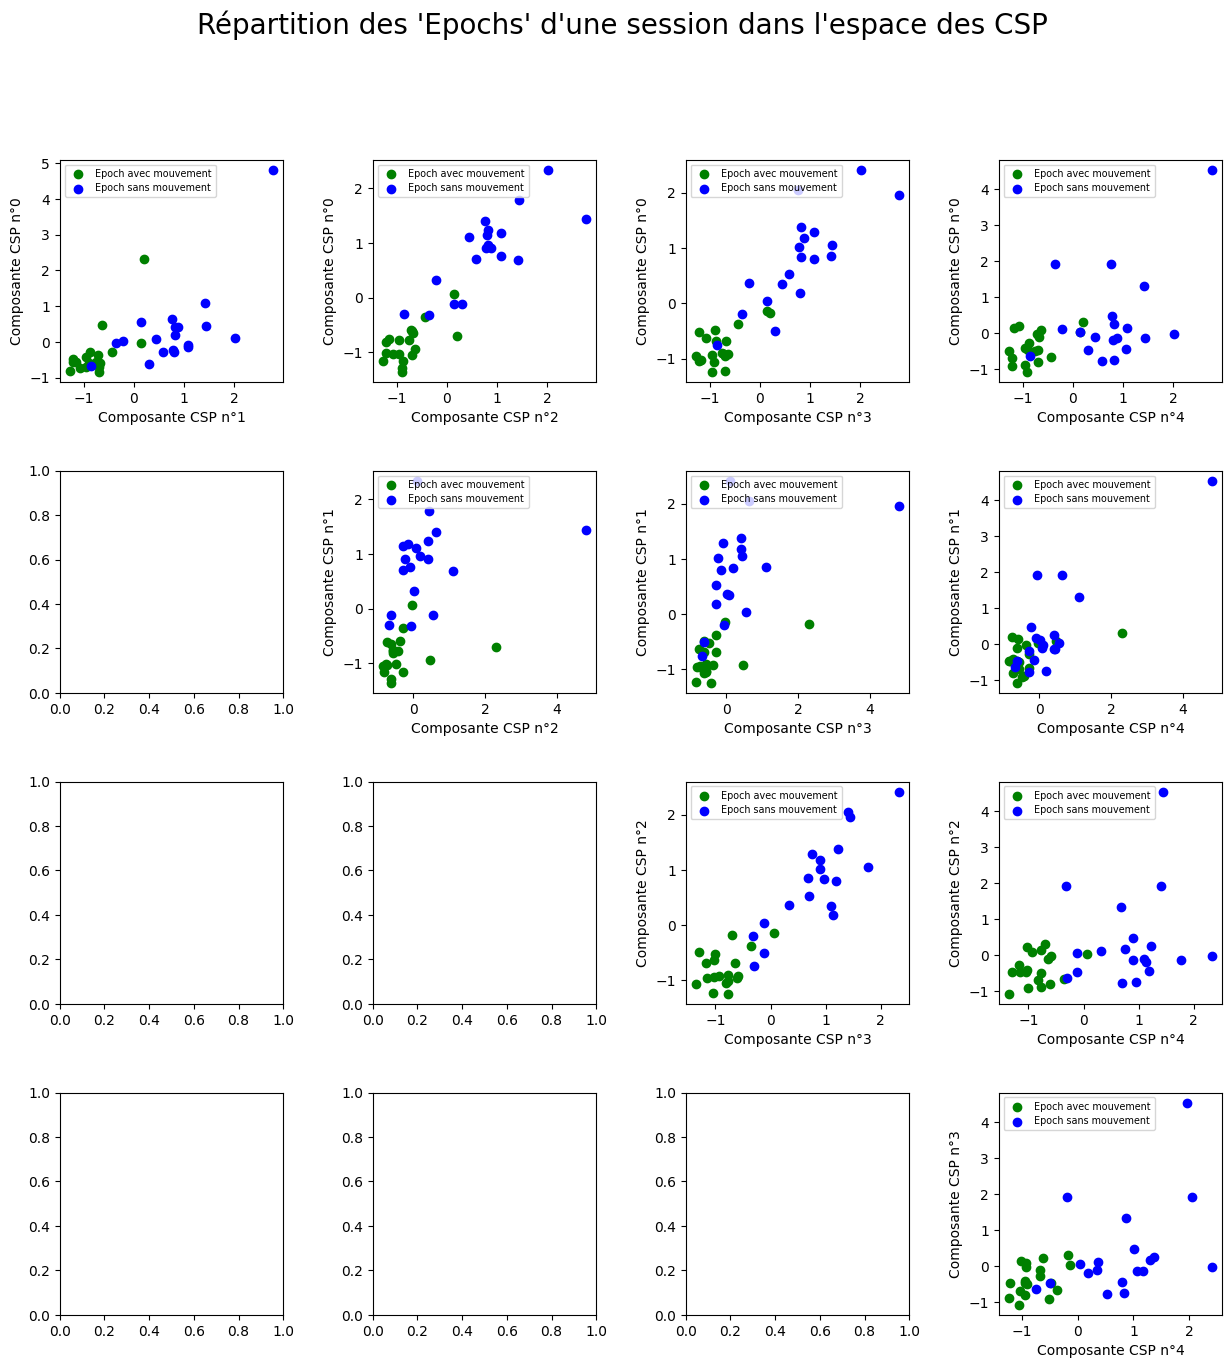

In [31]:
# Couple patient/Session sur lequel afficher la CSP
n_patient_to_plot = n_patient_train
n_session_to_plot = n_session_train
csp_data = pip.transform(X_patients[n_patient_to_plot][n_session_to_plot])
labels = y_patients[n_patient_to_plot][n_session_to_plot]
plot_csp_2(csp_data, labels)
# plt.suptitle(f"CSP entrainé sur Patient n°: {n_patient_train} & Session n°: {n_session_train}\n" +
#               f"Visualisation sur Patient n°: {n_patient_to_plot} & Session n°: {n_session_to_plot}")

plt.suptitle(f"Répartition des 'Epochs' d'une session dans l'espace des CSP",fontsize = 20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Text(0.5, 0.98, 'CSP entrainé sur Patient n°: 0 & Session n°: 1\nVisualisation sur Patient n°: 3 & Session n°: 0')

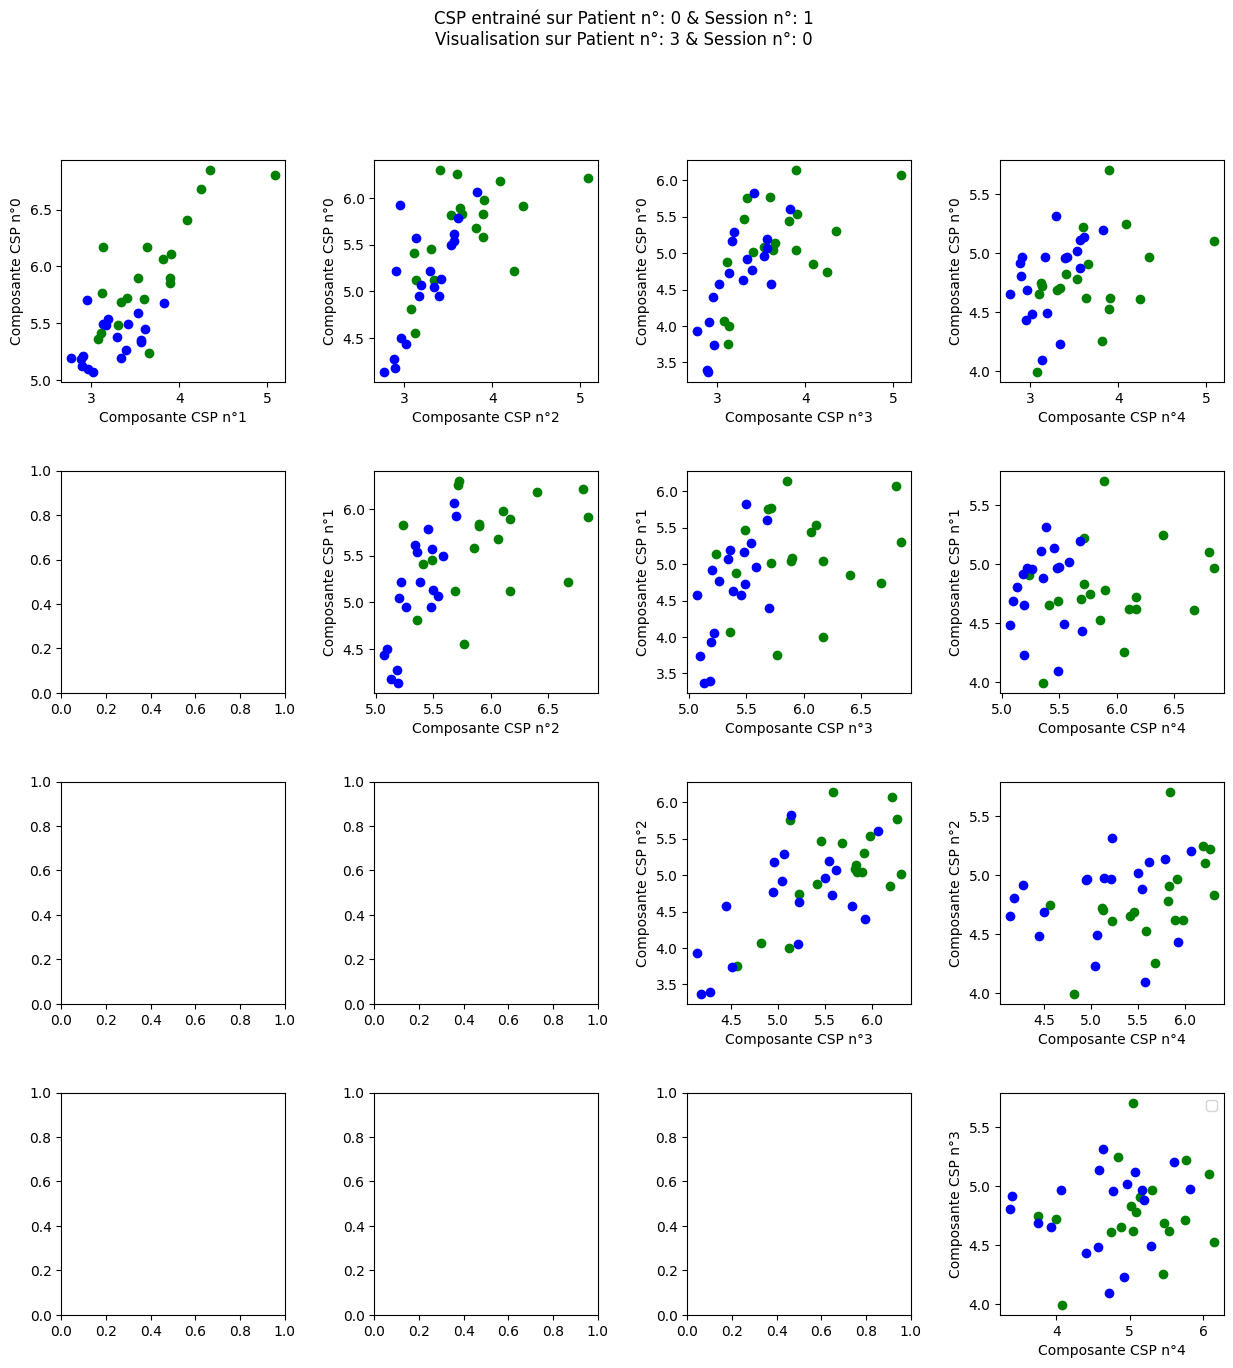

In [15]:
# Couple patient/Session sur lequel afficher la CSP
n_patient_to_plot = 3
n_session_to_plot = 0
csp_data = pip.transform(X_patients[n_patient_to_plot][n_session_to_plot])
labels = y_patients[n_patient_to_plot][n_session_to_plot]
plot_csp(csp_data, labels)
plt.suptitle(f"CSP entrainé sur Patient n°: {n_patient_train} & Session n°: {n_session_train}\n" +
              f"Visualisation sur Patient n°: {n_patient_to_plot} & Session n°: {n_session_to_plot}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Text(0.5, 0.98, 'CSP entrainé sur Patient n°: 0 & Session n°: 1\nVisualisation sur Patient n°: 2 & Session n°: 0')

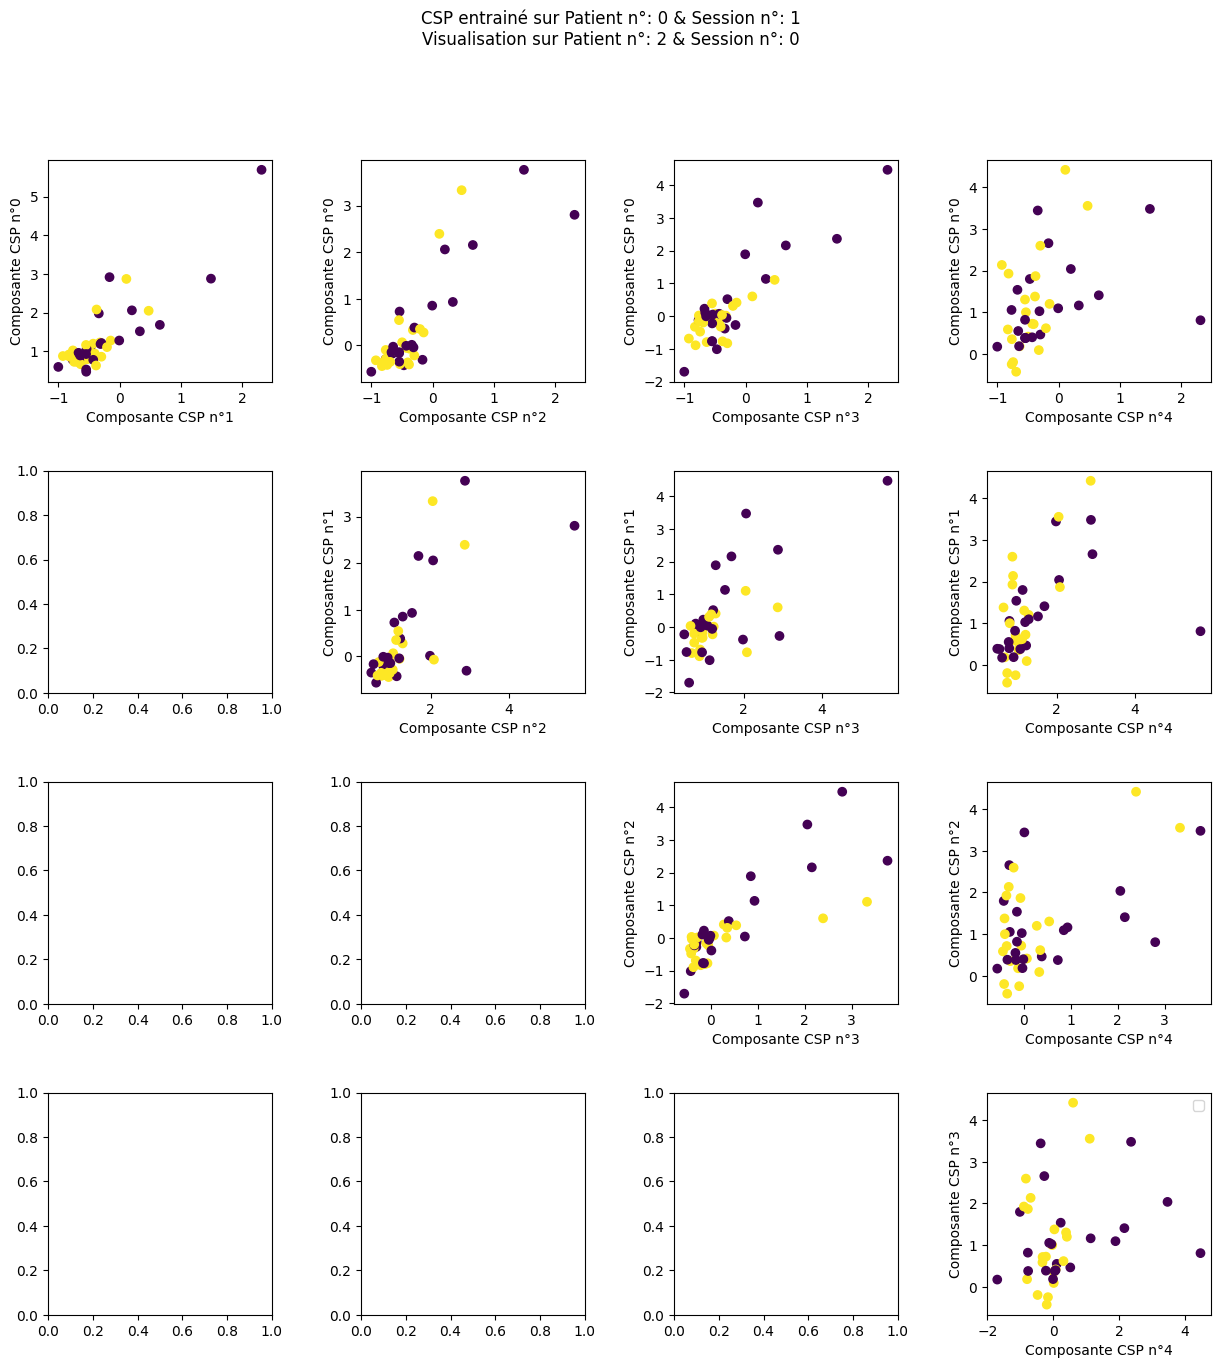

In [12]:
# Couple patient/Session sur lequel afficher la CSP
n_patient_to_plot = 2
n_session_to_plot = 0
csp_data = pip.transform(X_patients[n_patient_to_plot][n_session_to_plot])
labels = y_patients[n_patient_to_plot][n_session_to_plot]
plot_csp(csp_data, labels)
plt.suptitle(f"CSP entrainé sur Patient n°: {n_patient_train} & Session n°: {n_session_train}\n" +
              f"Visualisation sur Patient n°: {n_patient_to_plot} & Session n°: {n_session_to_plot}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Text(0.5, 0.98, 'CSP entrainé sur Patient n°: 0 & Session n°: 1\nVisualisation sur Patient n°: 2 & Session n°: 1')

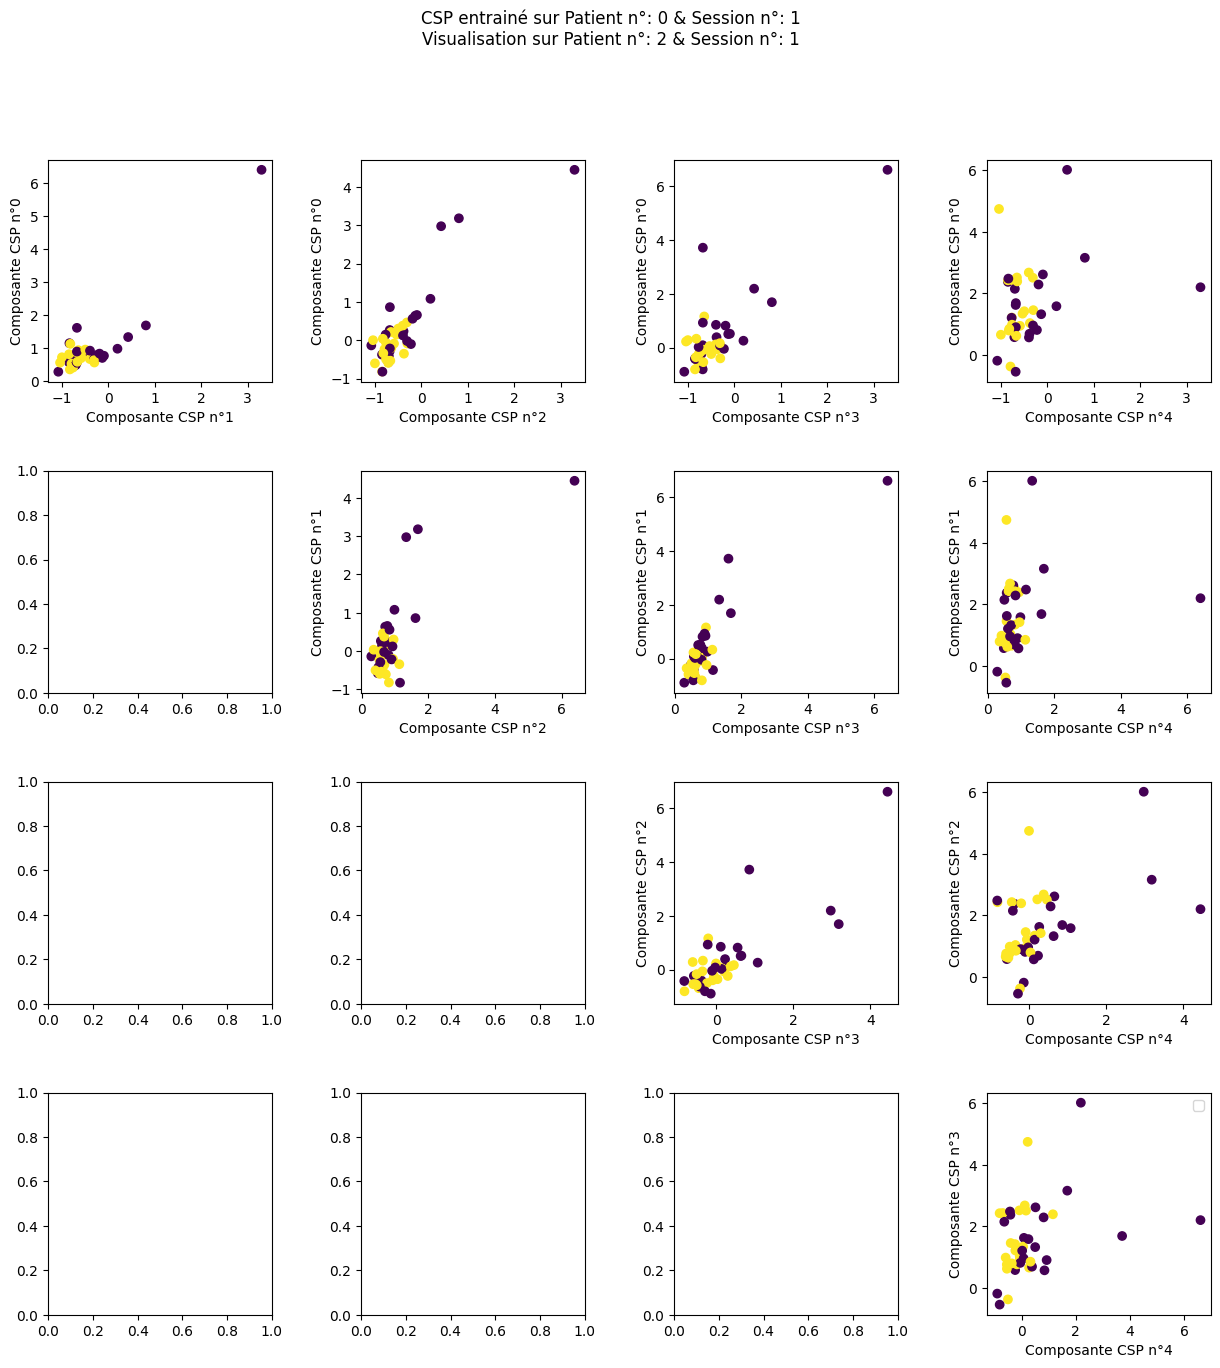

In [13]:
# Couple patient/Session sur lequel afficher la CSP
n_patient_to_plot = 2
n_session_to_plot = 1
csp_data = pip.transform(X_patients[n_patient_to_plot][n_session_to_plot])
labels = y_patients[n_patient_to_plot][n_session_to_plot]
plot_csp(csp_data, labels)
plt.suptitle(f"CSP entrainé sur Patient n°: {n_patient_train} & Session n°: {n_session_train}\n" +
              f"Visualisation sur Patient n°: {n_patient_to_plot} & Session n°: {n_session_to_plot}")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

Text(0.5, 0.98, 'CSP entrainé sur Patient n°: 0 & Session n°: 1\nVisualisation sur Patient n°: 0 & Session n°: 0')

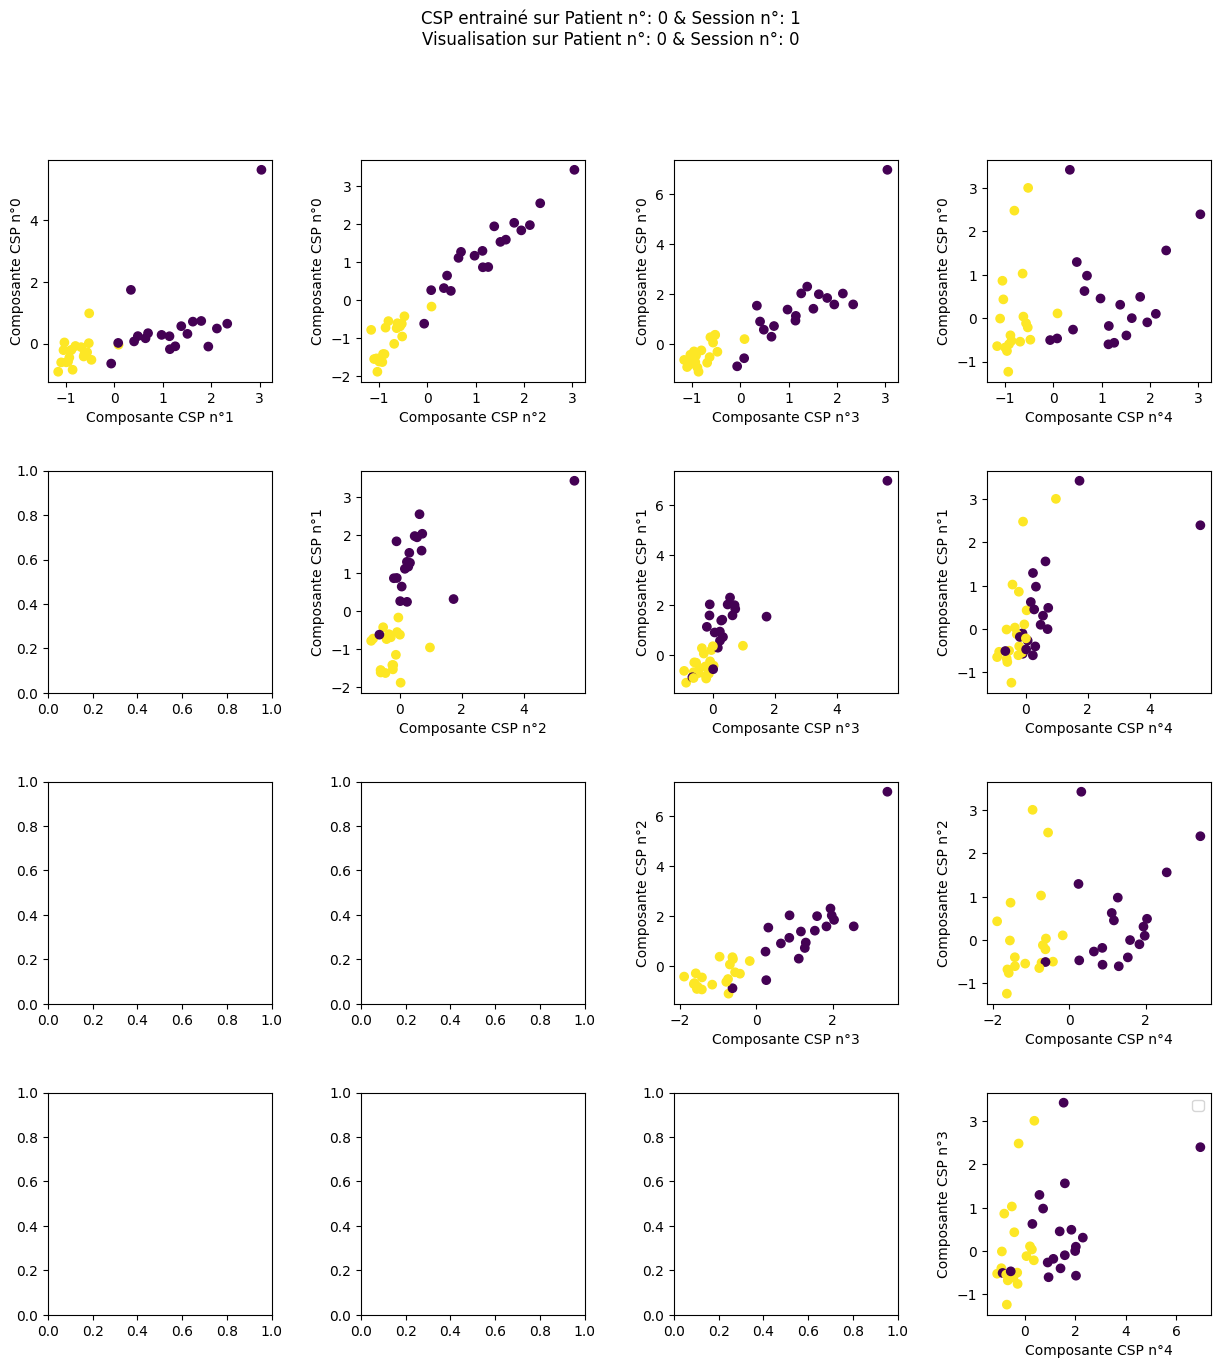

In [14]:
# Couple patient/Session sur lequel afficher la CSP
n_patient_to_plot = 0
n_session_to_plot = 0
csp_data = pip.transform(X_patients[n_patient_to_plot][n_session_to_plot])
labels = y_patients[n_patient_to_plot][n_session_to_plot]
plot_csp(csp_data, labels)
plt.suptitle(f"CSP entrainé sur Patient n°: {n_patient_train} & Session n°: {n_session_train}\n" +
              f"Visualisation sur Patient n°: {n_patient_to_plot} & Session n°: {n_session_to_plot}")

L'idée ici était bien de faire une CSP pour une seule session et de voir ensuite le comportement de cette CSP sur d'autres sessions. La conclusion de cette étude est que la CSP d'une session permet dans certains cas de bien discriminer "le mouvement et le non mouvement", dans quelques autres sessions. En revanche dans certains cas, ça ne fonctionne pas du tout.

On a alors essayé de tirer profit de cette propriété pour améliorer la classification dans deux cas distincts. L'idée était de choisir la meilleure session pour entrainer la CSP.

# 3 - 1er Cas d'utilisation de KMEANS: Patient identique

Ici on essaie d'utiliser un classifieur non-supervisé. L'idée provient du fait que la CSP permet de bien discriminer les "epochs" correspondant à du mouvement de celles correspondant à du non mouvement. Plus précisément la CSP sépare de manière significative les deux classes dans l'espace des features. Nous avons vu qu'utiliser un classifieur supervisé en aval de la CSP pouvait comporter des limites. Des biais inter-sessions et inter-patients importants déplacent les classes dans l'espaces des features de la CSP. Ainsi, la frontière de décision du classifieur ne sera plus adaptée sur une autre session et/ou sur un autre patient. L'utilisation du non-supervisée est une des solutions qui pourrait pallier à ce problème. 

Une autre solution serait d'utiliser des classifieurs adaptatifs. (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=5638613) (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6695959) (https://www.semanticscholar.org/paper/Incremental-Common-Spatial-Pattern-algorithm-for-Zhao-Zhang/b59ba47fb5a147d312c54a25b81c5c31db760b49)

Le non-supervisé montre de bons résultats quand une pipeline est entrainée sur un patient et utilisée sur l'autre session du même patient. 

L'utilisation d'un classifieur non-supervisé semble cependant non adaptée à notre situation. En effet, nous avons besoin de prédire l'intention de mouvement ou non sur une unique petite fenêtre temporelle ou époque alors que l'utilisation d'algorithmes comme Kmeans requièrent un ensemble de ces objects. 

Ici un modèle de CSP + StandardScaler est entrainé sur une session. Puis la pipeline (CSP + Standard) + Kmeans est utilisé pour discriminer les deux clusters (mouvement OU non mouvement) sur une autre session du même patient. A noter que la connaissance des labels a priori est inutile ici.

Patient 0


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 0 - Score:  0.868 on session n °: 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 1 - Score:  0.947 on session n °: 0
Patient 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 0 - Score:  0.974 on session n °: 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 1 - Score:  0.974 on session n °: 0
Patient 2


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 0 - Score:  0.571 on session n °: 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 1 - Score:  0.548 on session n °: 0
Patient 3


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 0 - Score:  0.789 on session n °: 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on session n°: 1 - Score:  1.000 on session n °: 0
Patient 4
  Abort, not enough sessions


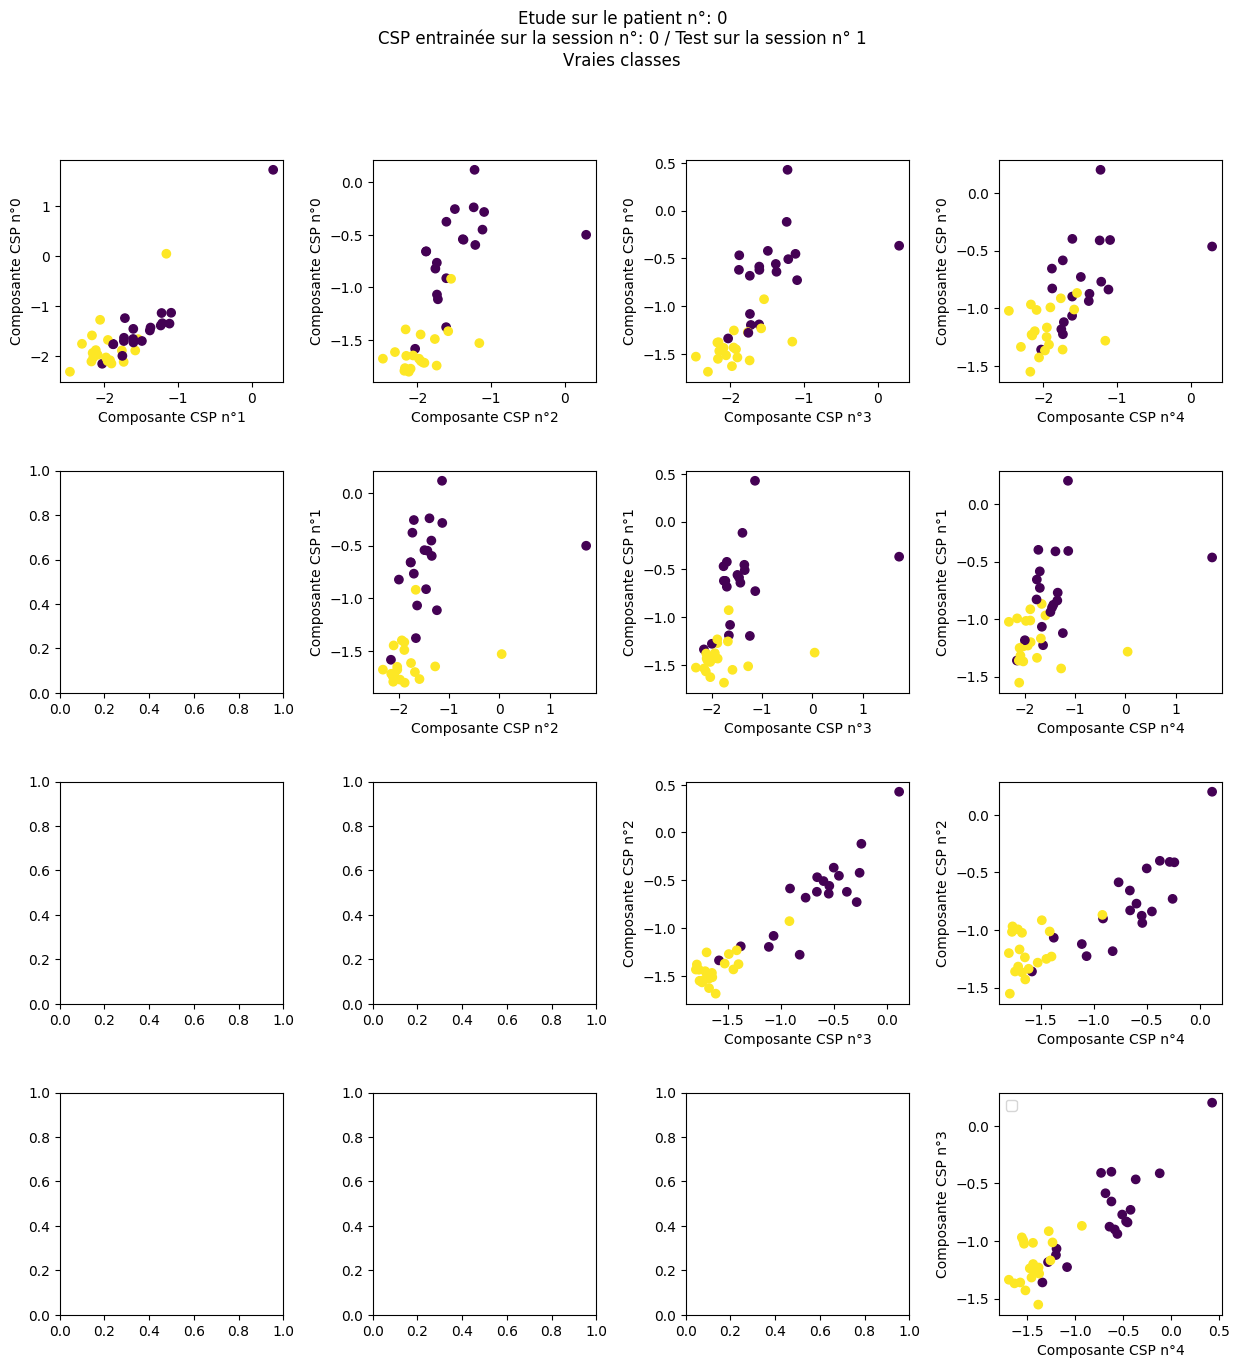

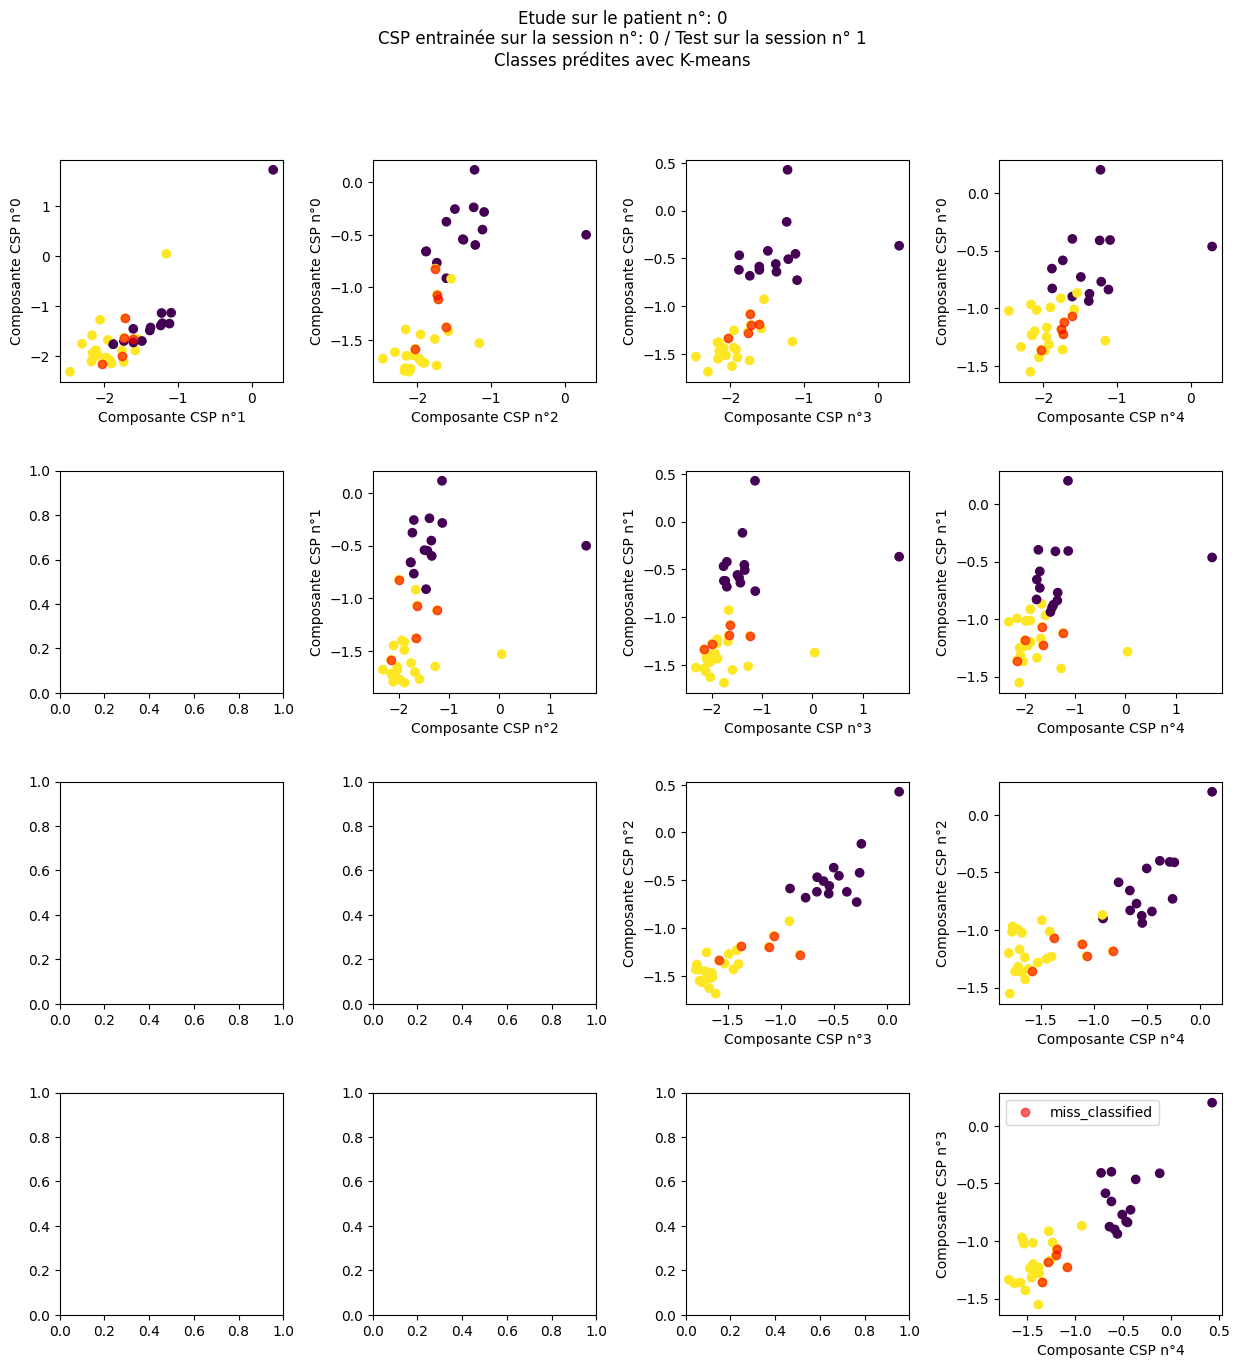

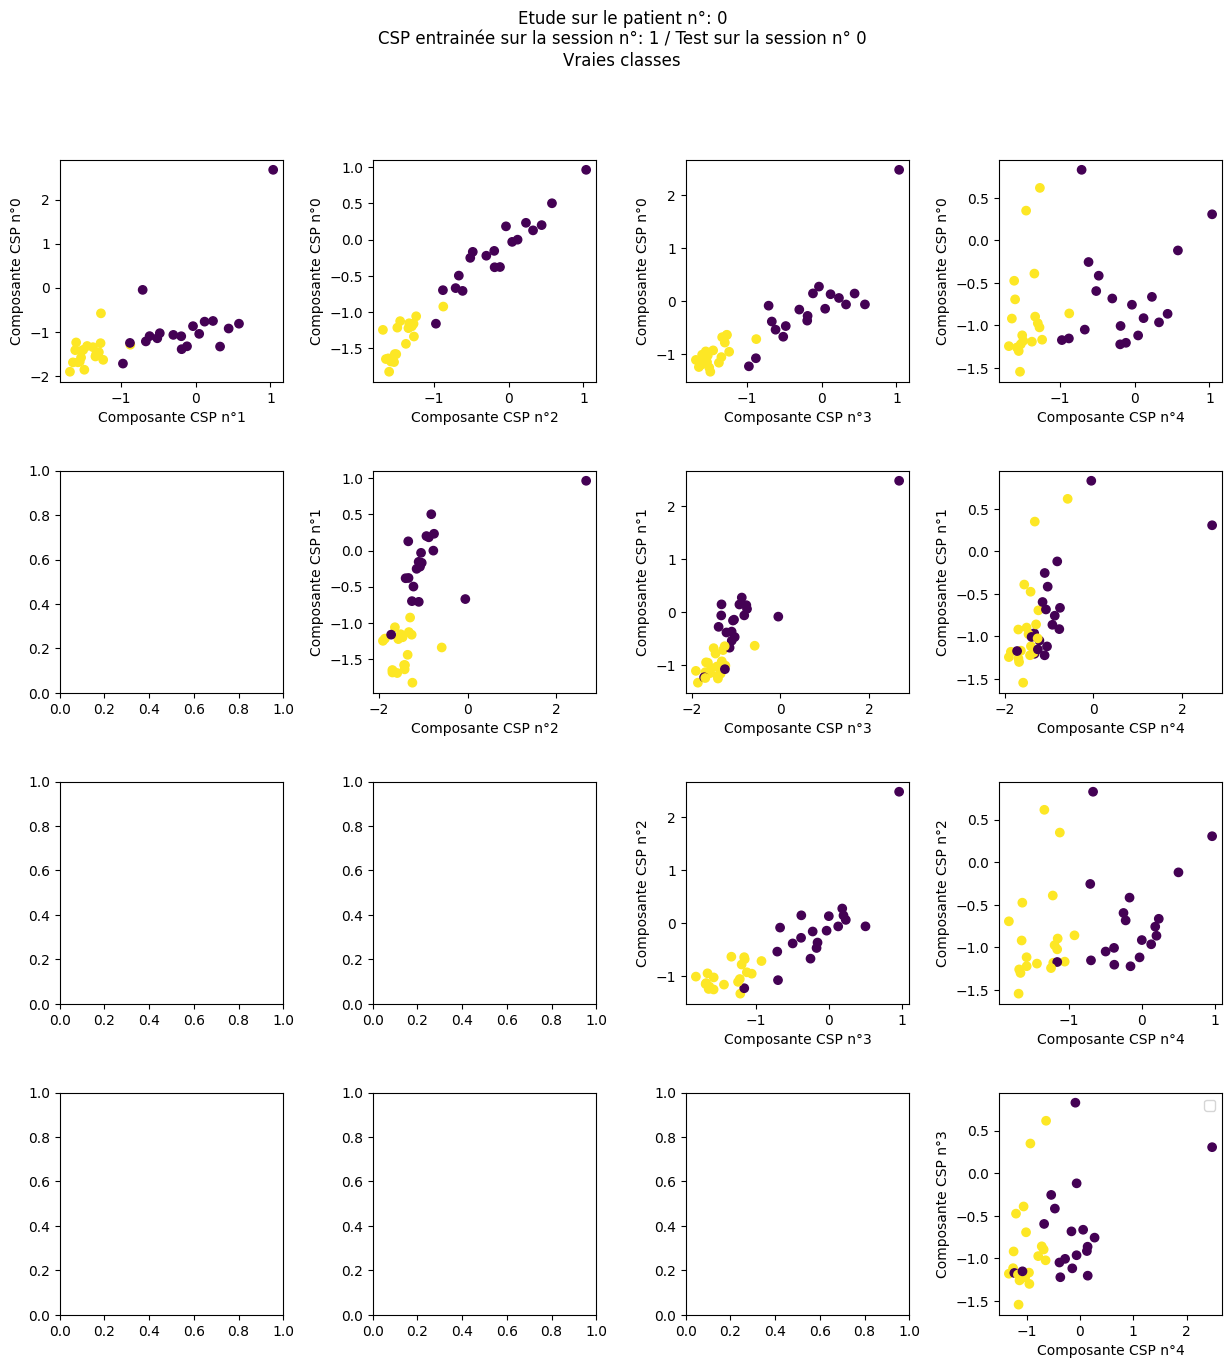

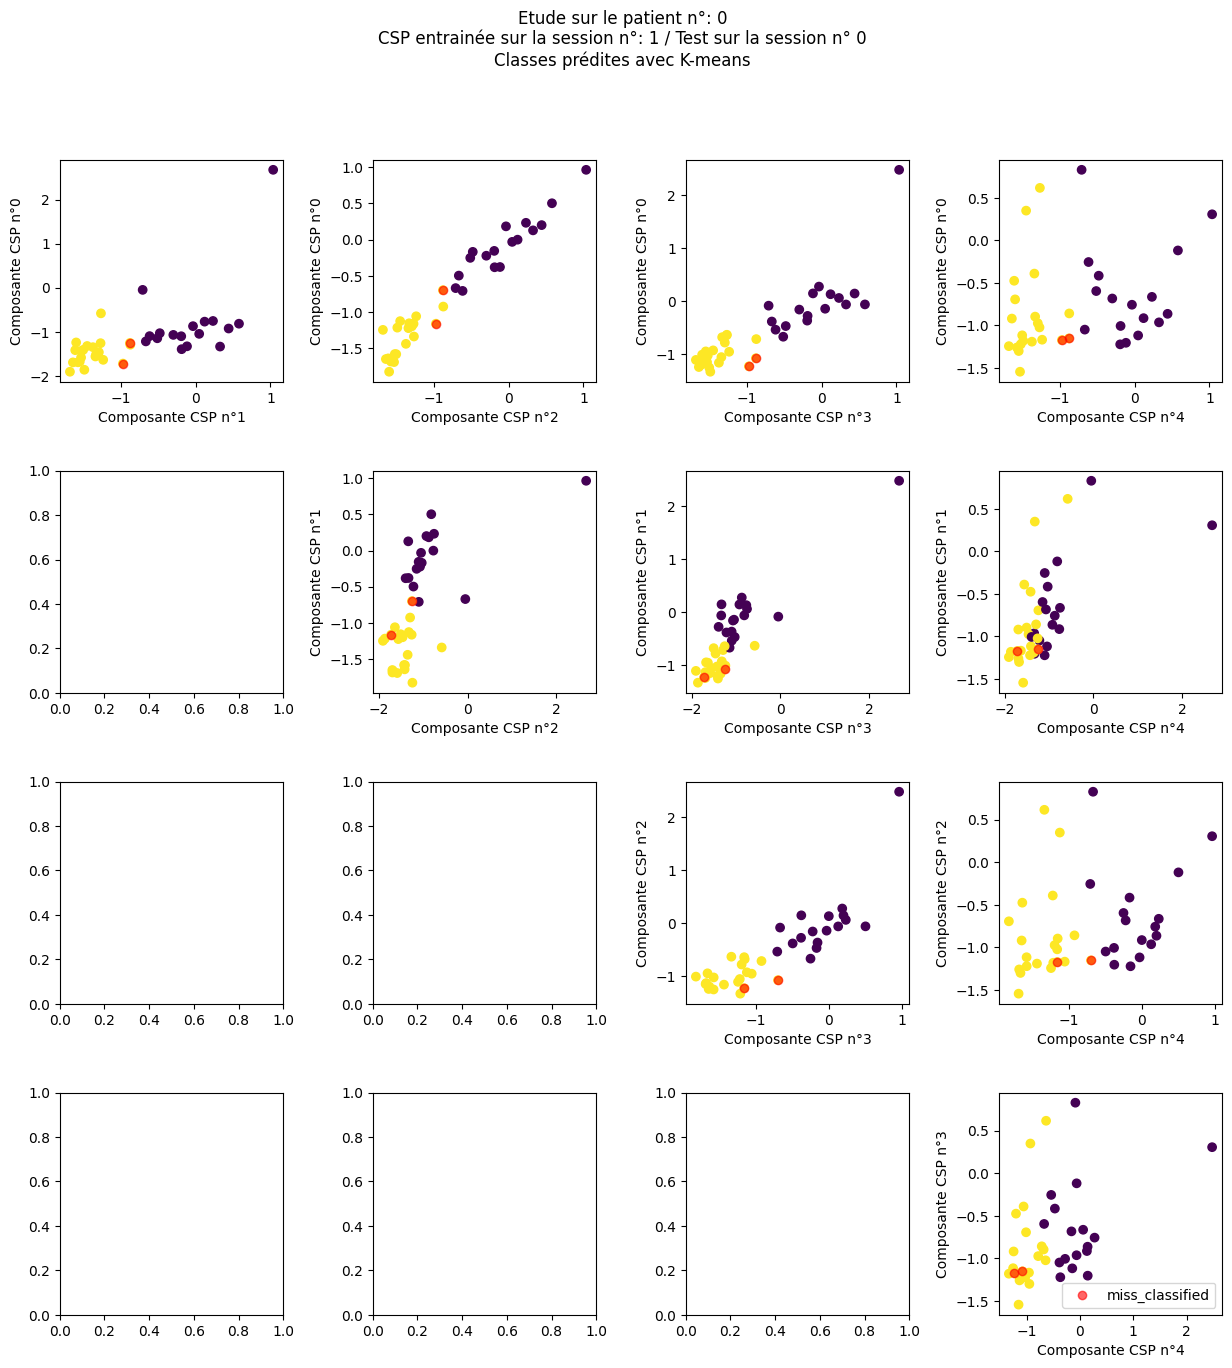

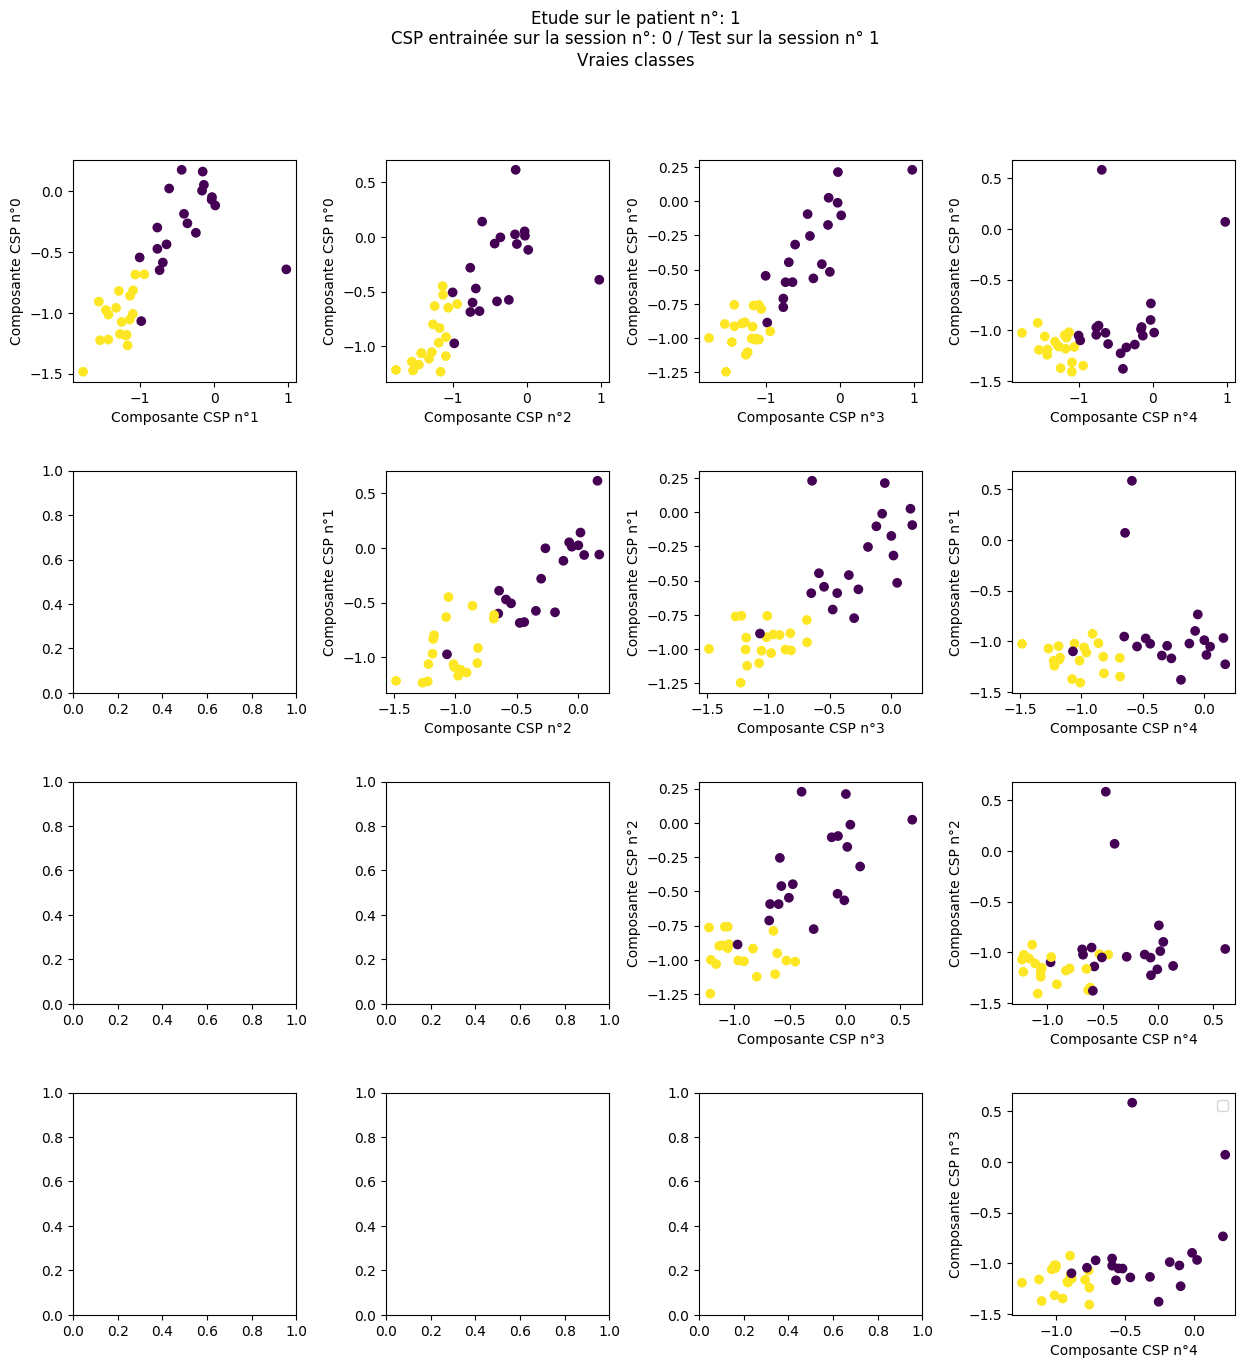

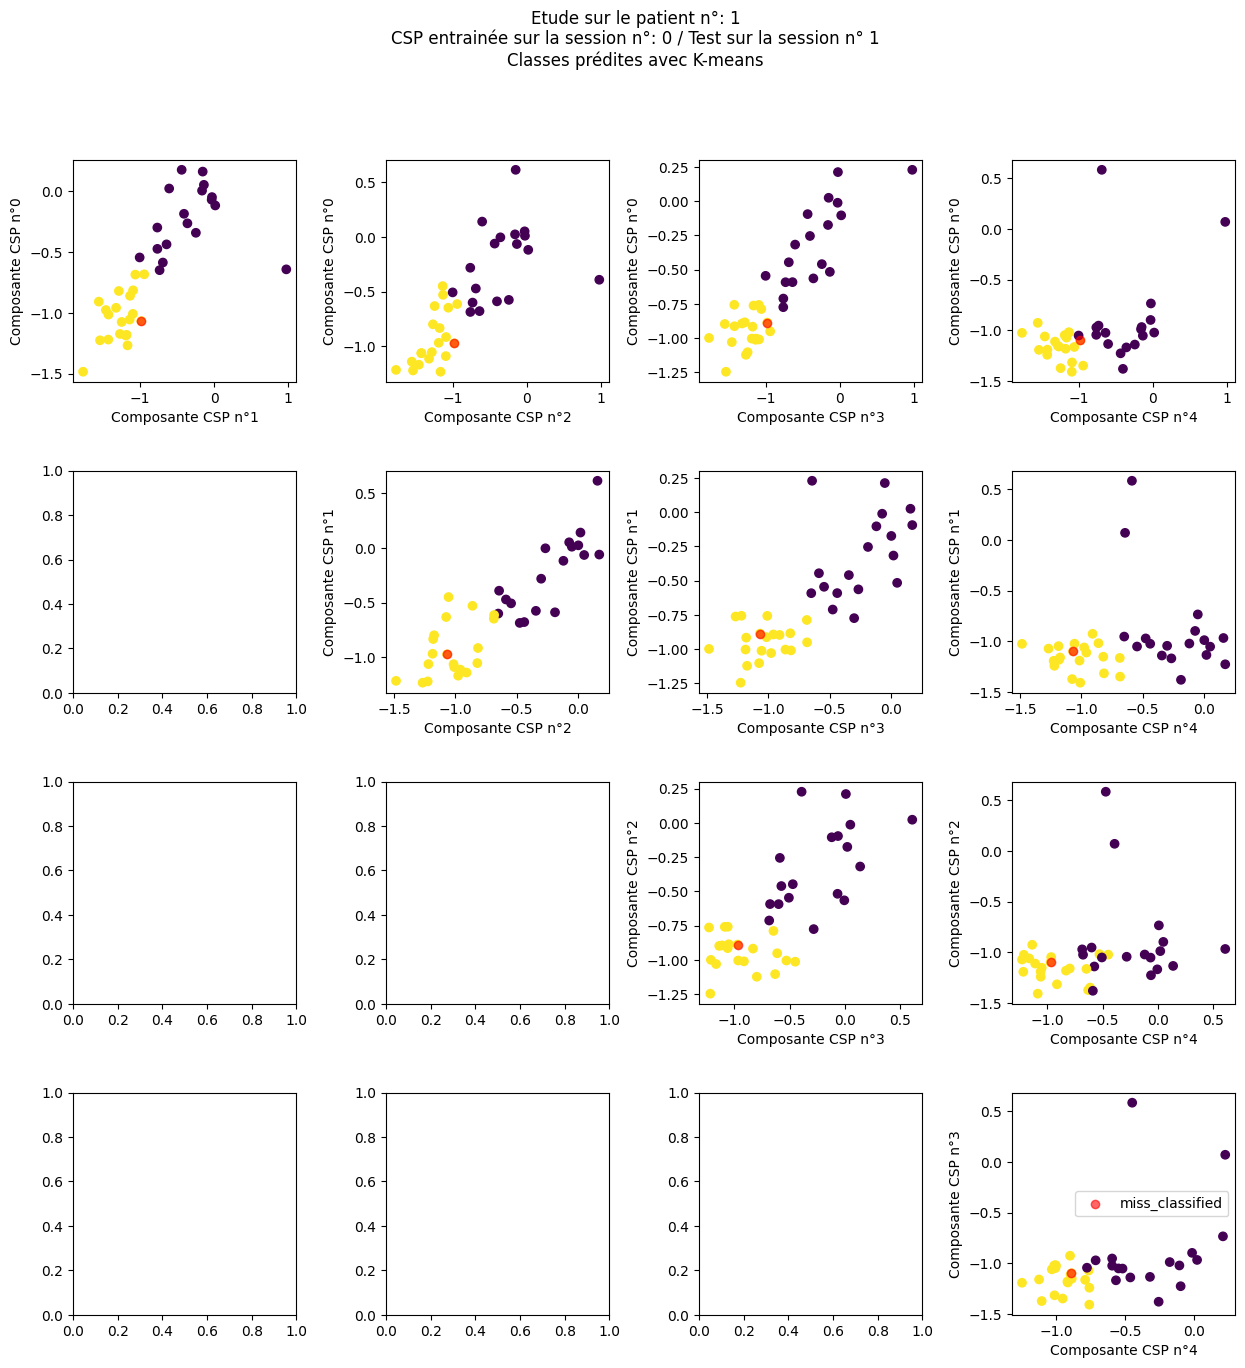

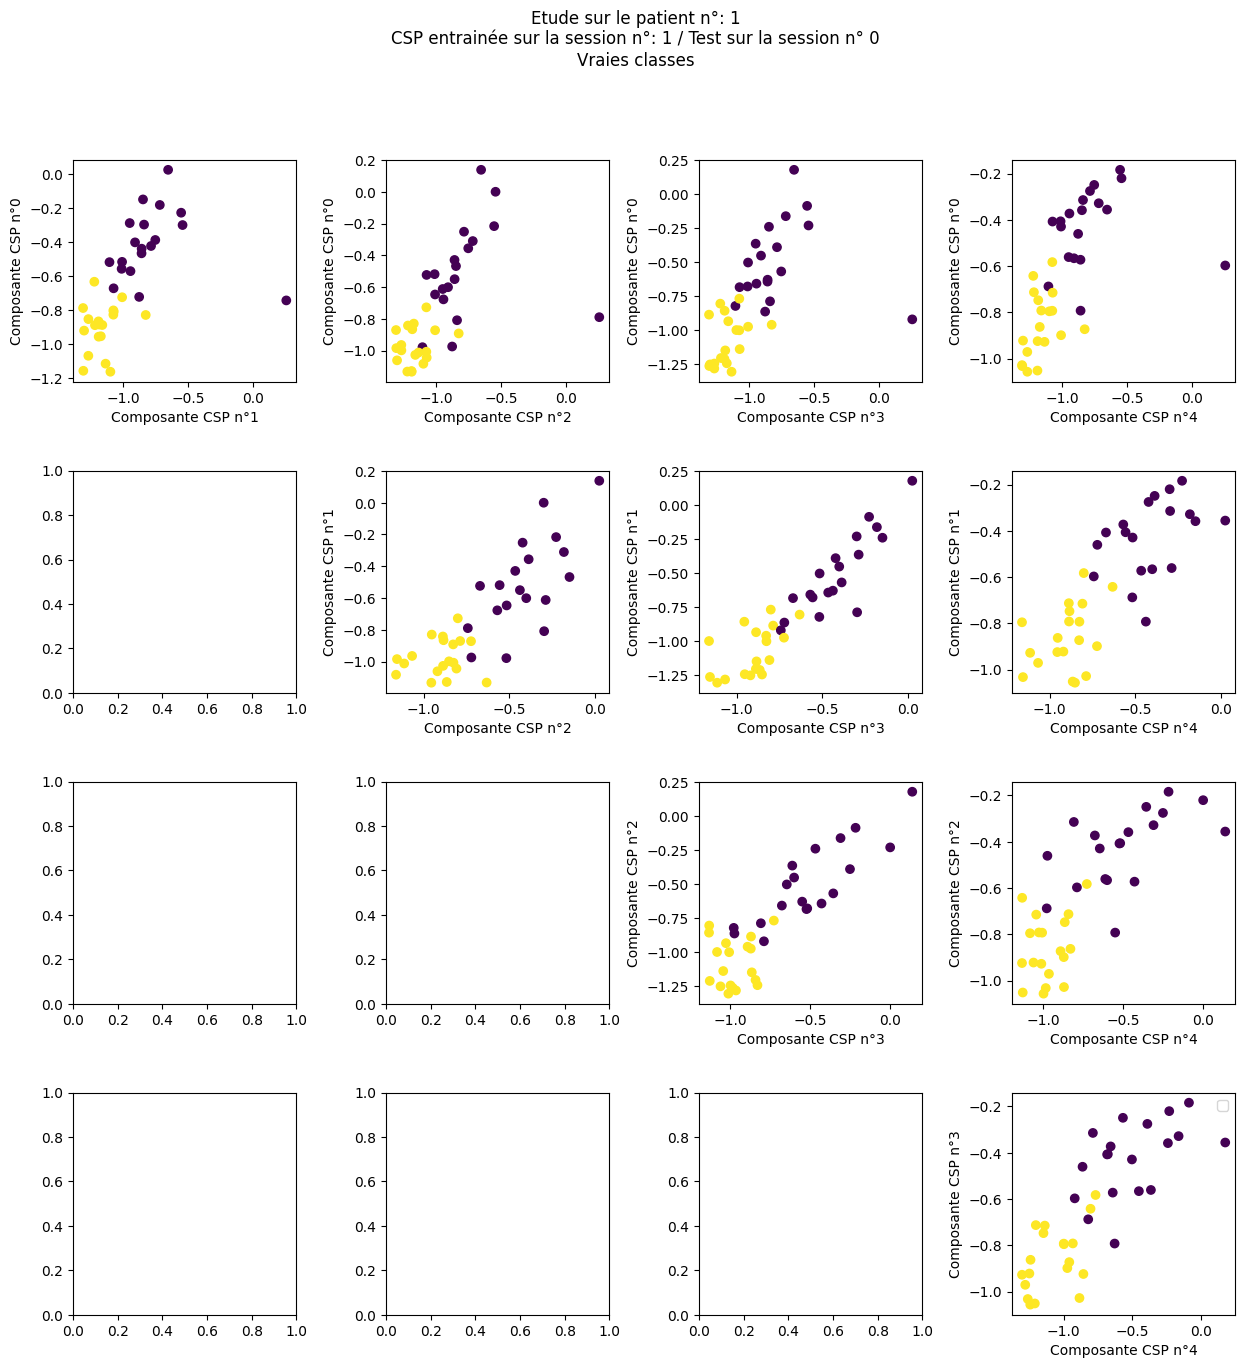

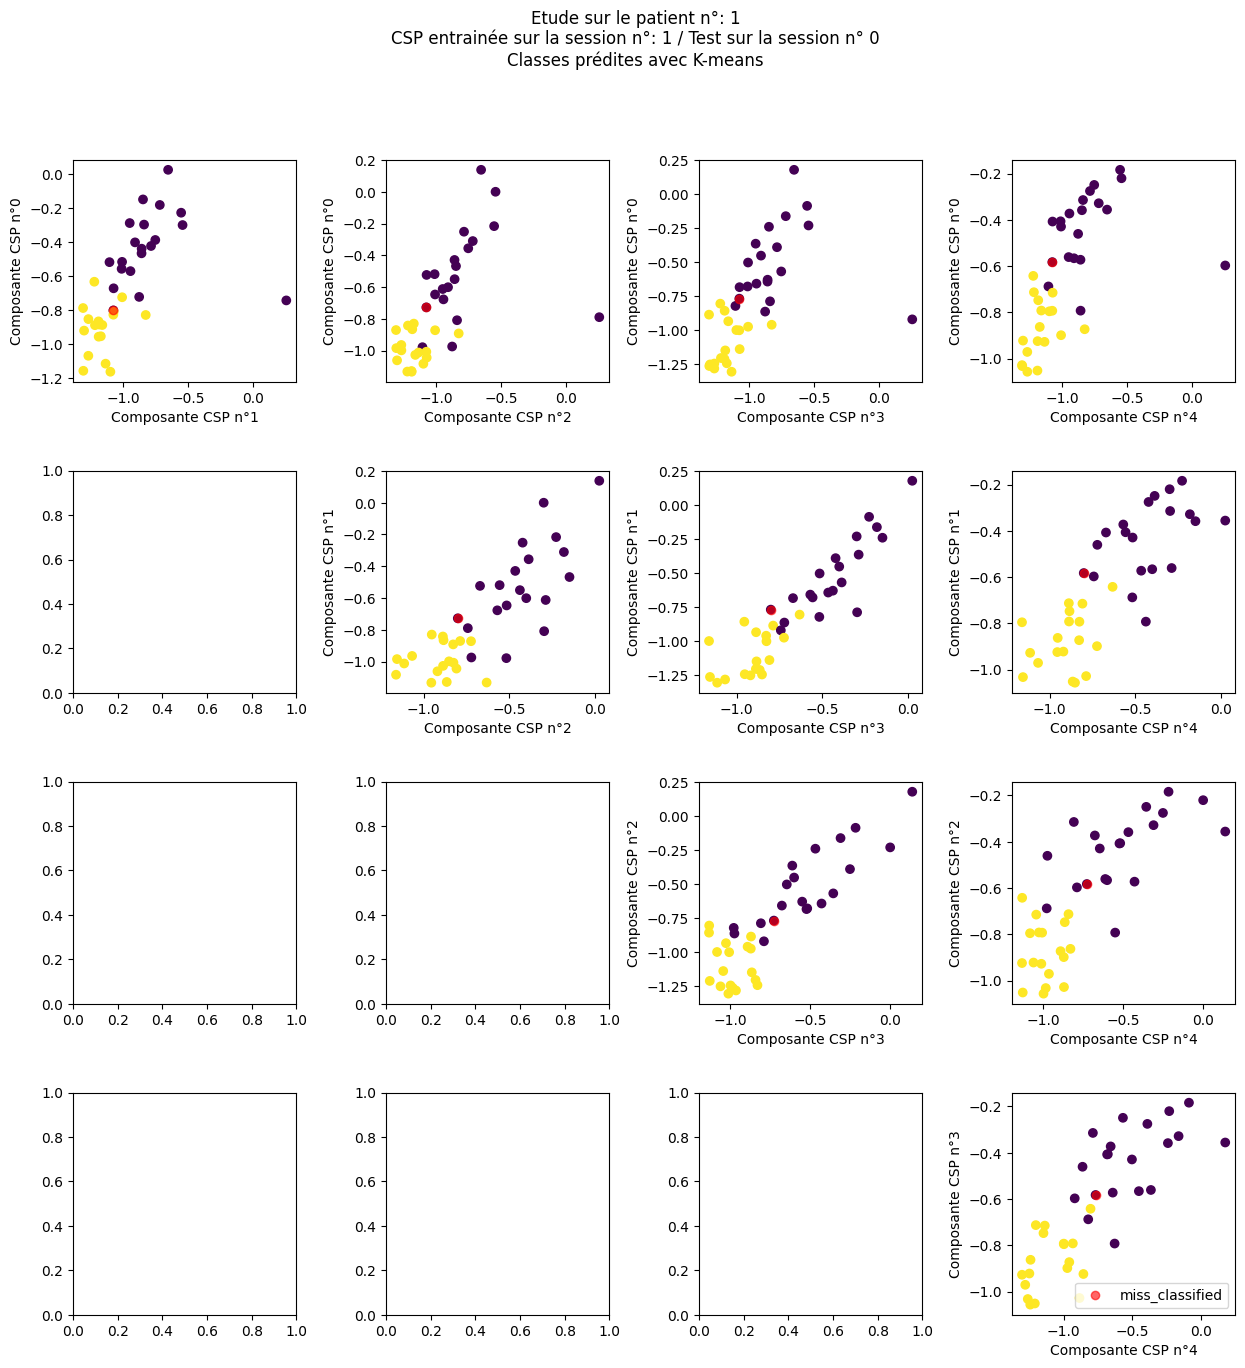

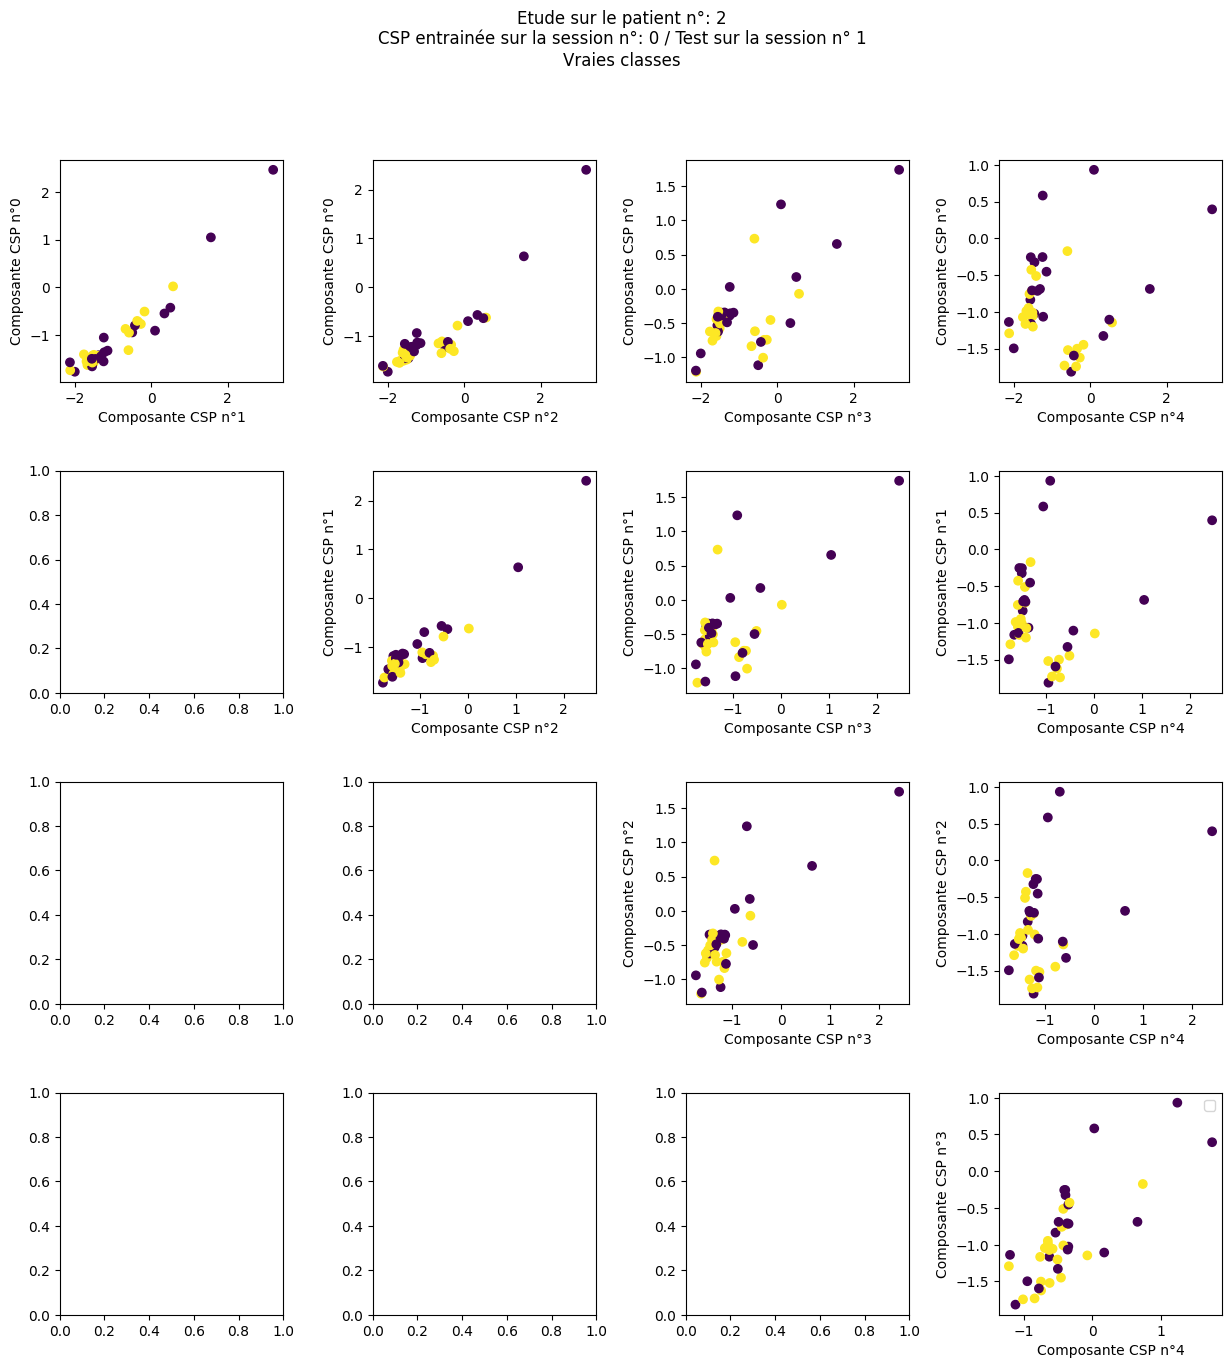

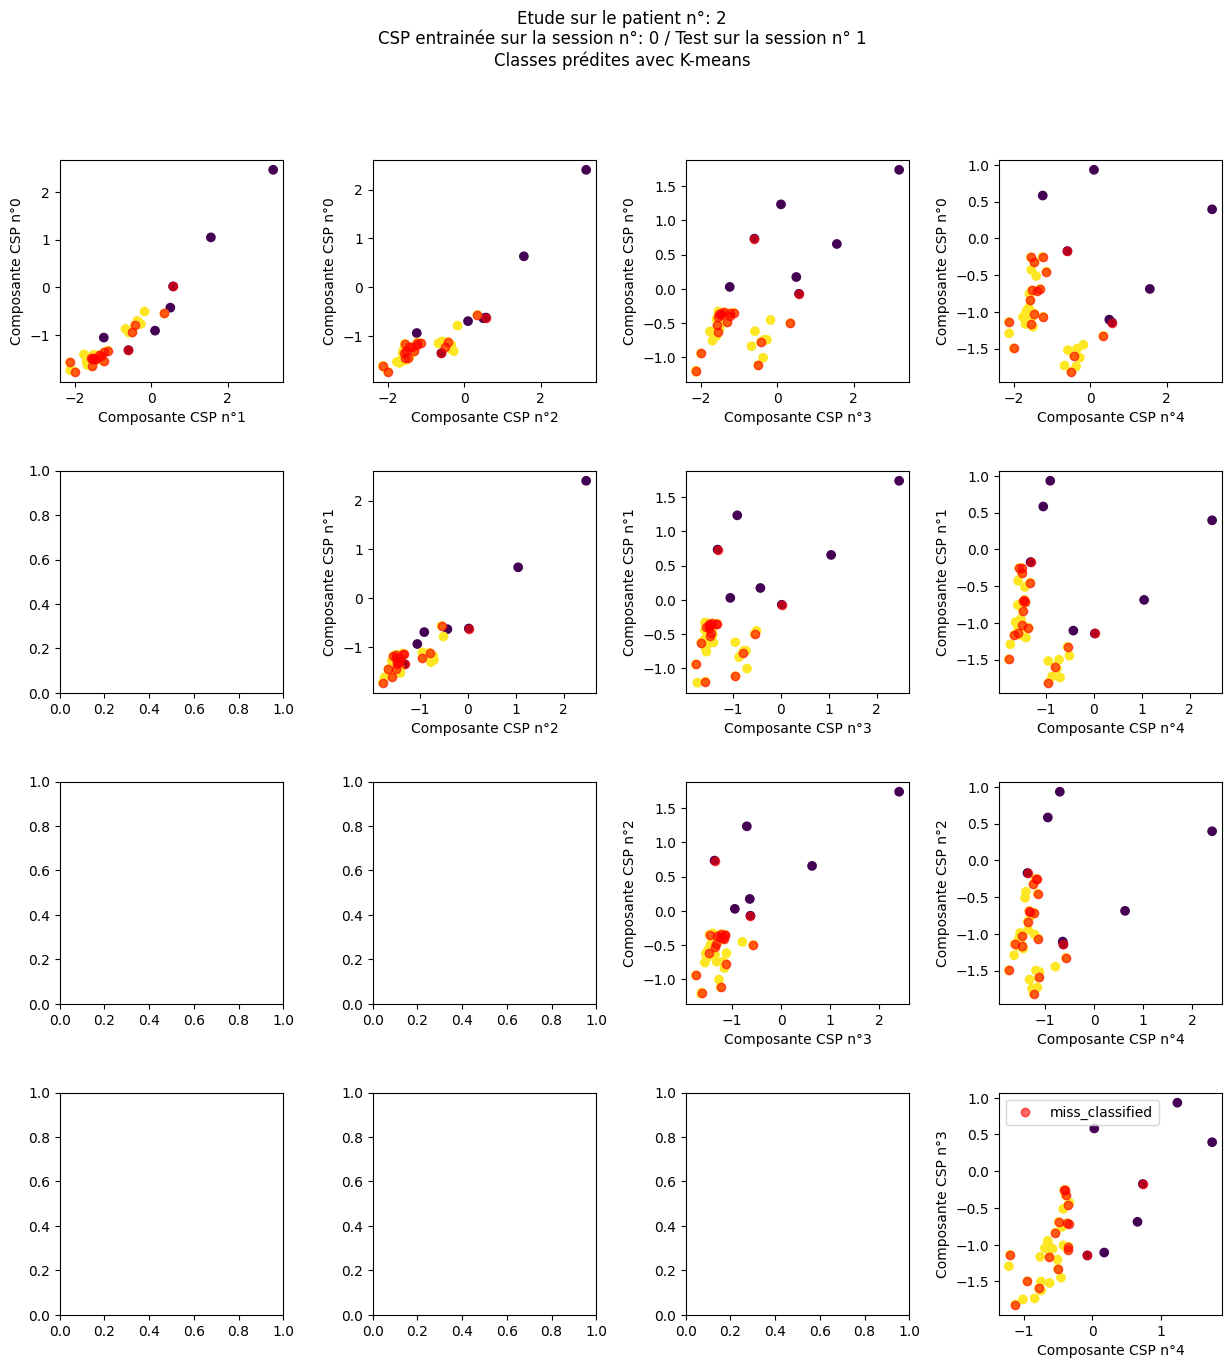

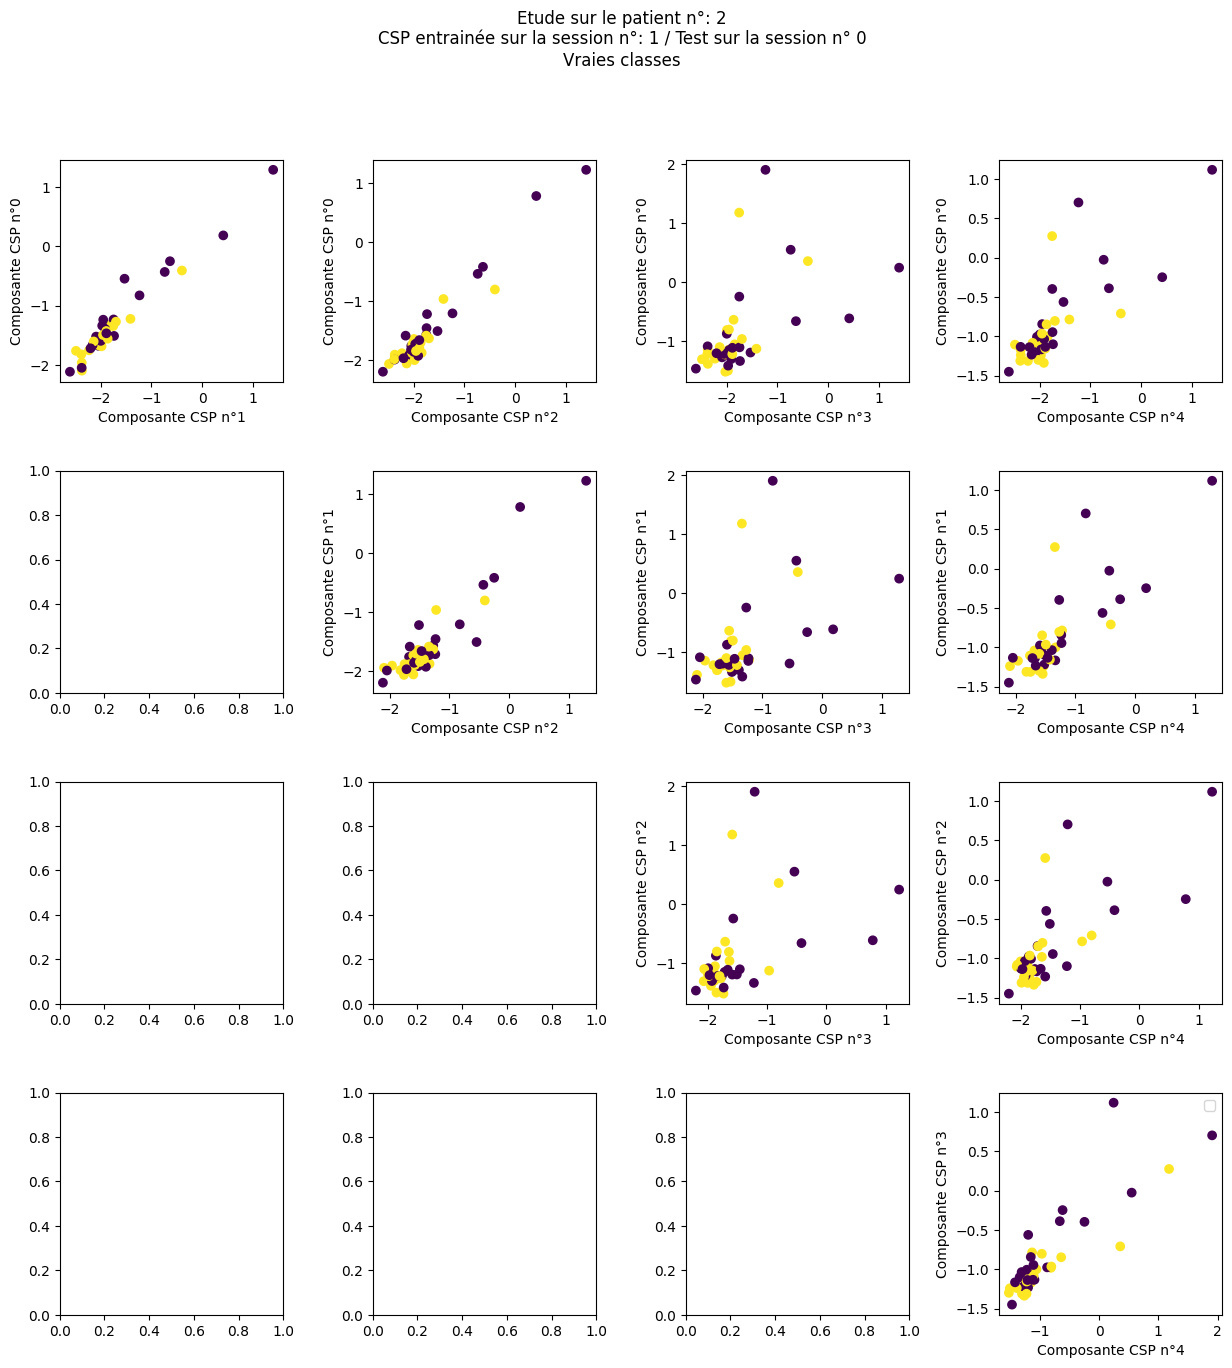

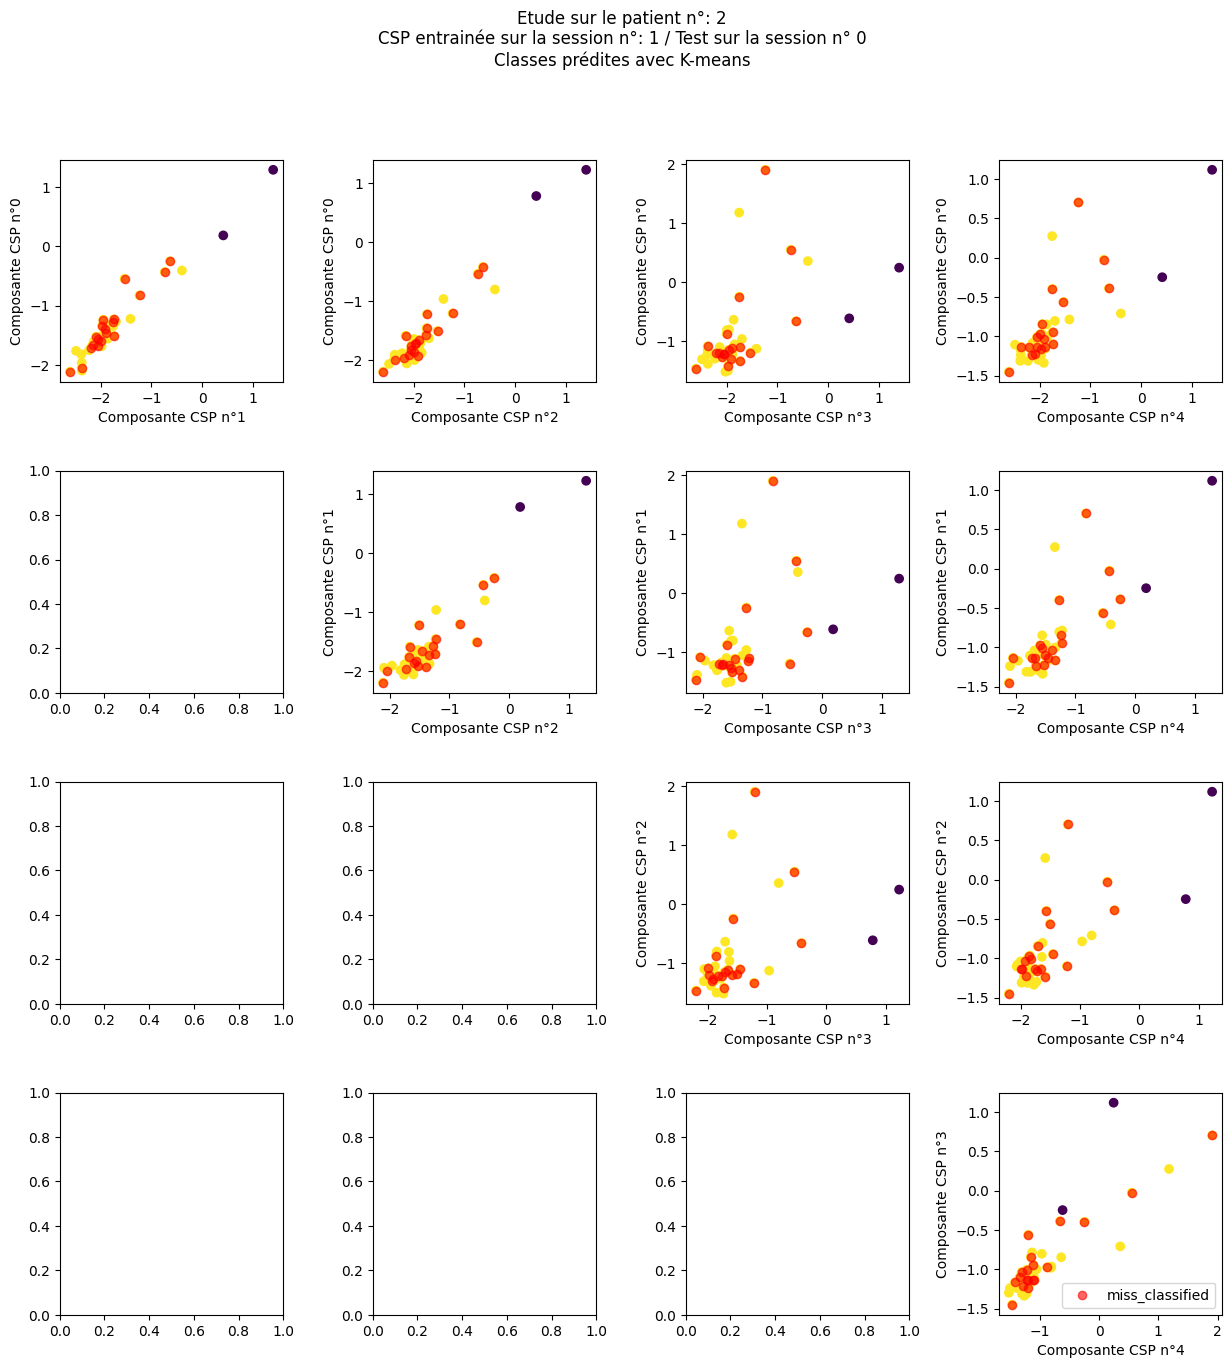

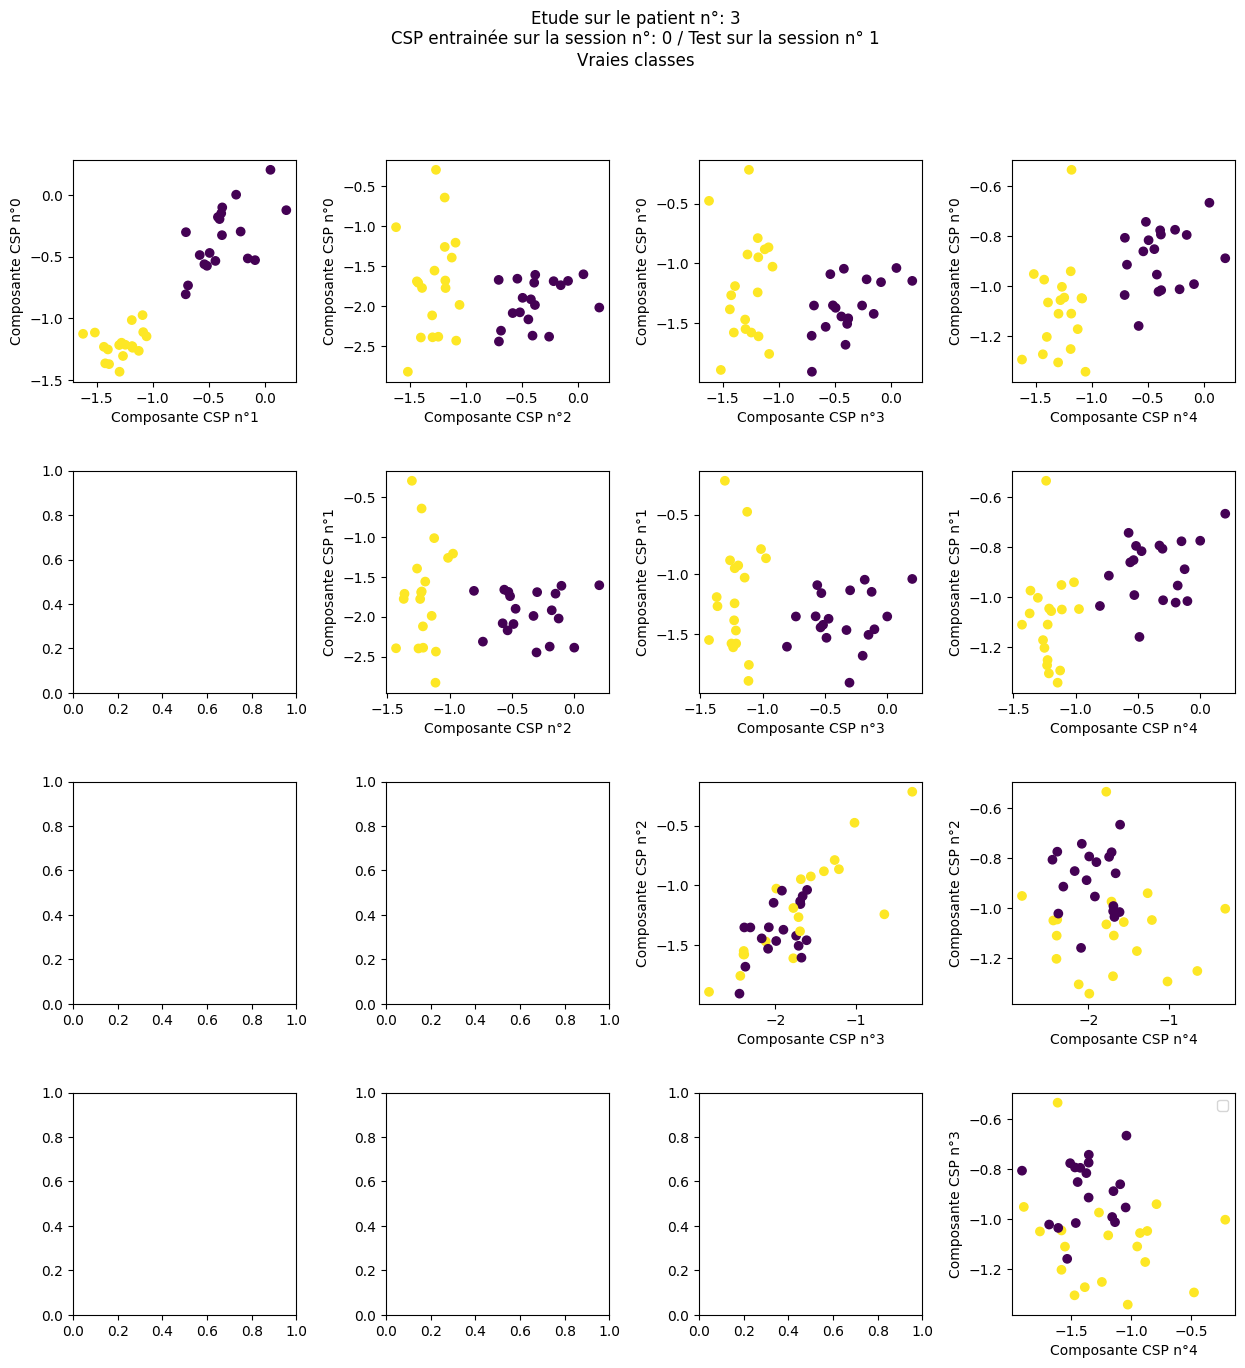

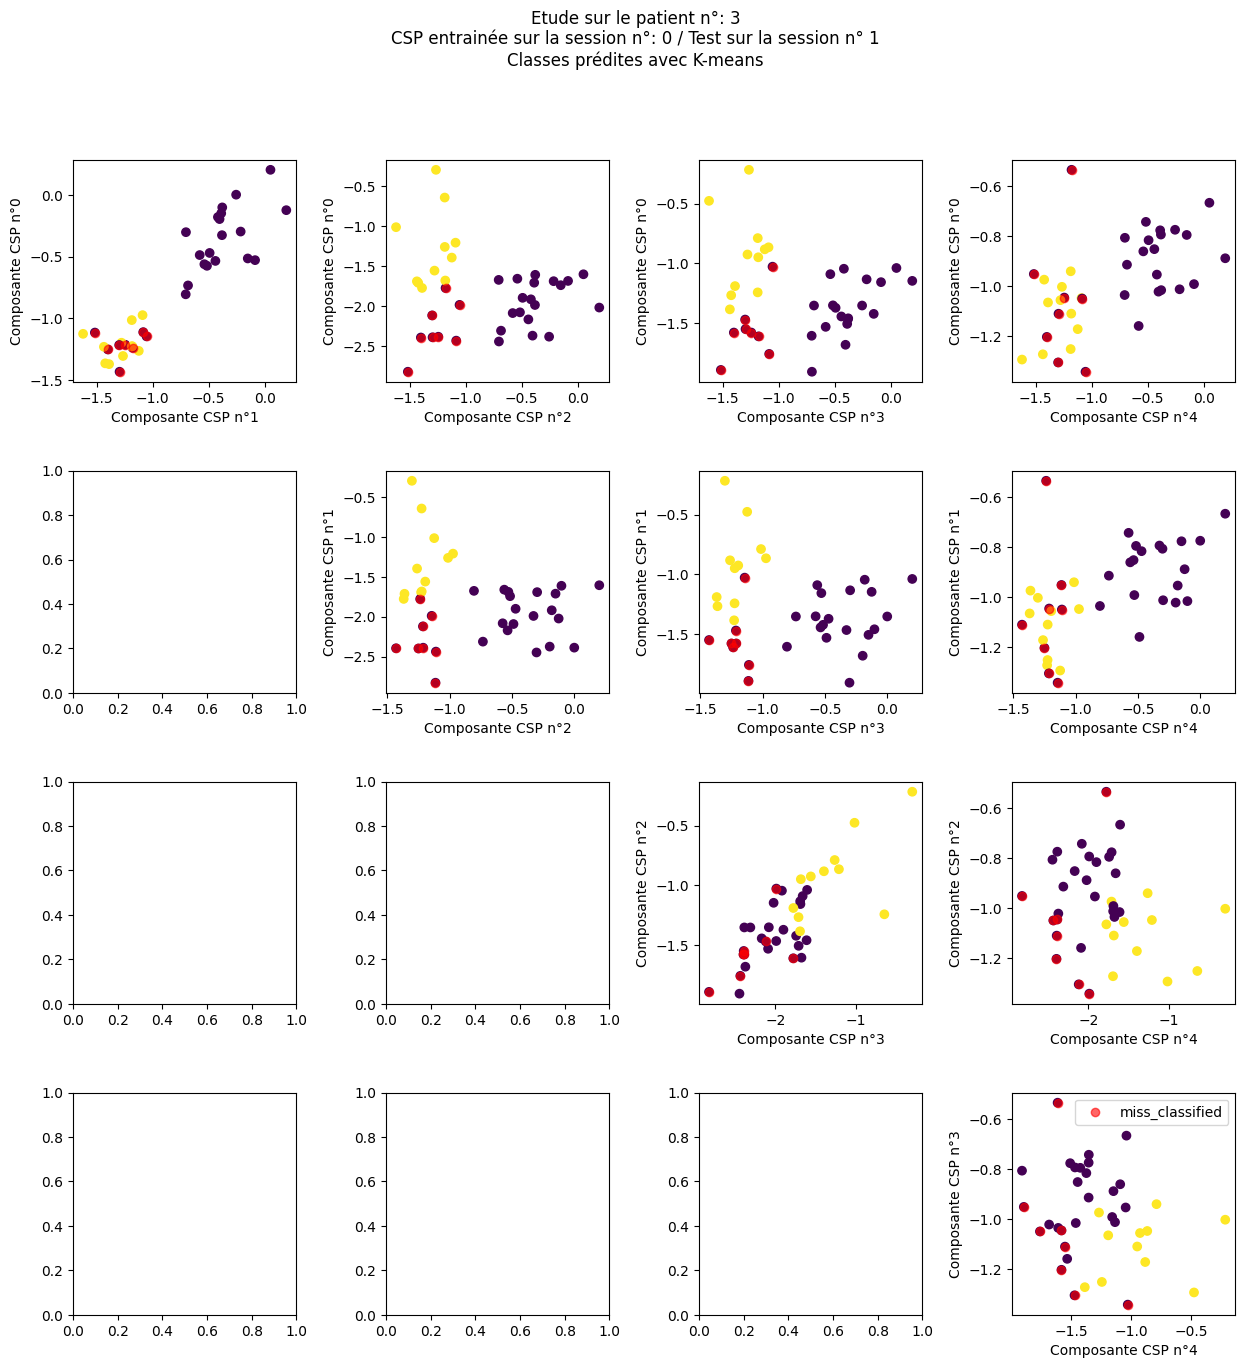

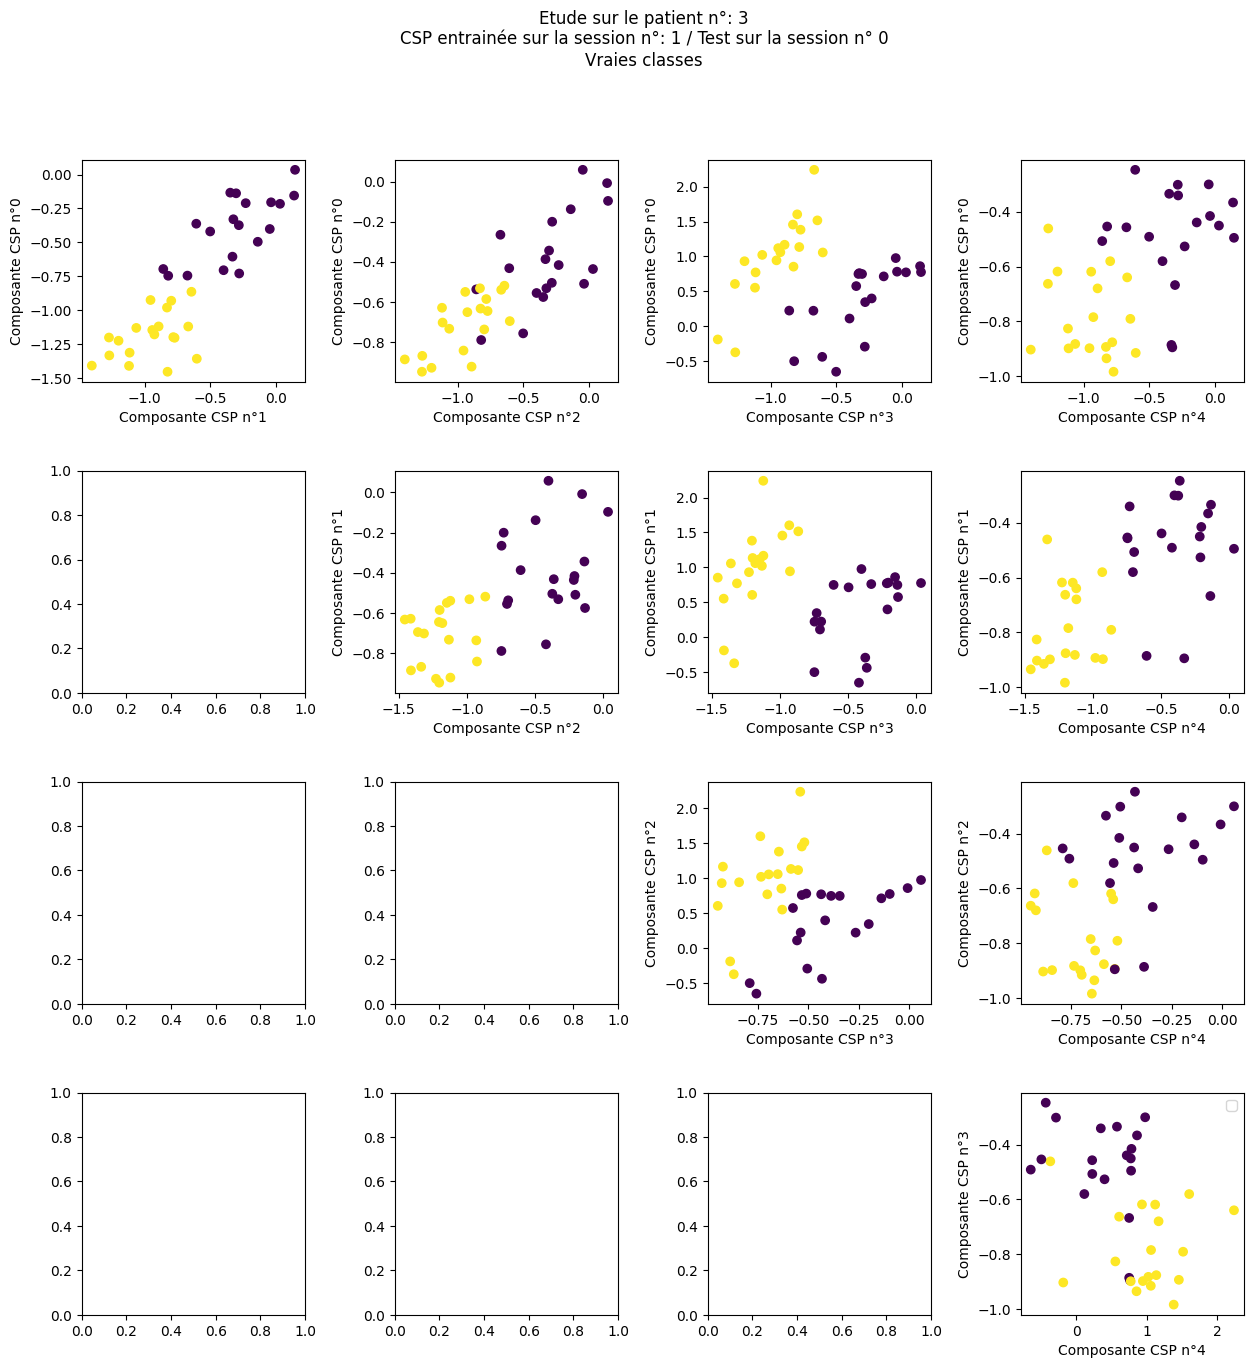

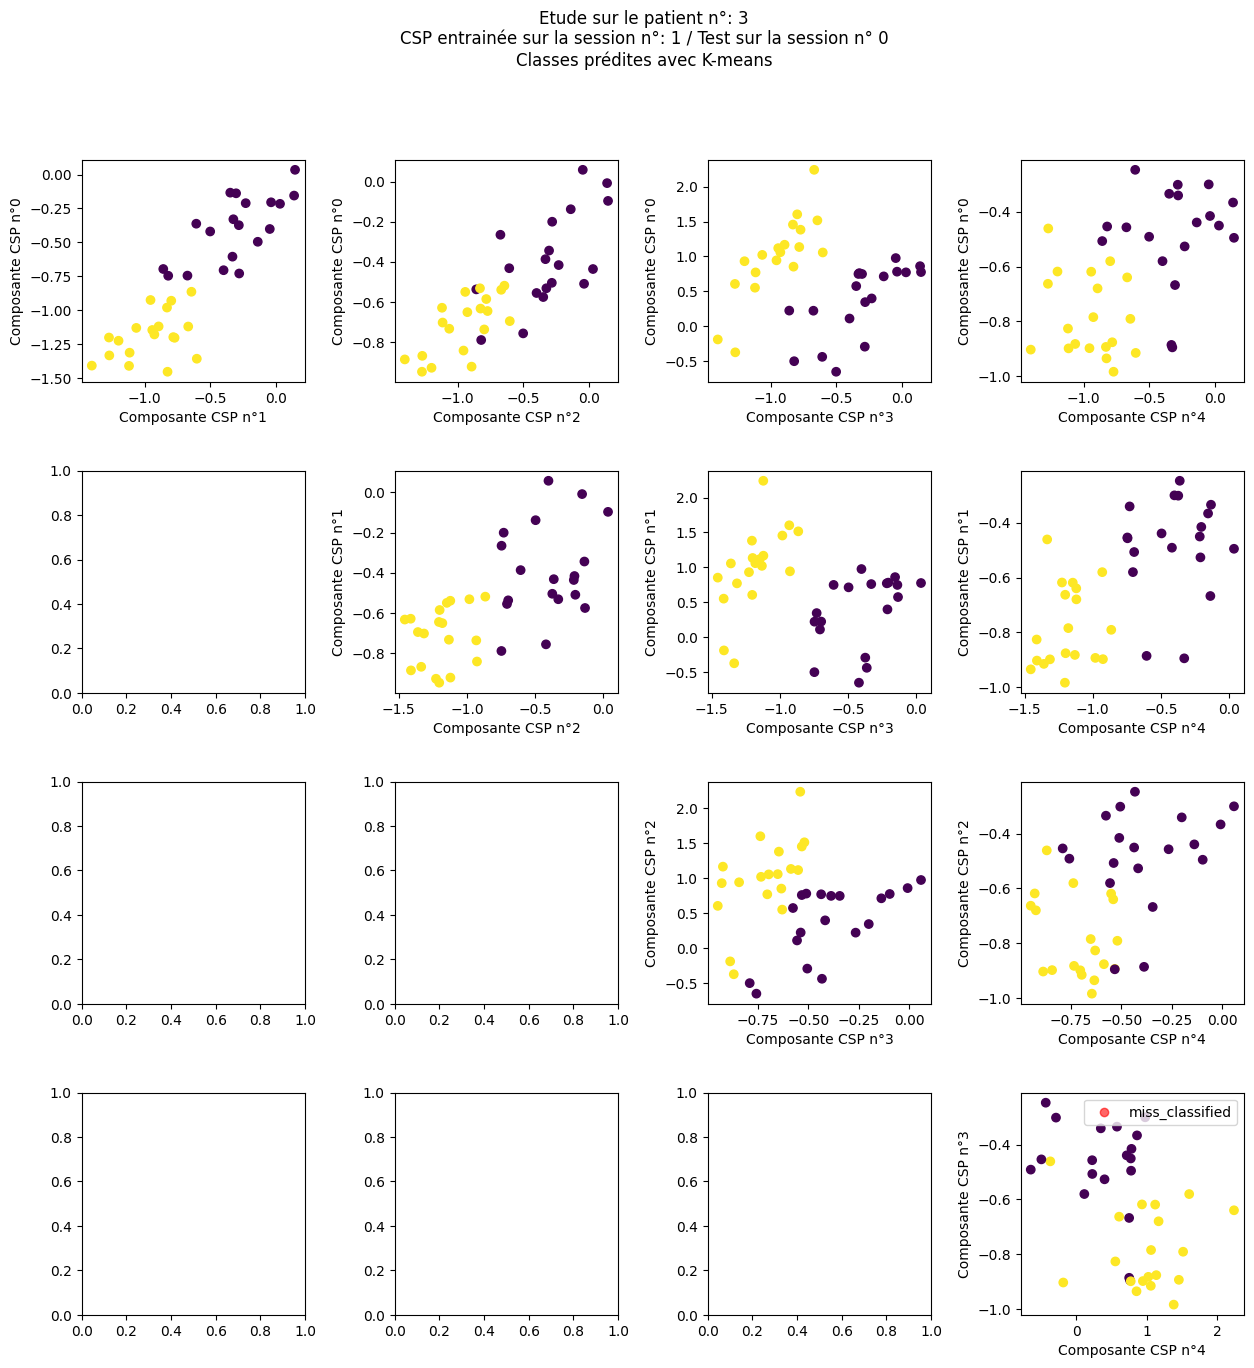

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from mne.decoding import CSP
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

nbr_patients = len(X_patients)
for i_patient_train in range(nbr_patients):
    print(f'Patient {i_patient}')

    
    nbr_sessions = len(X_patients[i_patient_train])
    if len(nbr_sessions < 2:
        print(f"  Abort, not enough sessions")
        continue 

    for i_session_train in range(nbr_sessions):
        X_patient = X_patients[i_patient][i_session].copy()
        y_patient = y_patients[i_patient][i_session].copy()

        i_session_test = (1+i_session)%2
        X_test = X_patients[i_patient][i_session_test].copy()
        y_test = y_patients[i_patient][i_session_test].copy()

        csp = CSP(n_components=5)
        sc  = StandardScaler()
        km = KMeans(n_clusters=2)
        svc = SVC(kernel='linear', C=.001)
        
        # rf  = RandomForestClassifier()
        # pip = Pipeline([('CSP', csp), ('sc', sc), ('SVC', svc)])
        pip = Pipeline([('CSP', csp), ('sc', sc), ('Kmeans', km)])

        pip.fit(X_patient, y_patient)
        # score = pip.score(X_test, y_test)

       
        y_pred = pip.predict(X_test)
        score = accuracy_score(y_test,y_pred)

        csp_data = pip.named_steps["CSP"].transform(X_test)

        # we just want to separate both classes without taking into consideration if the name of the label is right or not
        if score < 0.5:
            score = 1 - score 
            y_pred = 1 - y_pred

        miss_classification = np.abs(y_pred - y_test) > 0.5 # 

        plot_csp(csp_data, y_test)
        plt.suptitle(f"Etude sur le patient n°: {i_patient}\n" +
                     f"CSP entrainée sur la session n°: {i_session} / Test sur la session n° {i_session_test}\n" +
                     "Vraies classes")
        
        plot_csp(csp_data, y_pred,miss_classification)
        plt.scatter
        plt.suptitle(f"Etude sur le patient n°: {i_patient}\n" +
                     f"CSP entrainée sur la session n°: {i_session} / Test sur la session n° {i_session_test}\n" +
                     "Classes prédites avec K-means")
        
       
        print(f'  Train on session n°: {i_session} - Score: {score : .3f} on session n °: {i_session_test}')

# 4 - 2ème Cas d'utilisation de KMEANS: Patient et session aléatoire pour le test

En raison de la variation très forte des signaux EEG entre les patients, dans certains cas la classification est inefficace car les données varient trop dans l'espace des features.

Patient 0


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 0 and session n°: 0 - Score:  0.763 
 Test on patient n°: 4 and session n °: 0


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 0 and session n°: 1 - Score:  0.947 
 Test on patient n°: 0 and session n °: 0
Patient 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 1 and session n°: 0 - Score:  0.526 
 Test on patient n°: 0 and session n °: 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 1 and session n°: 1 - Score:  0.500 
 Test on patient n°: 3 and session n °: 0
Patient 2


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 2 and session n°: 0 - Score:  0.571 
 Test on patient n°: 2 and session n °: 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 2 and session n°: 1 - Score:  0.500 
 Test on patient n°: 4 and session n °: 0
Patient 3


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 3 and session n°: 0 - Score:  0.500 
 Test on patient n°: 0 and session n °: 1


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 3 and session n°: 1 - Score:  0.974 
 Test on patient n°: 3 and session n °: 1
Patient 4


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists w

  Train on patient n°: 4 and session n°: 0 - Score:  0.632 
 Test on patient n°: 4 and session n °: 0


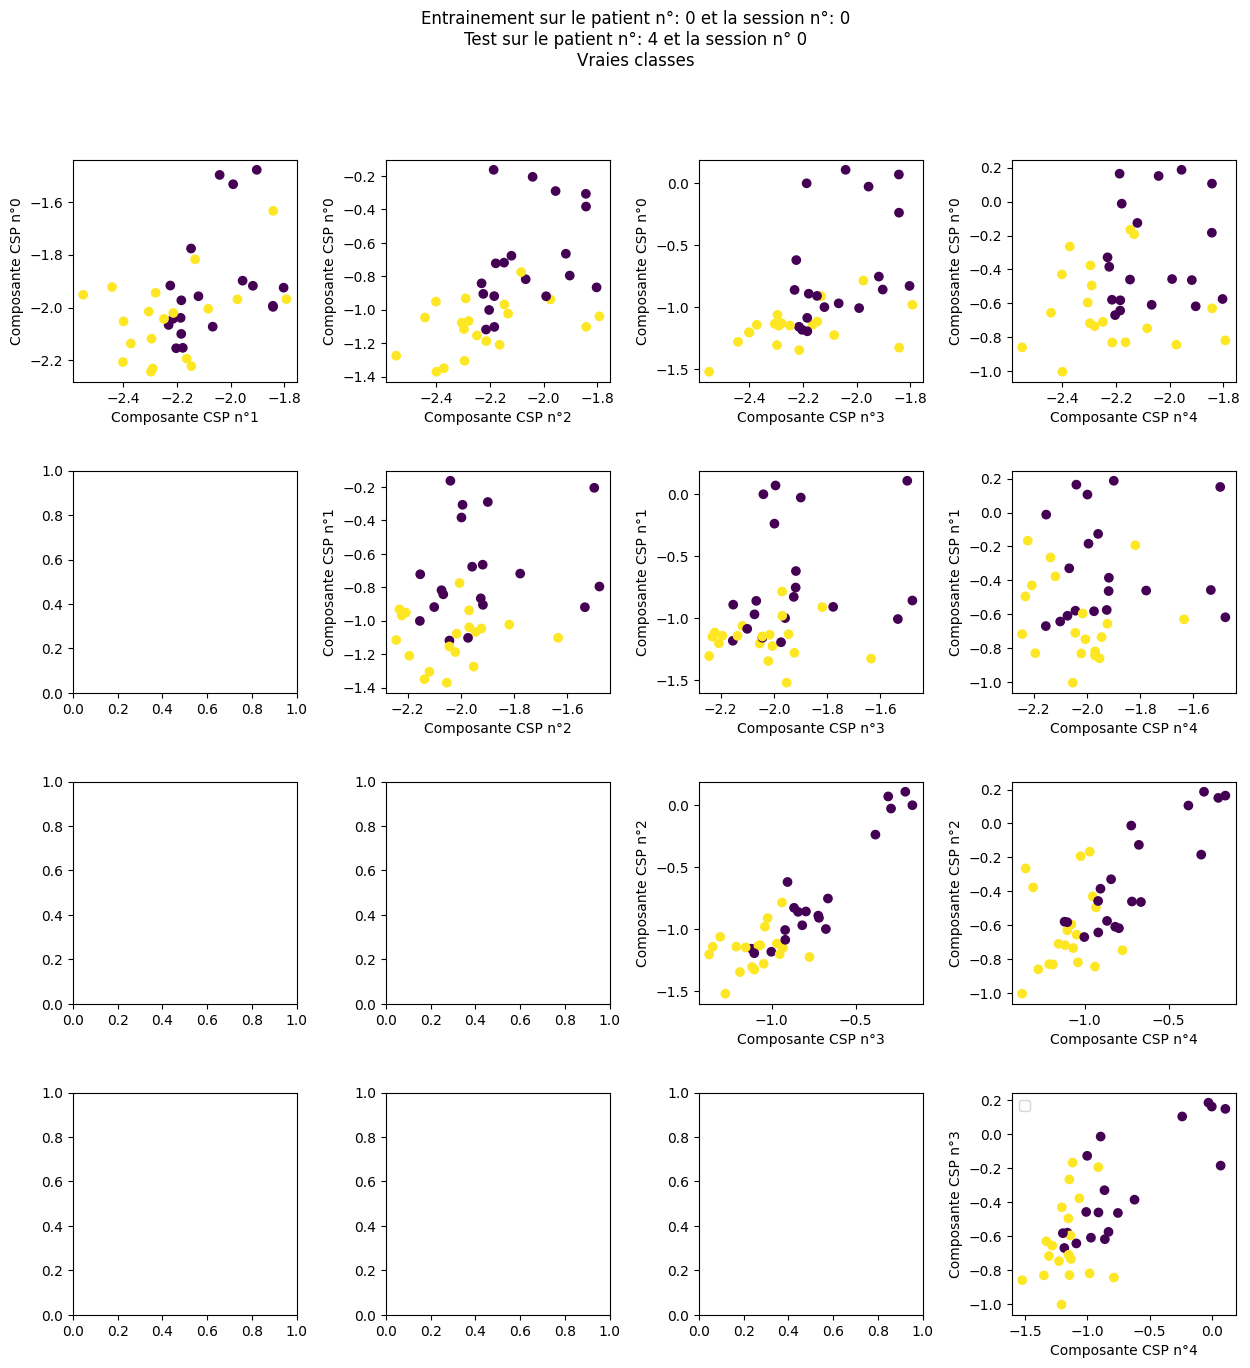

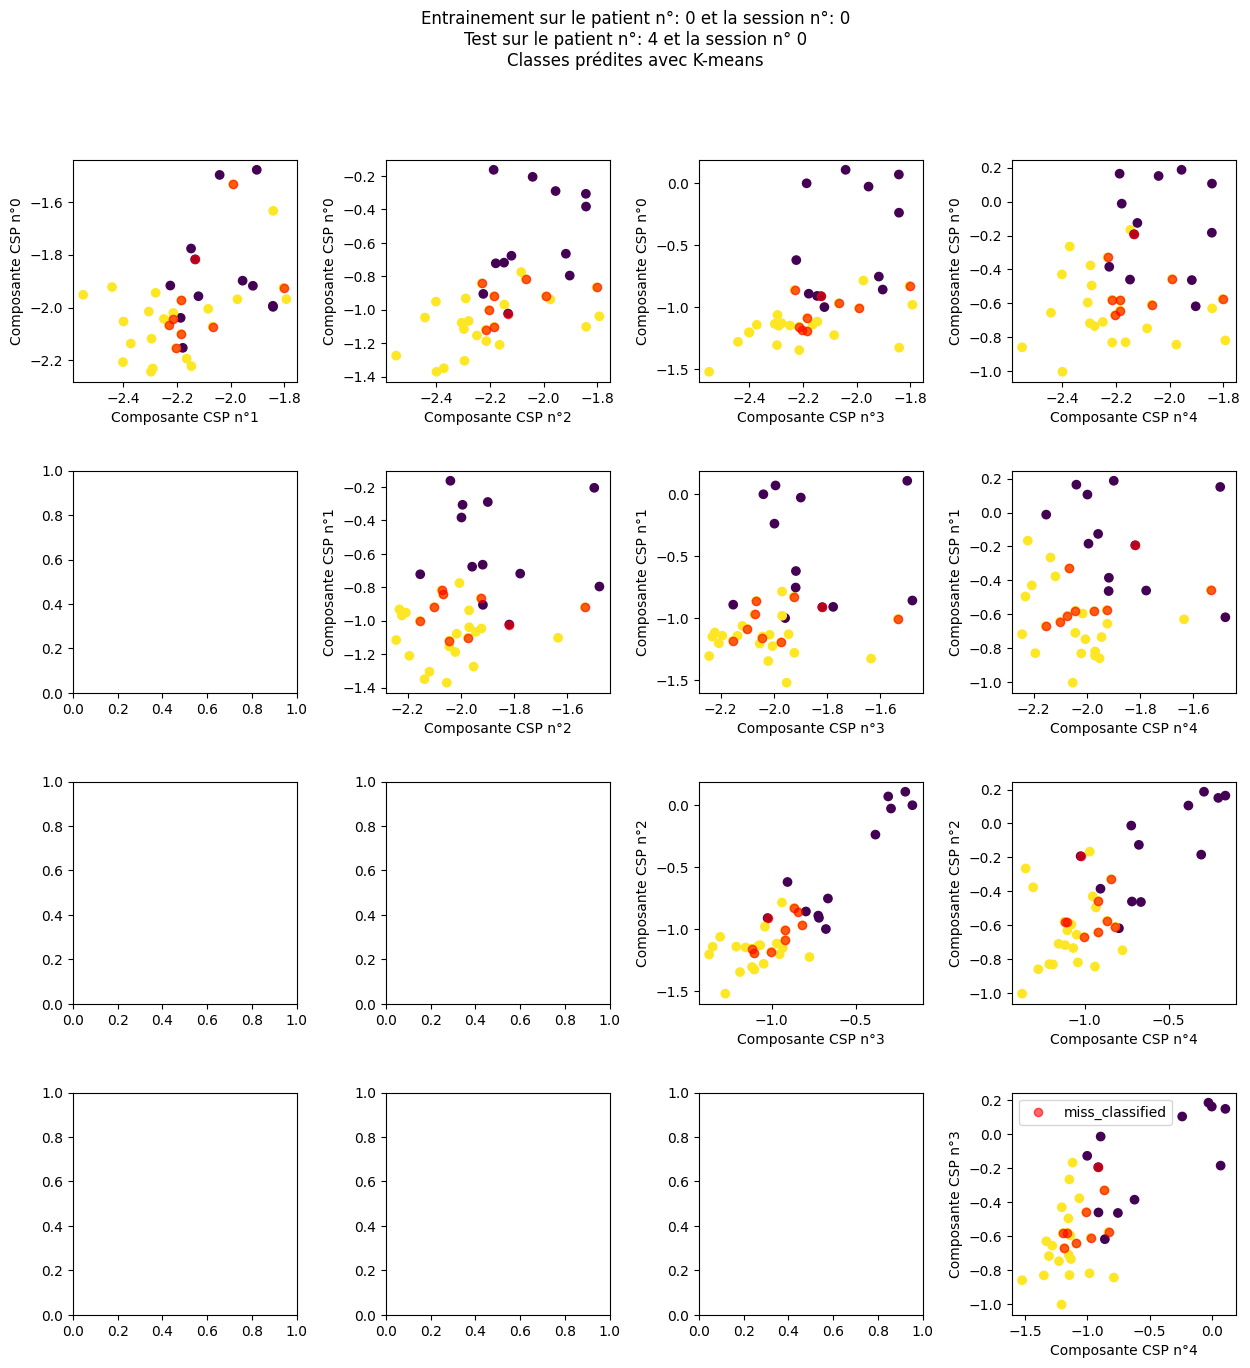

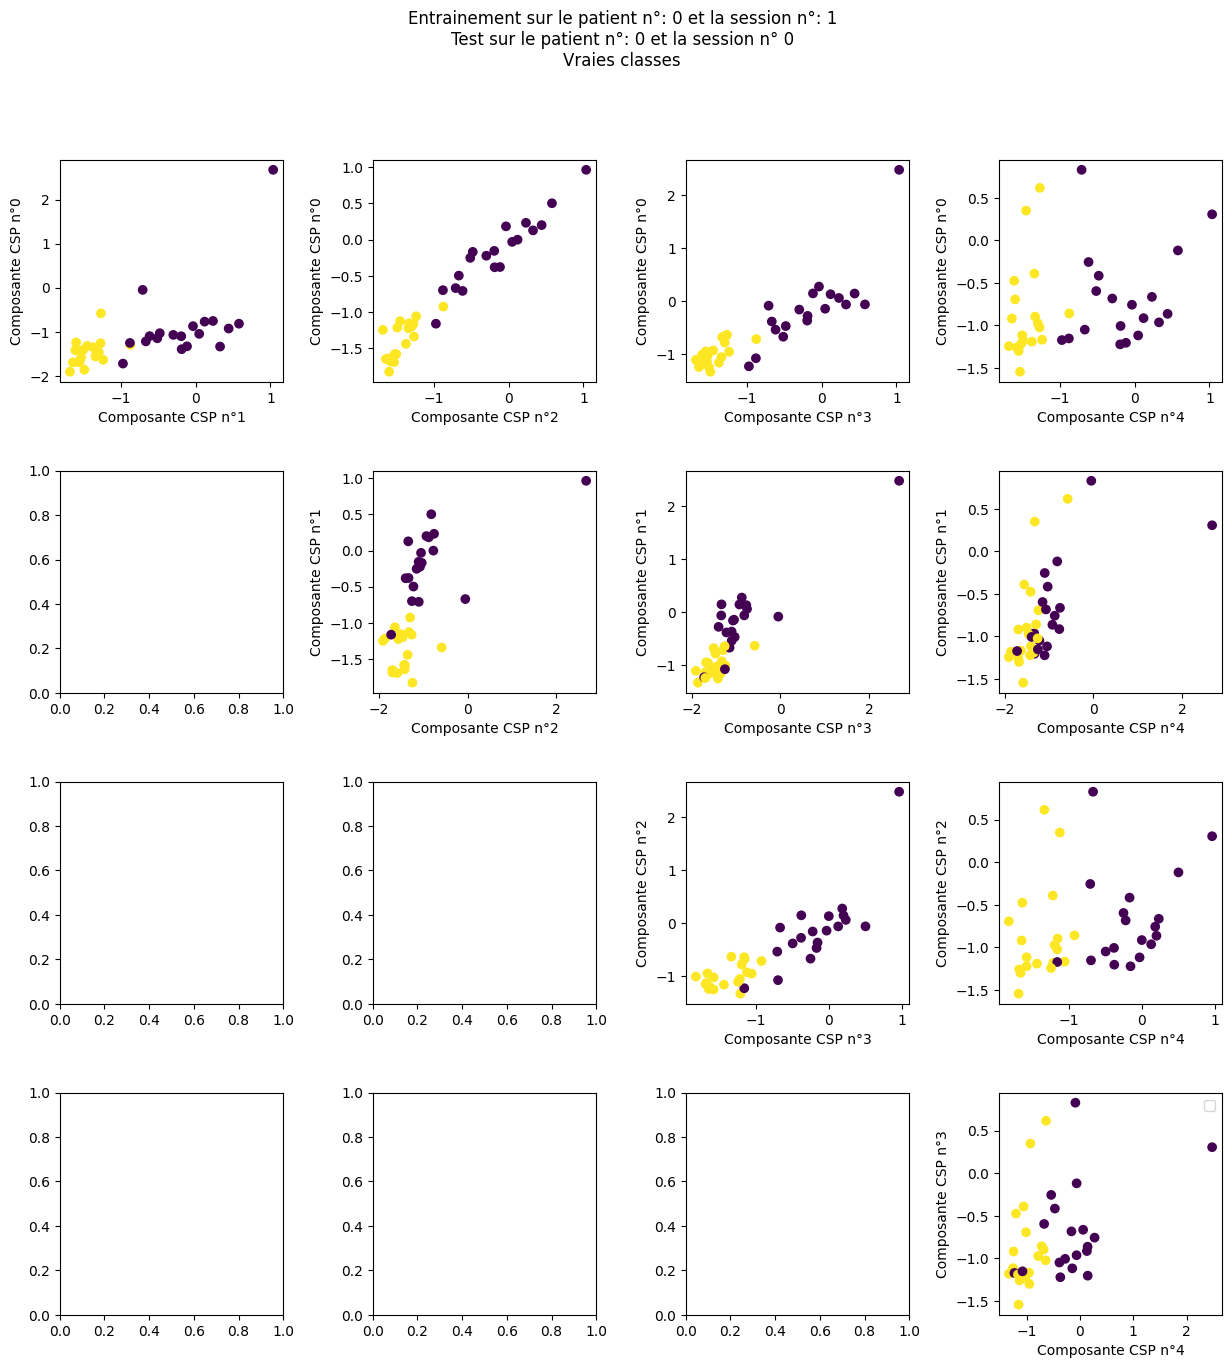

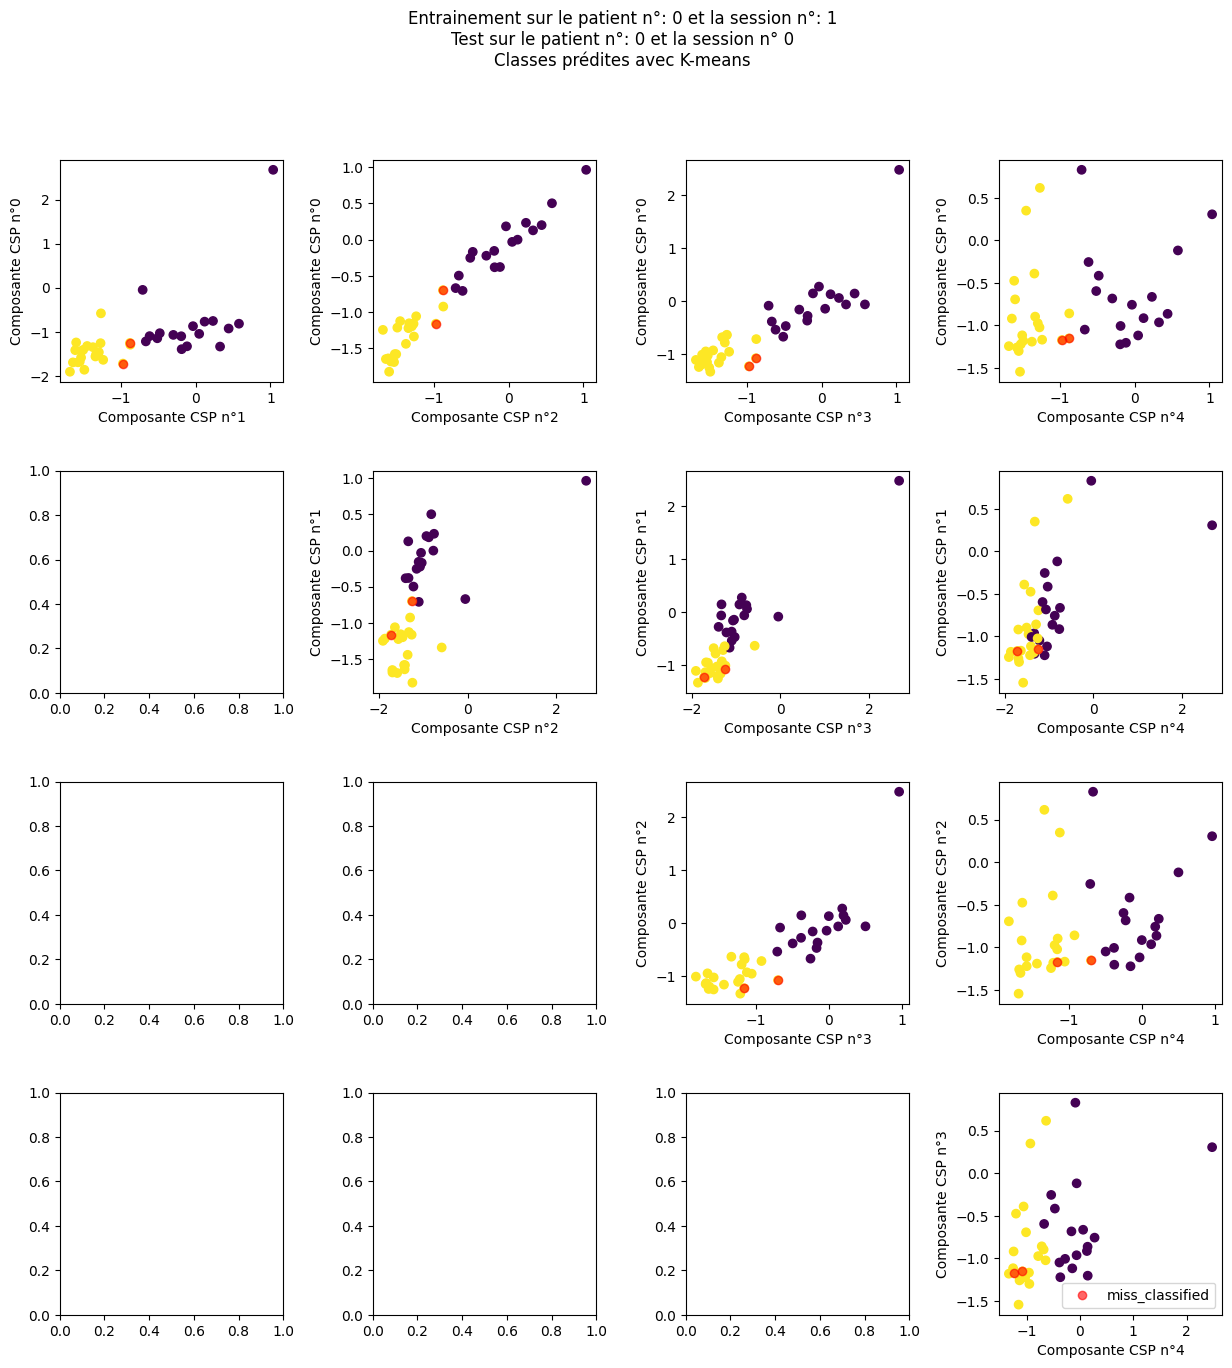

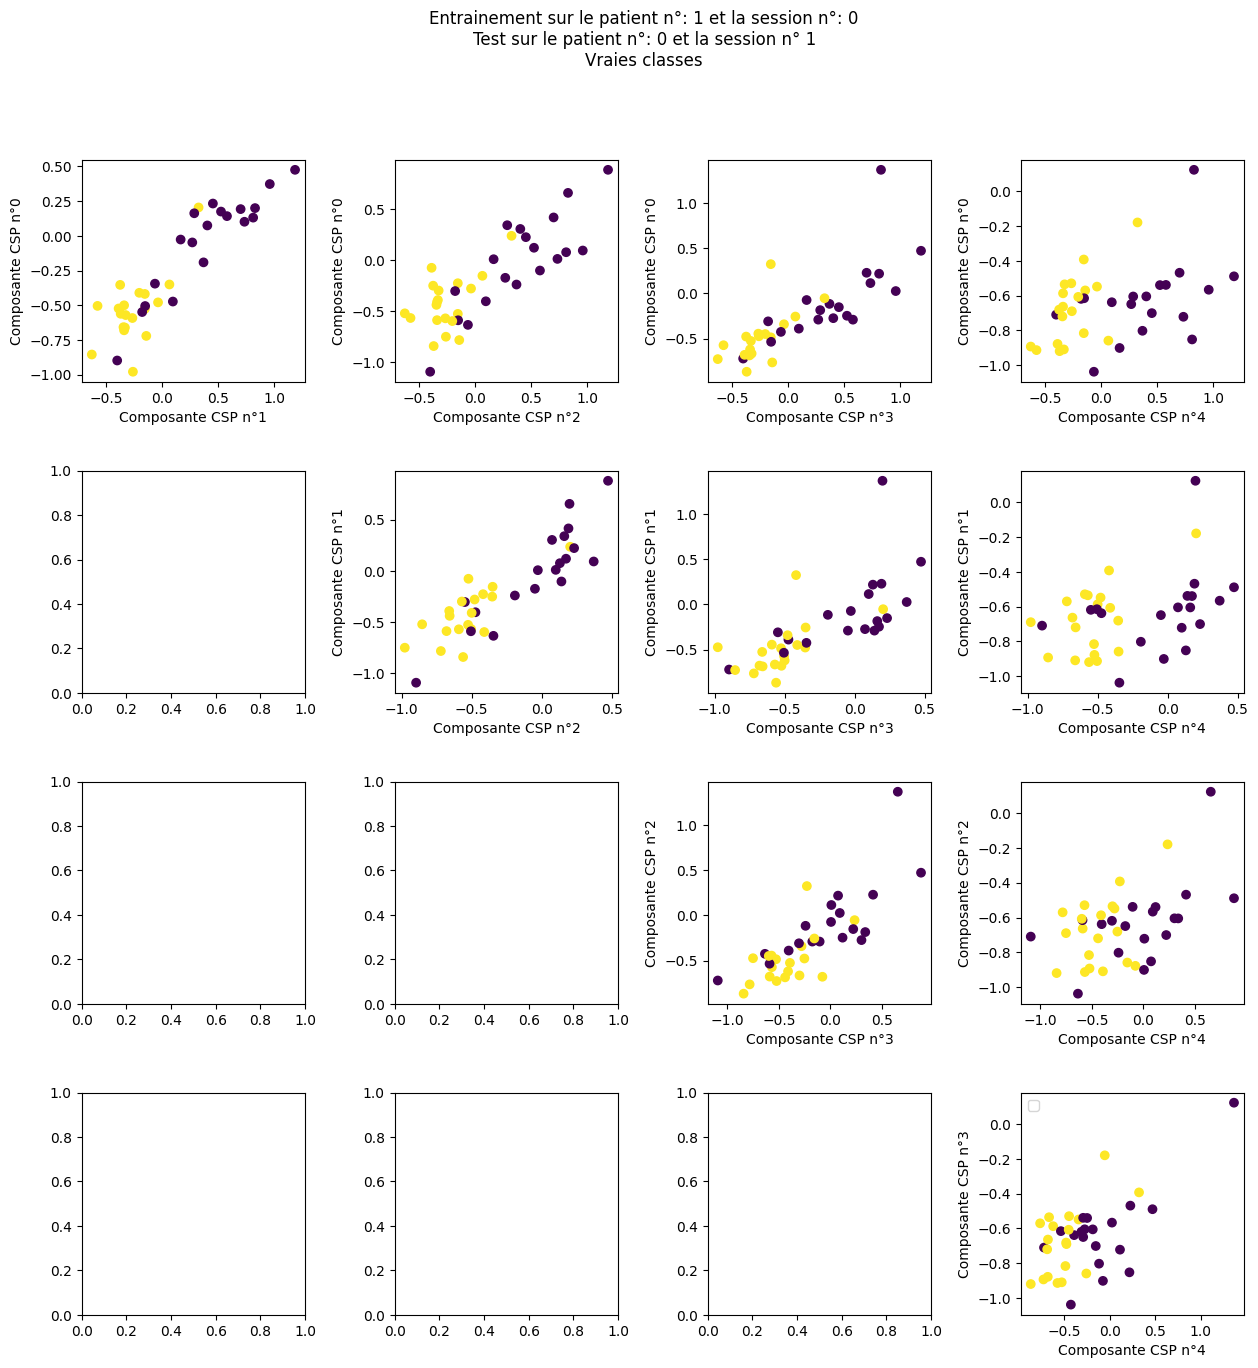

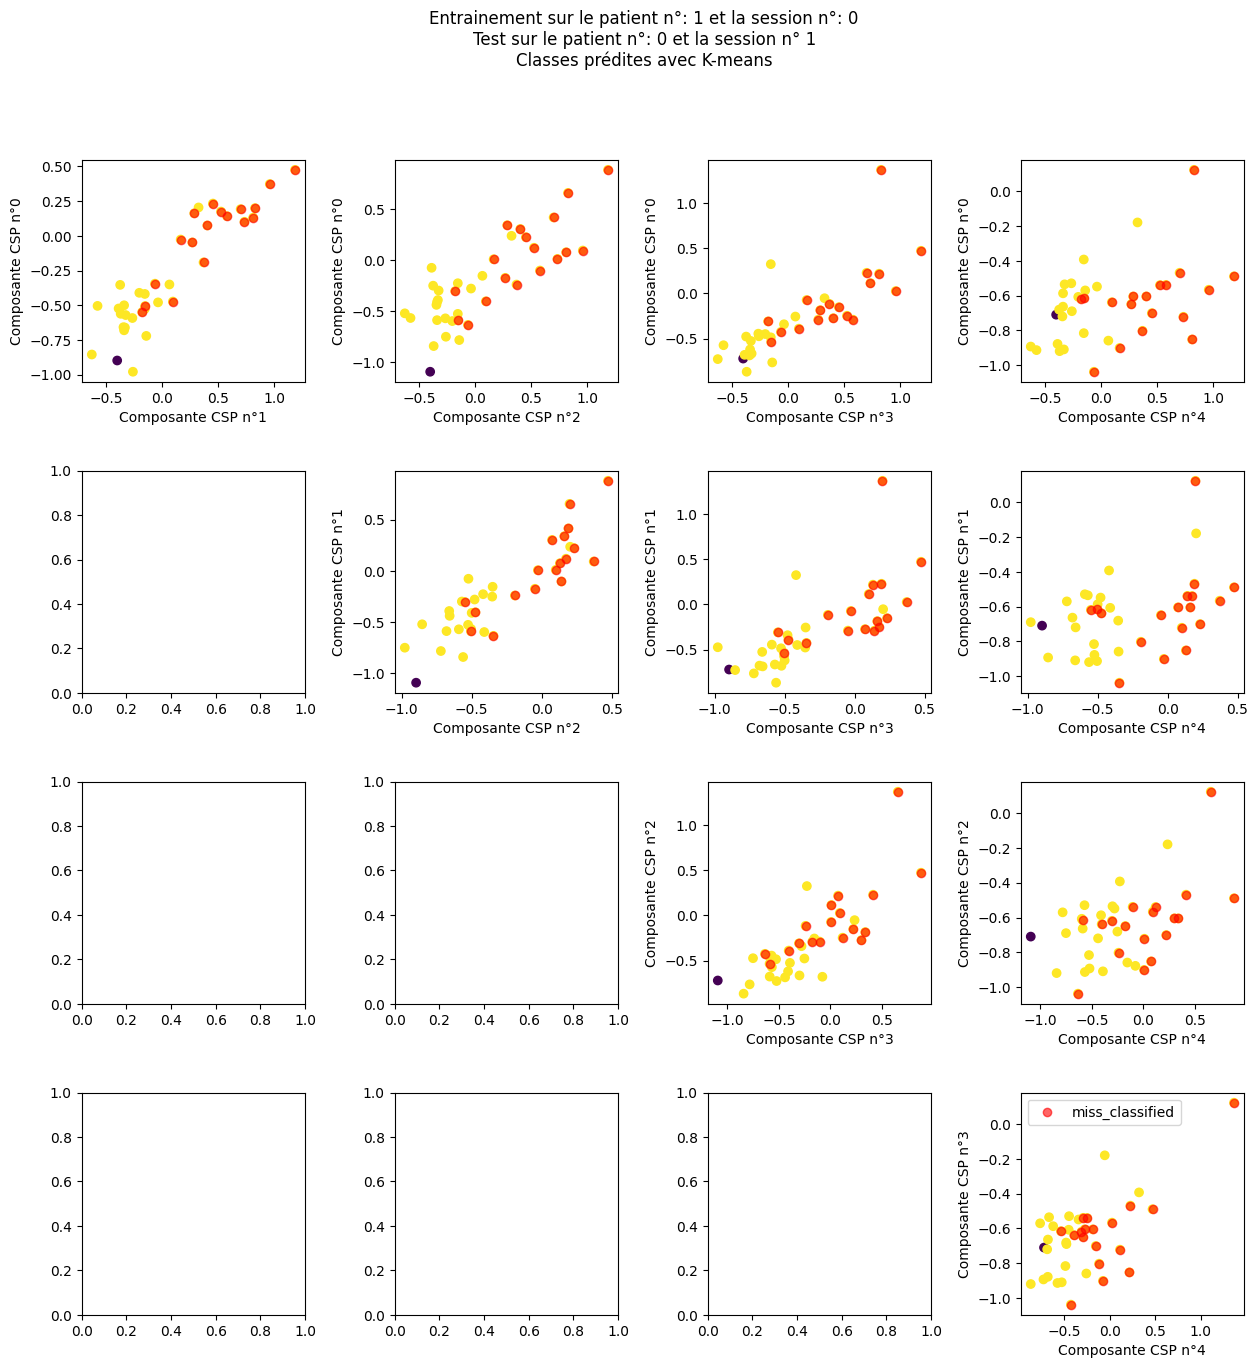

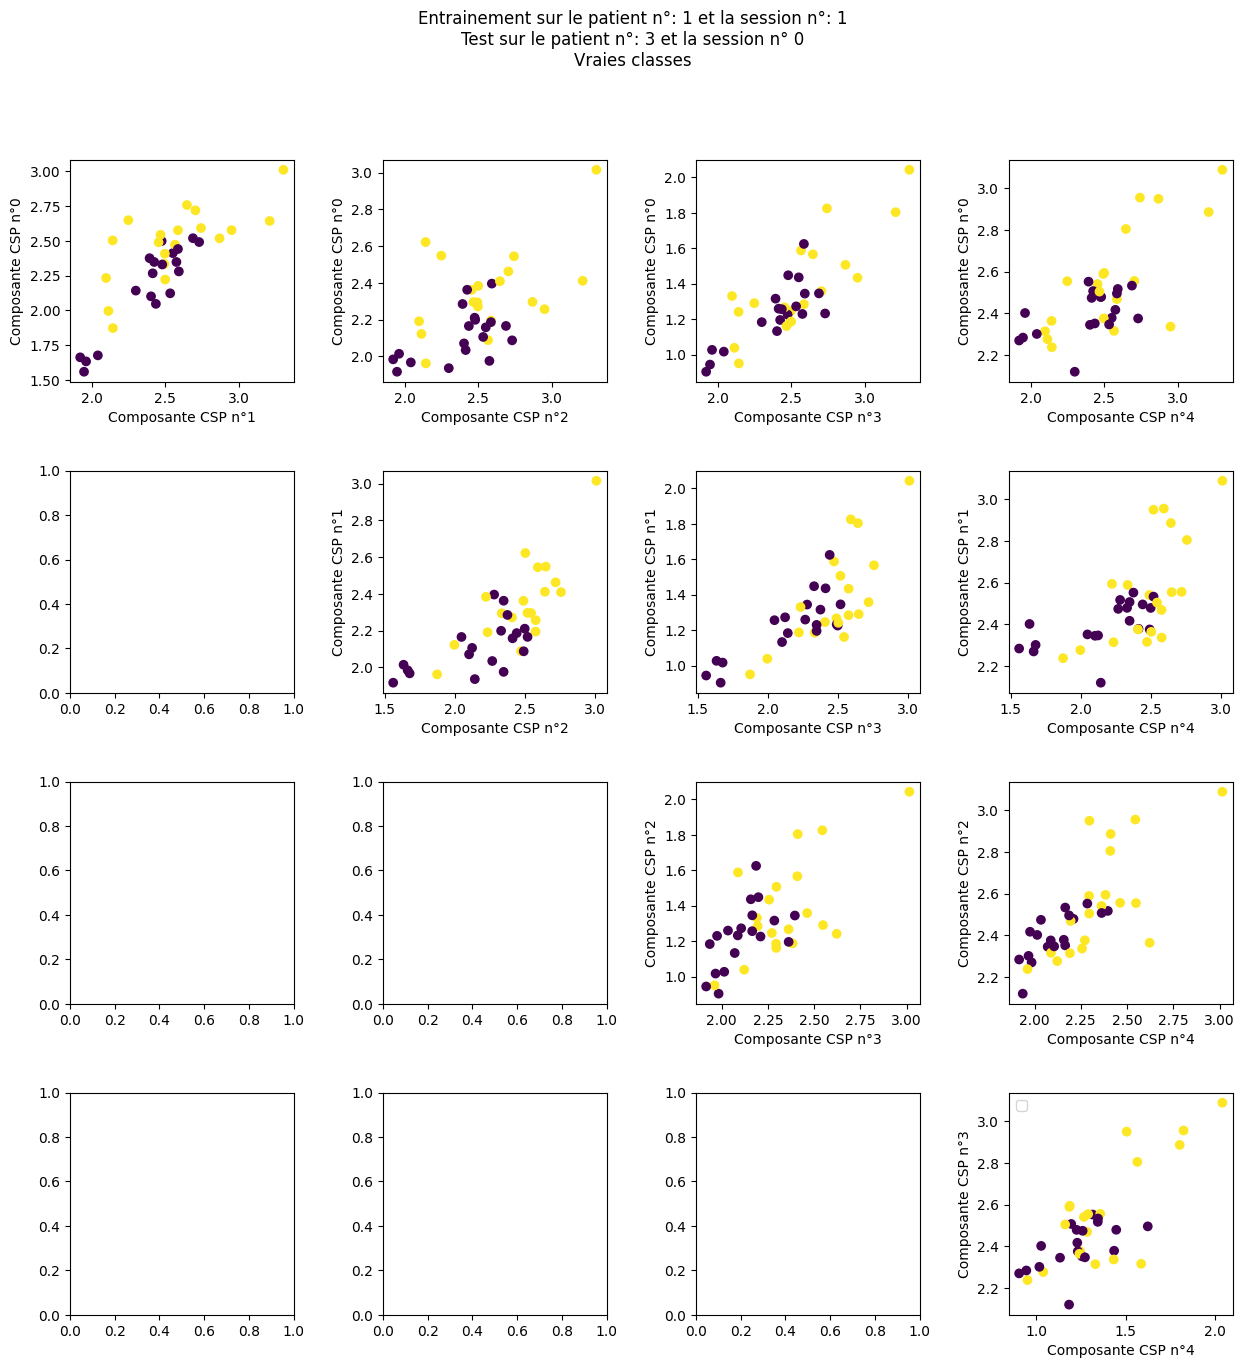

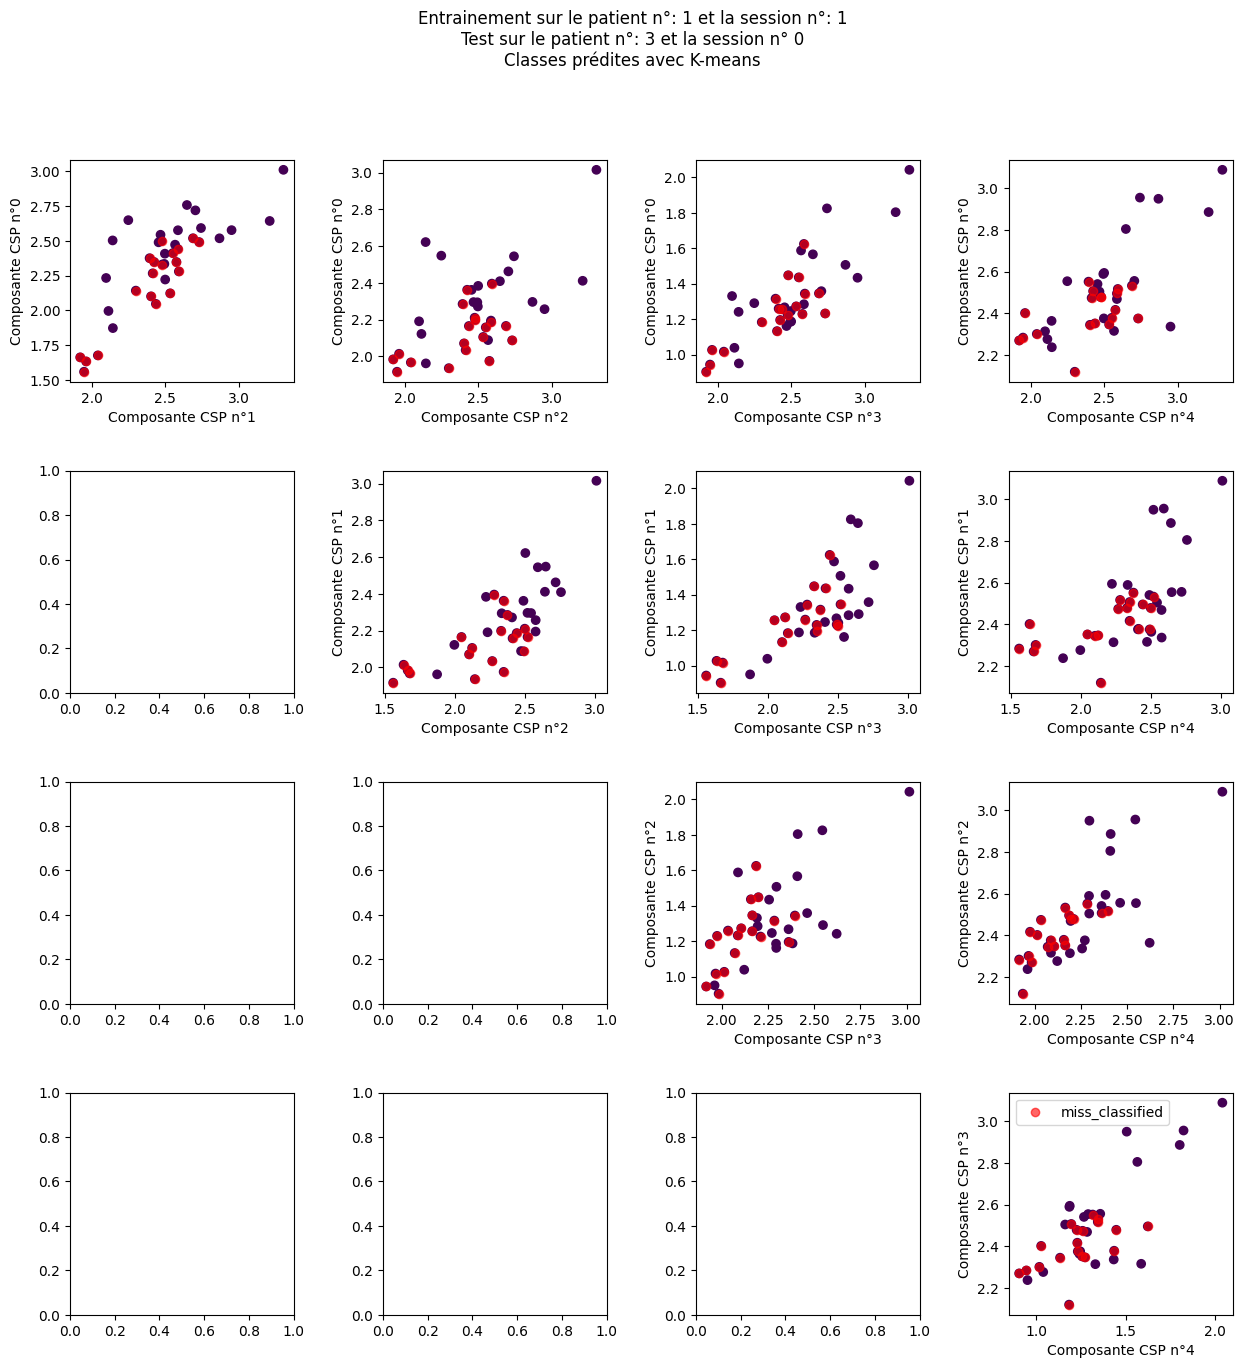

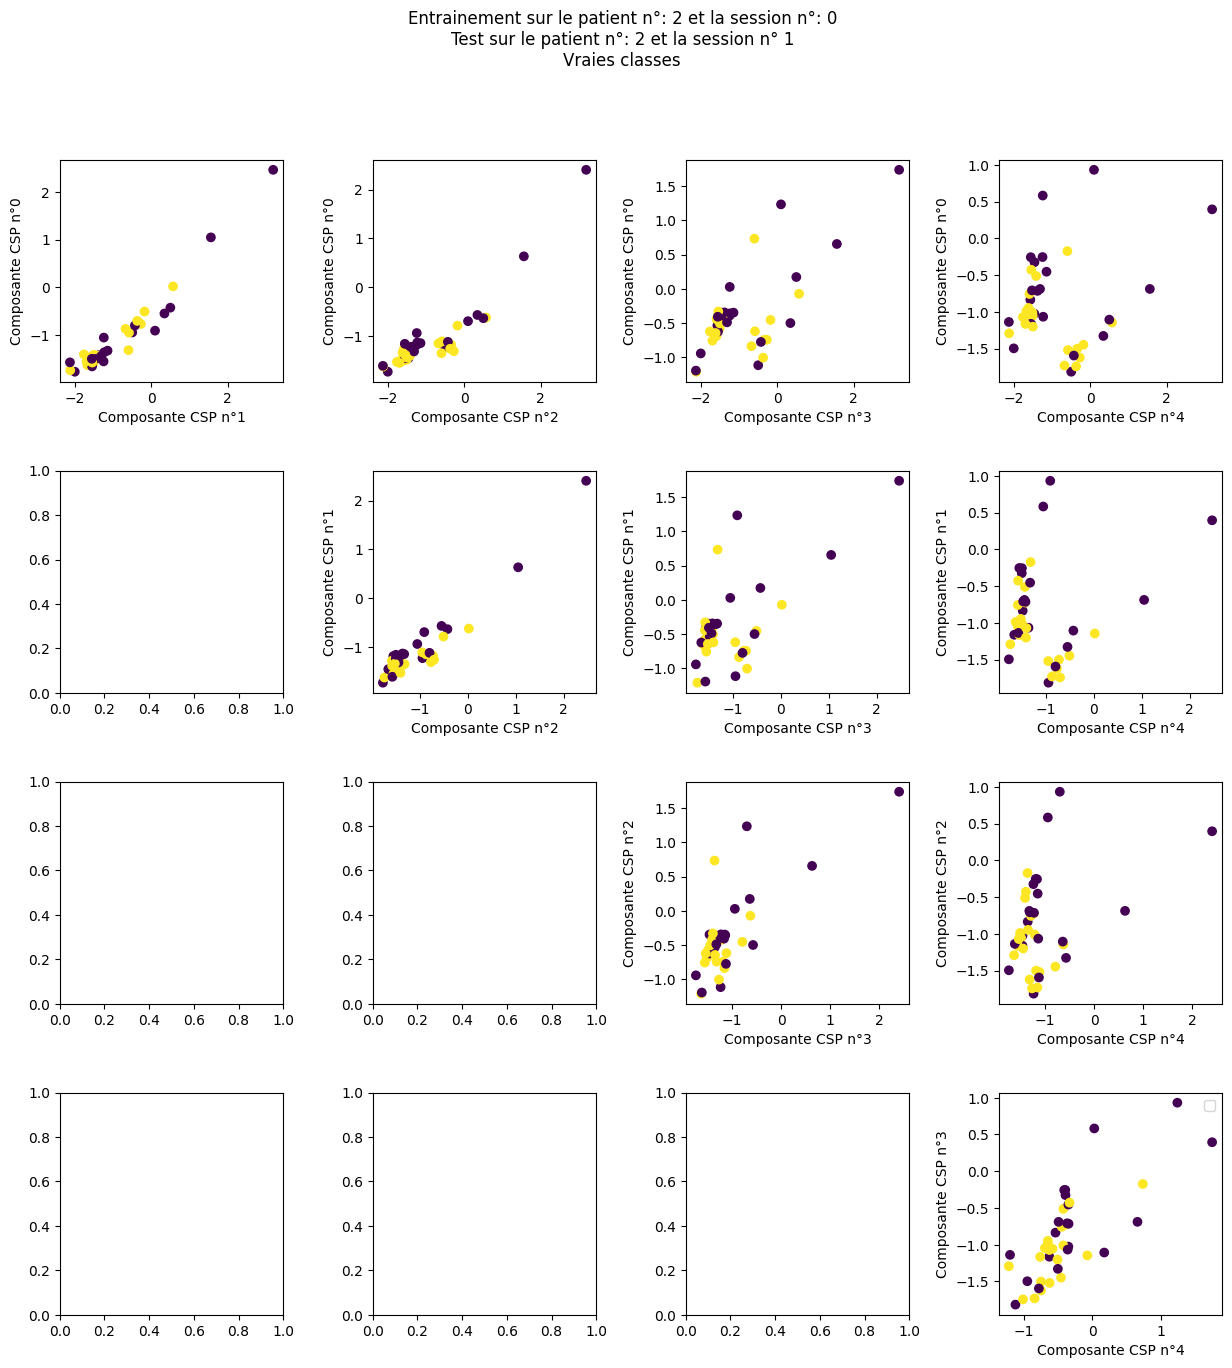

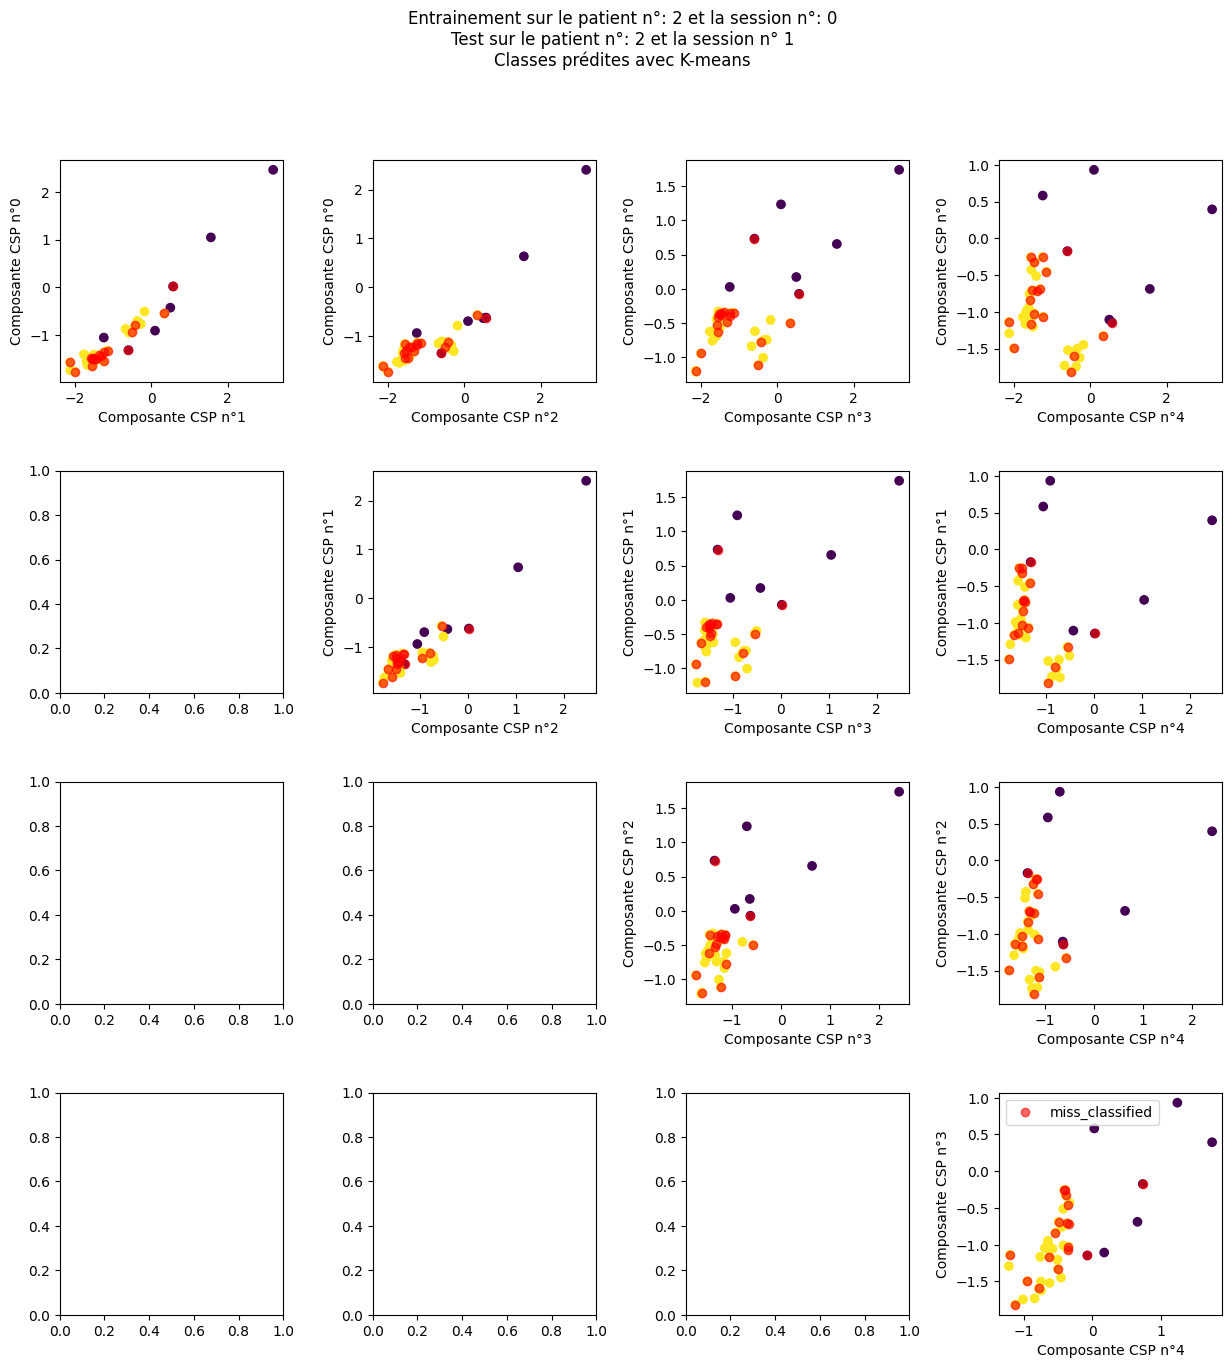

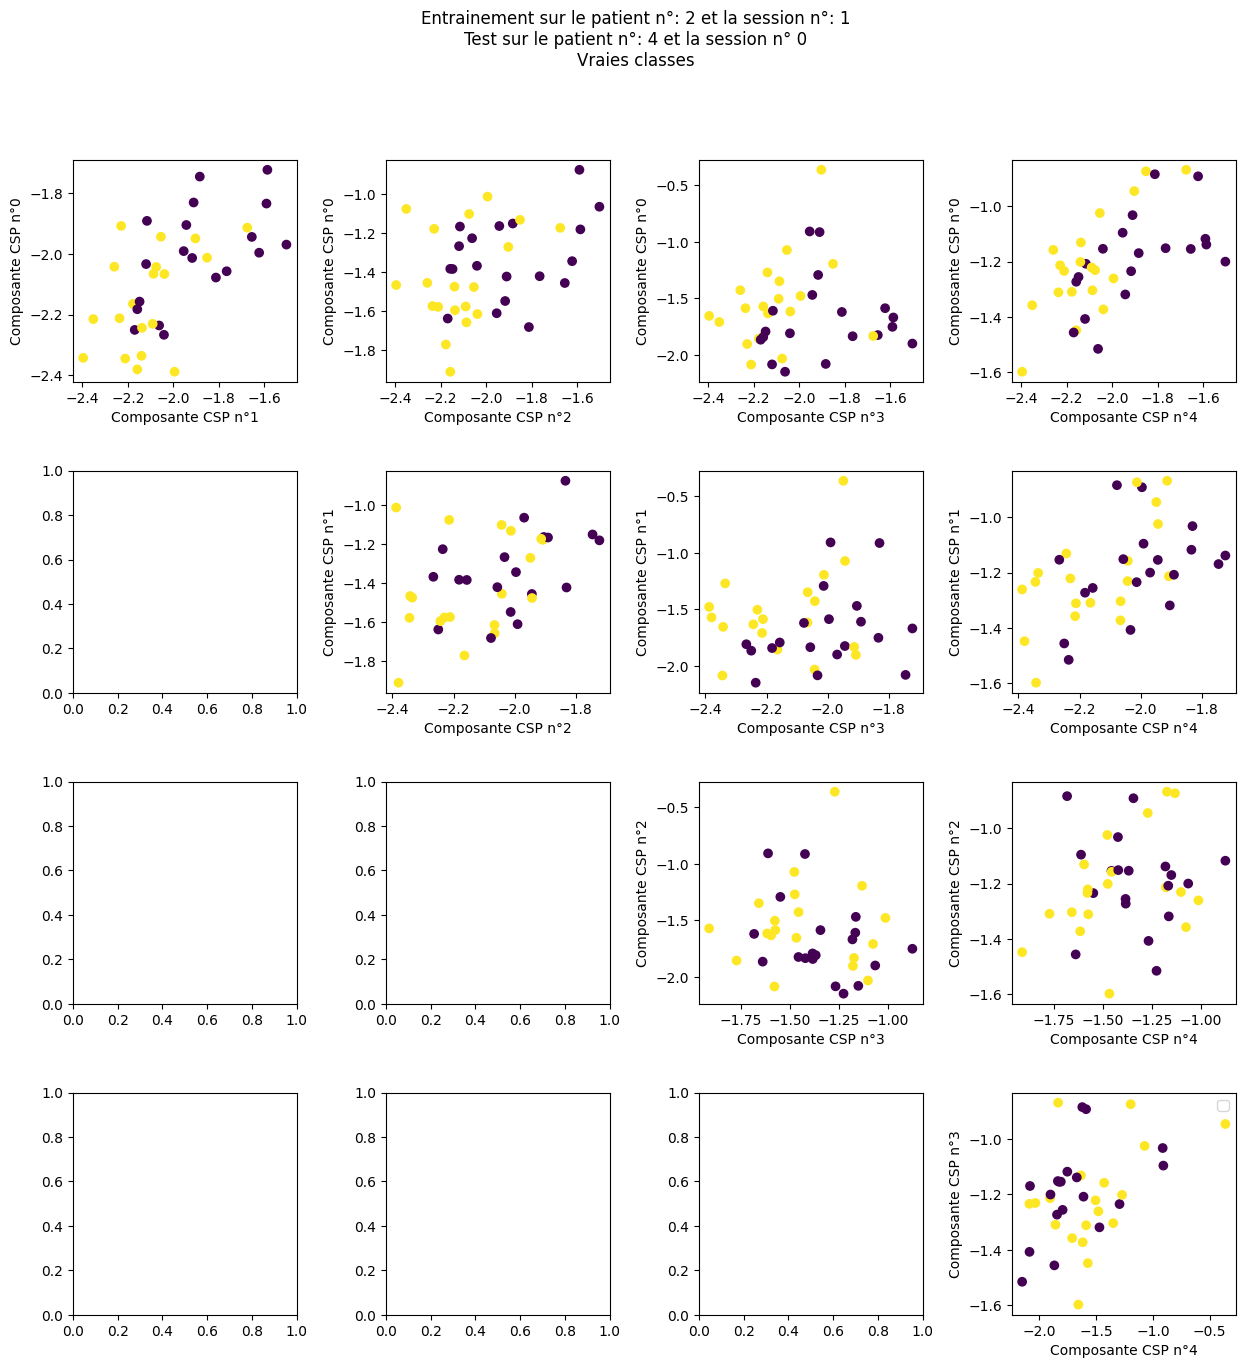

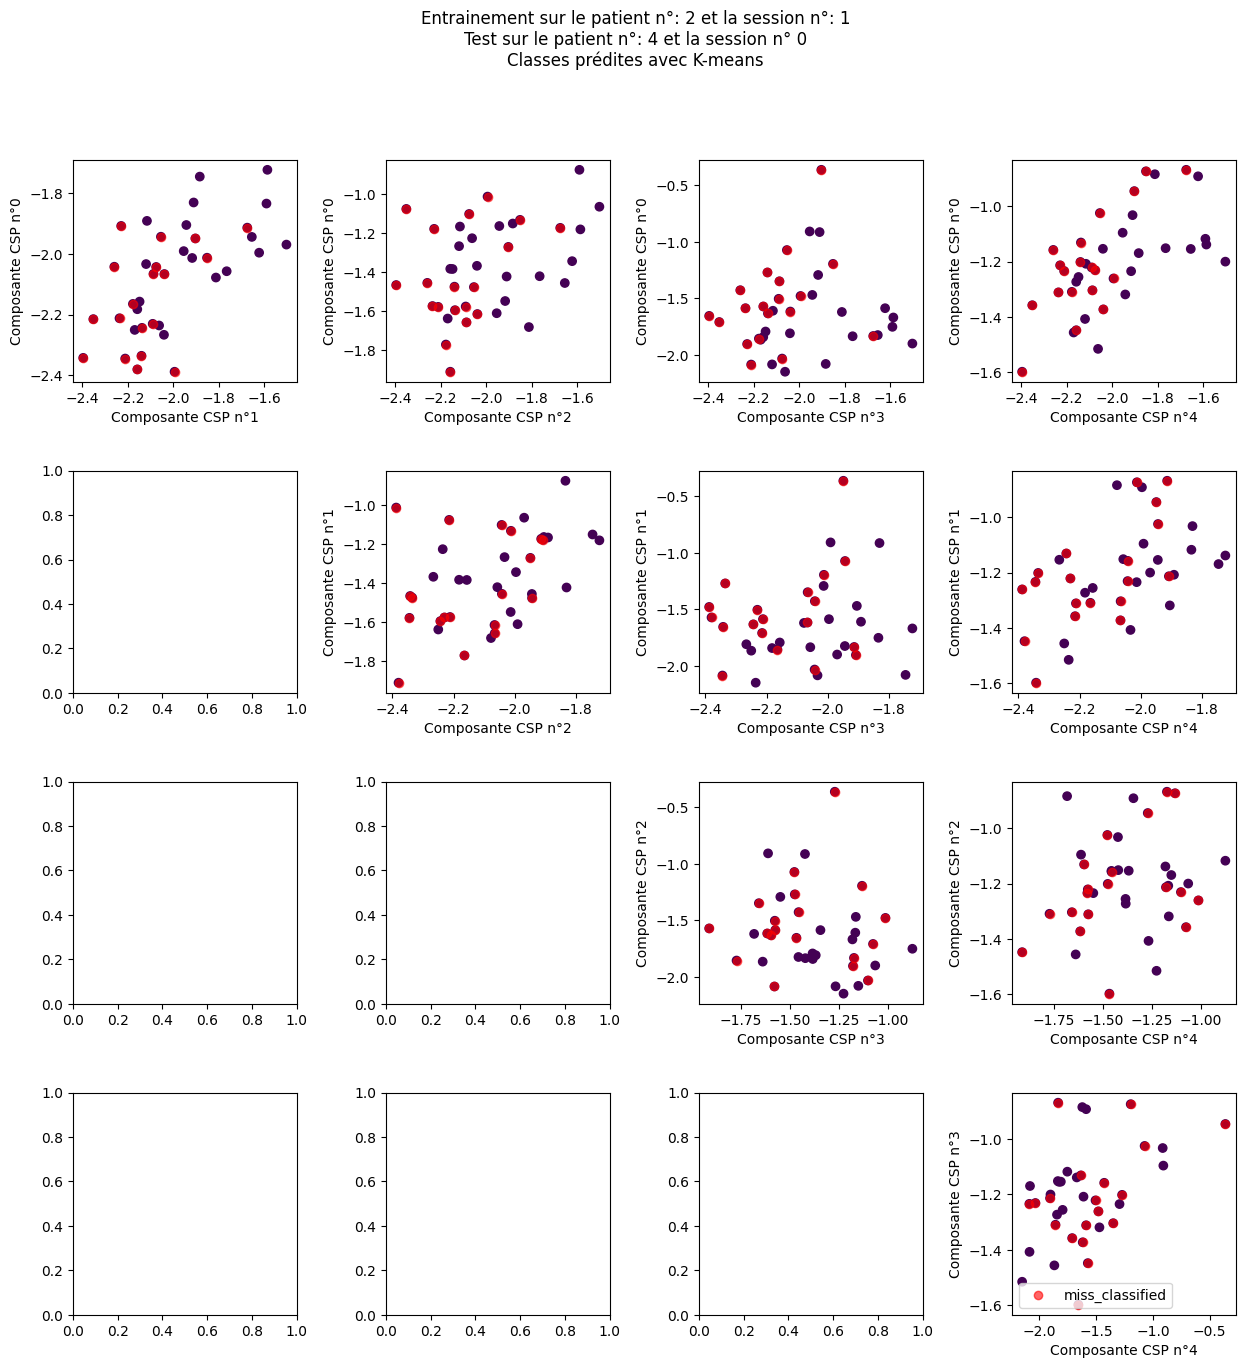

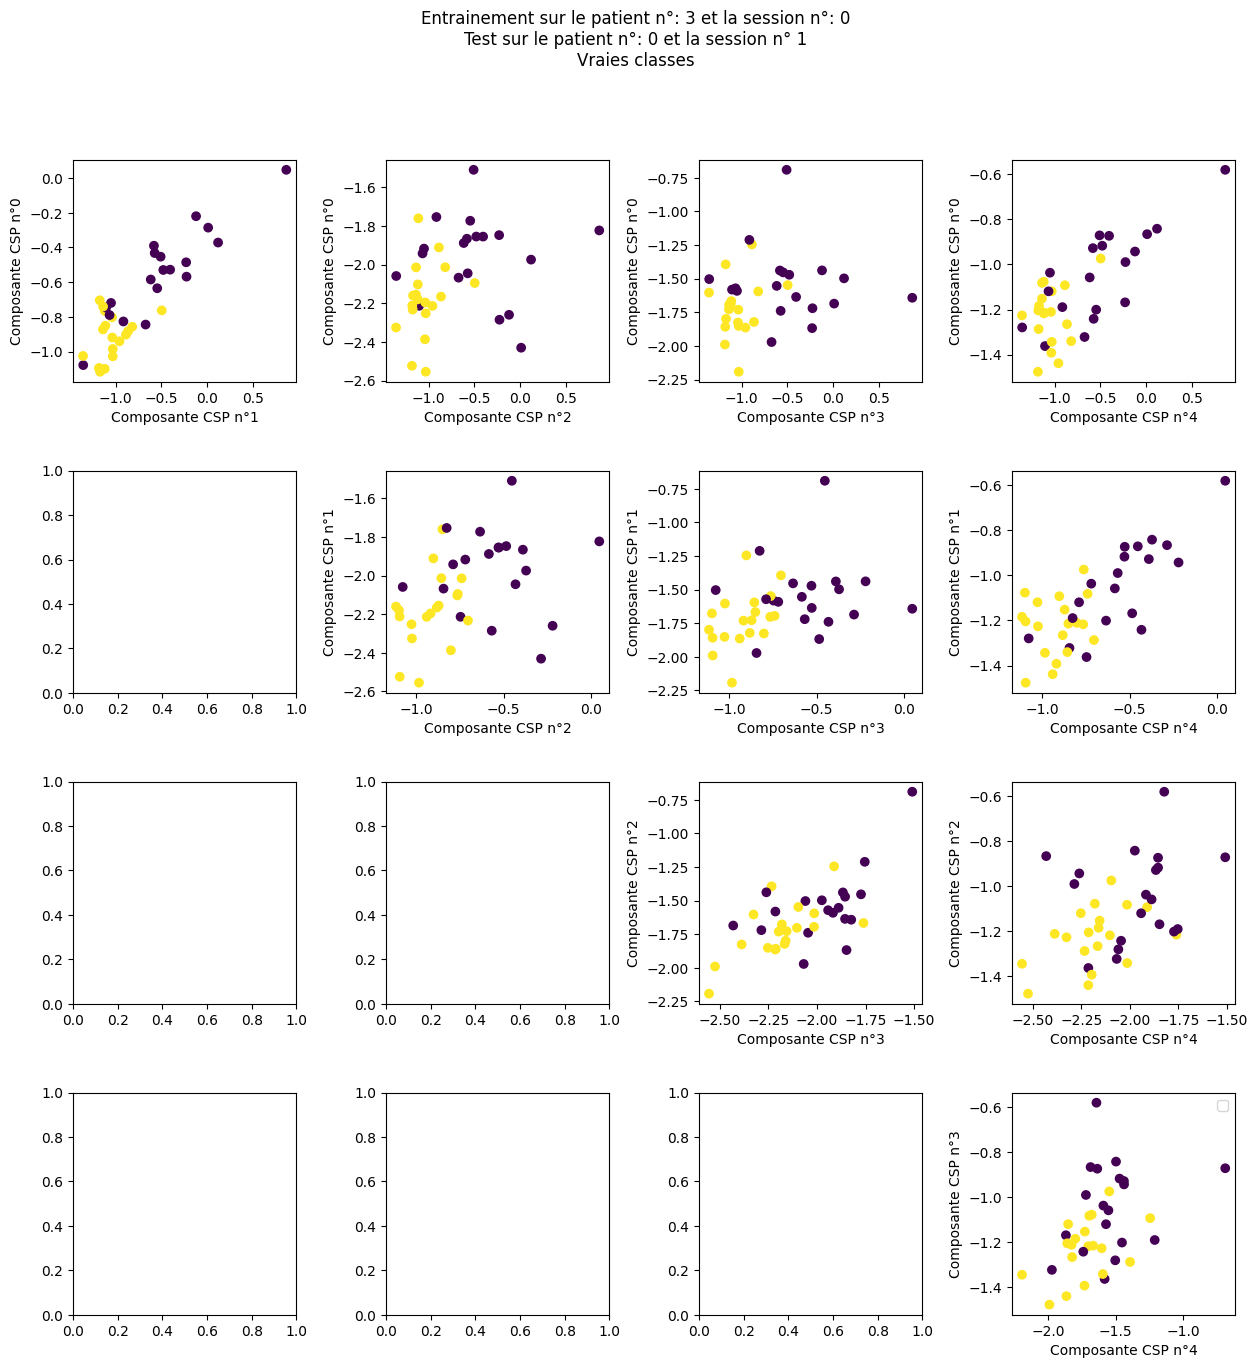

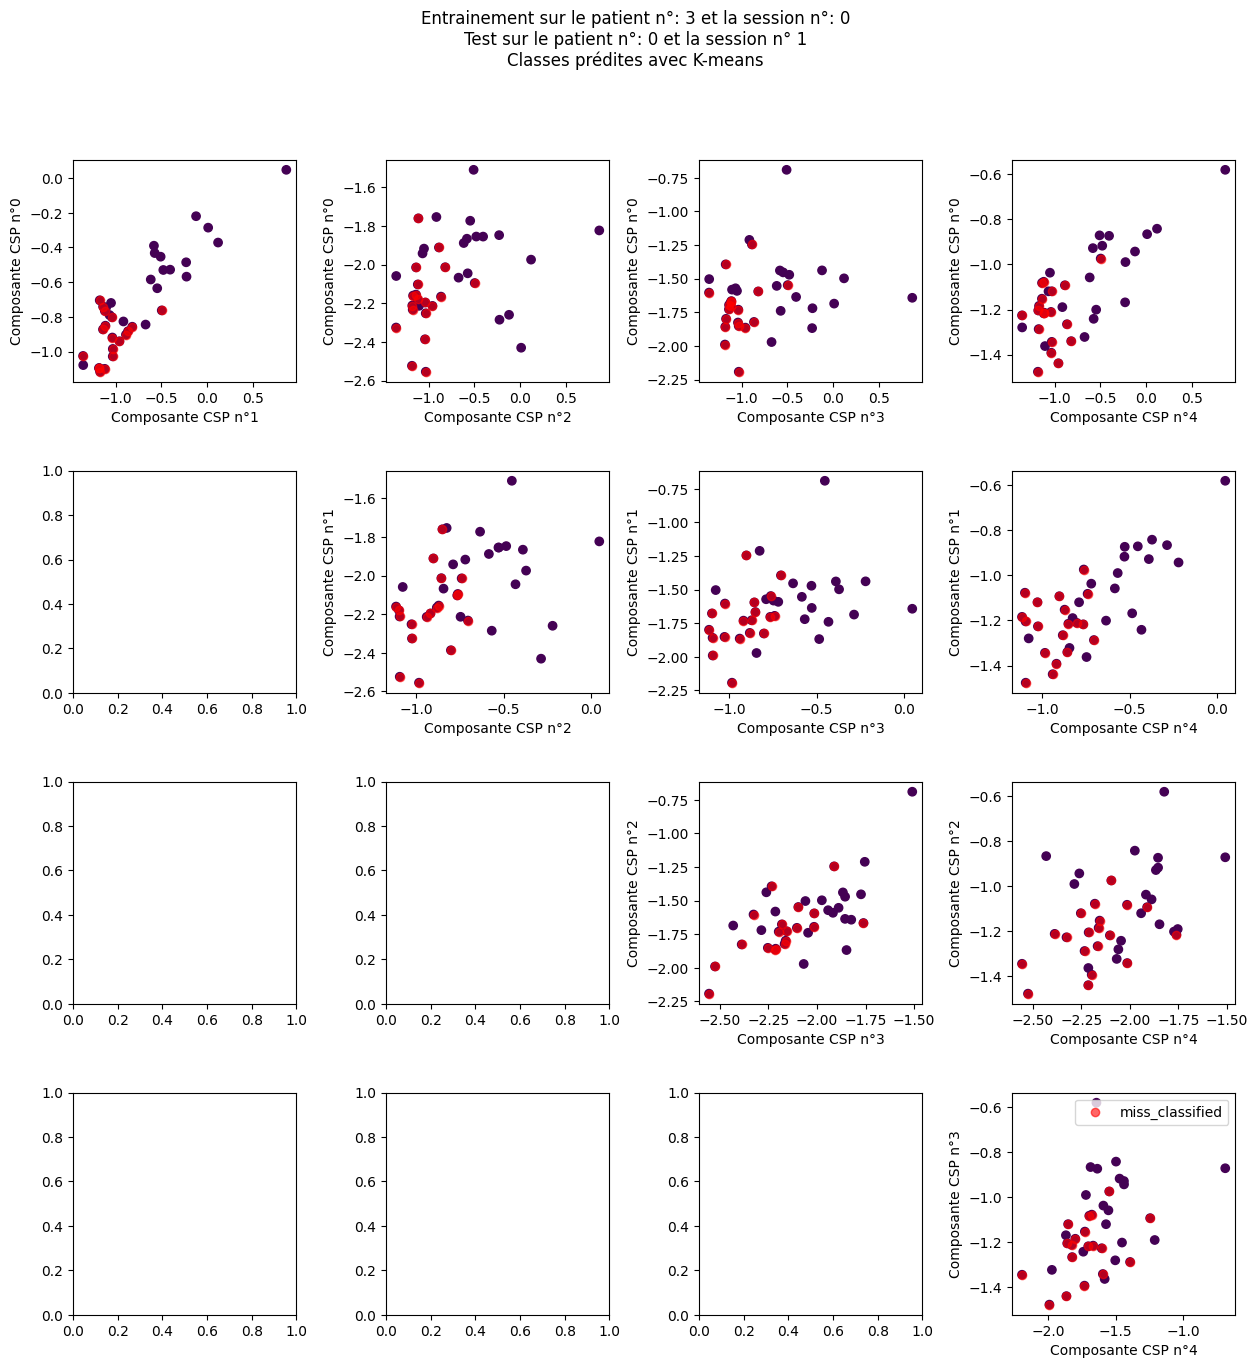

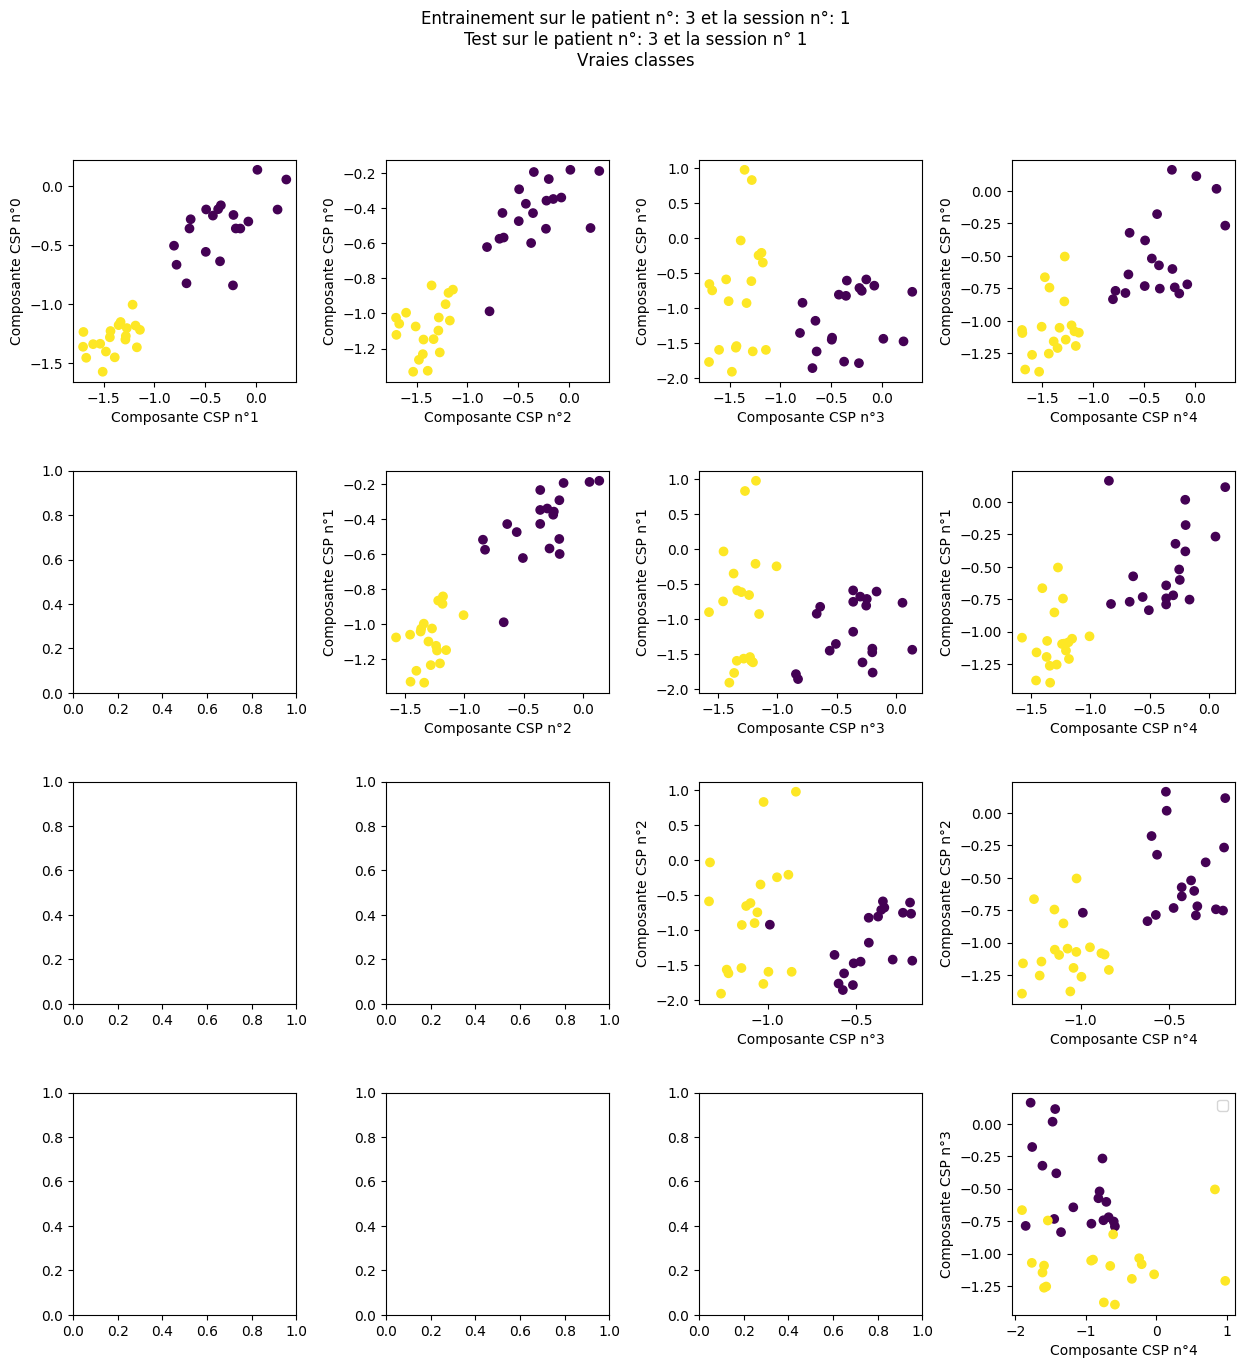

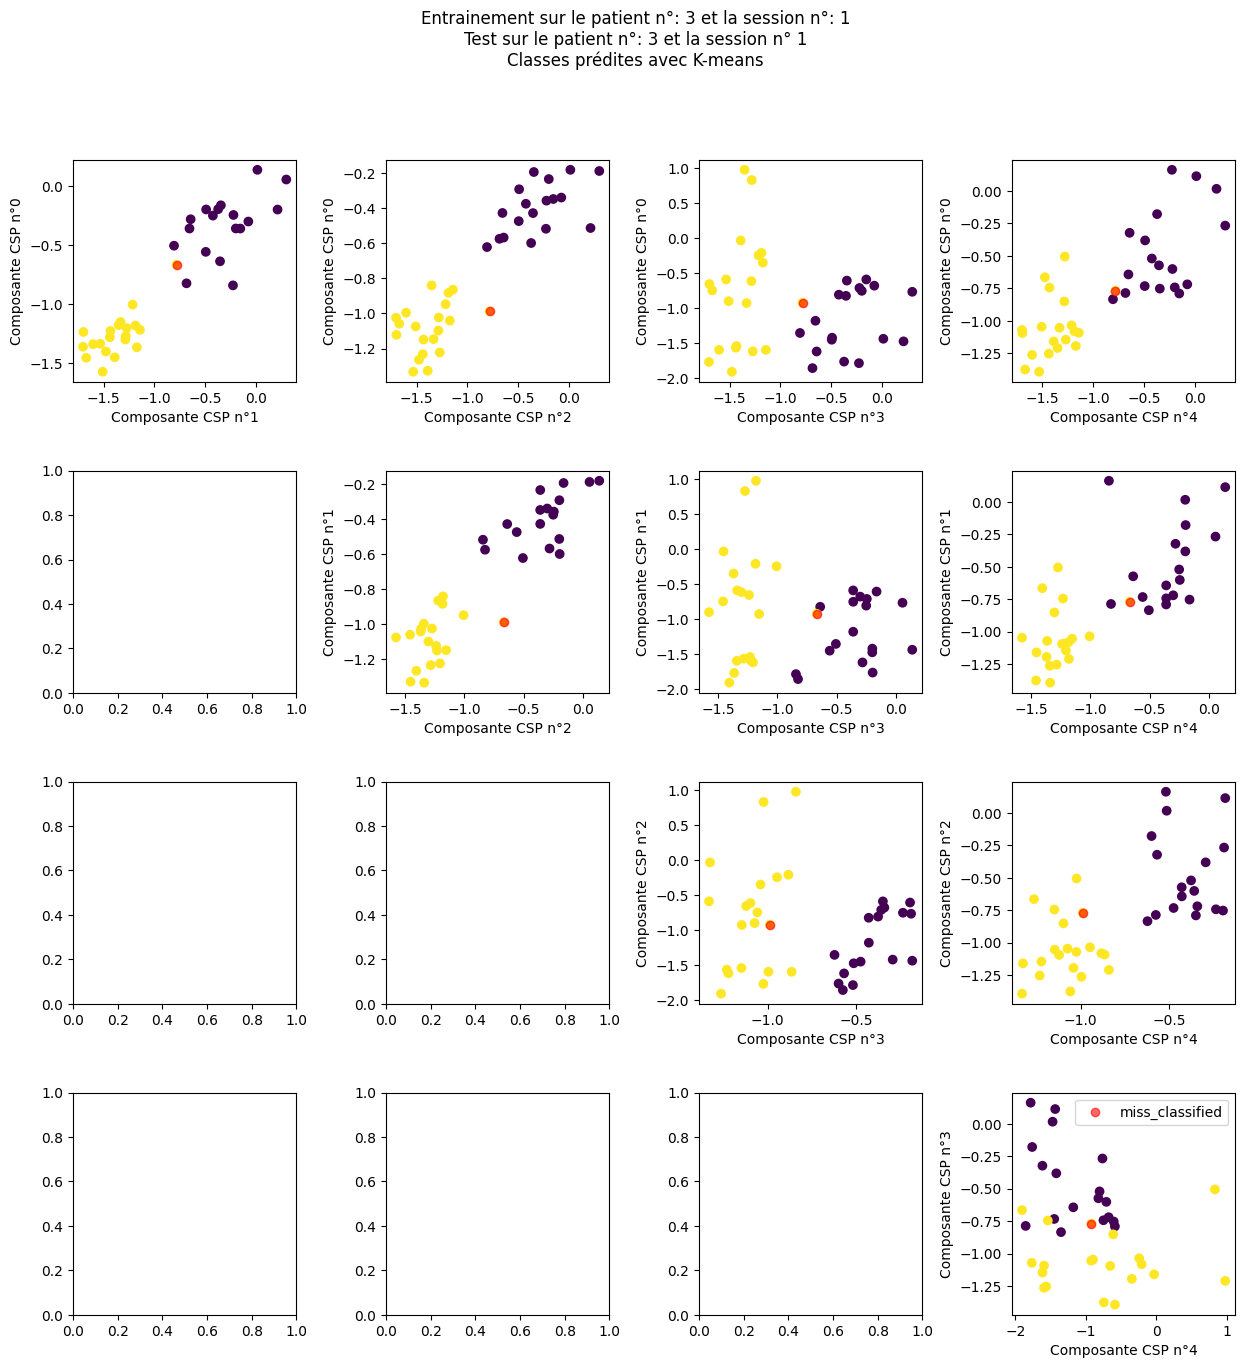

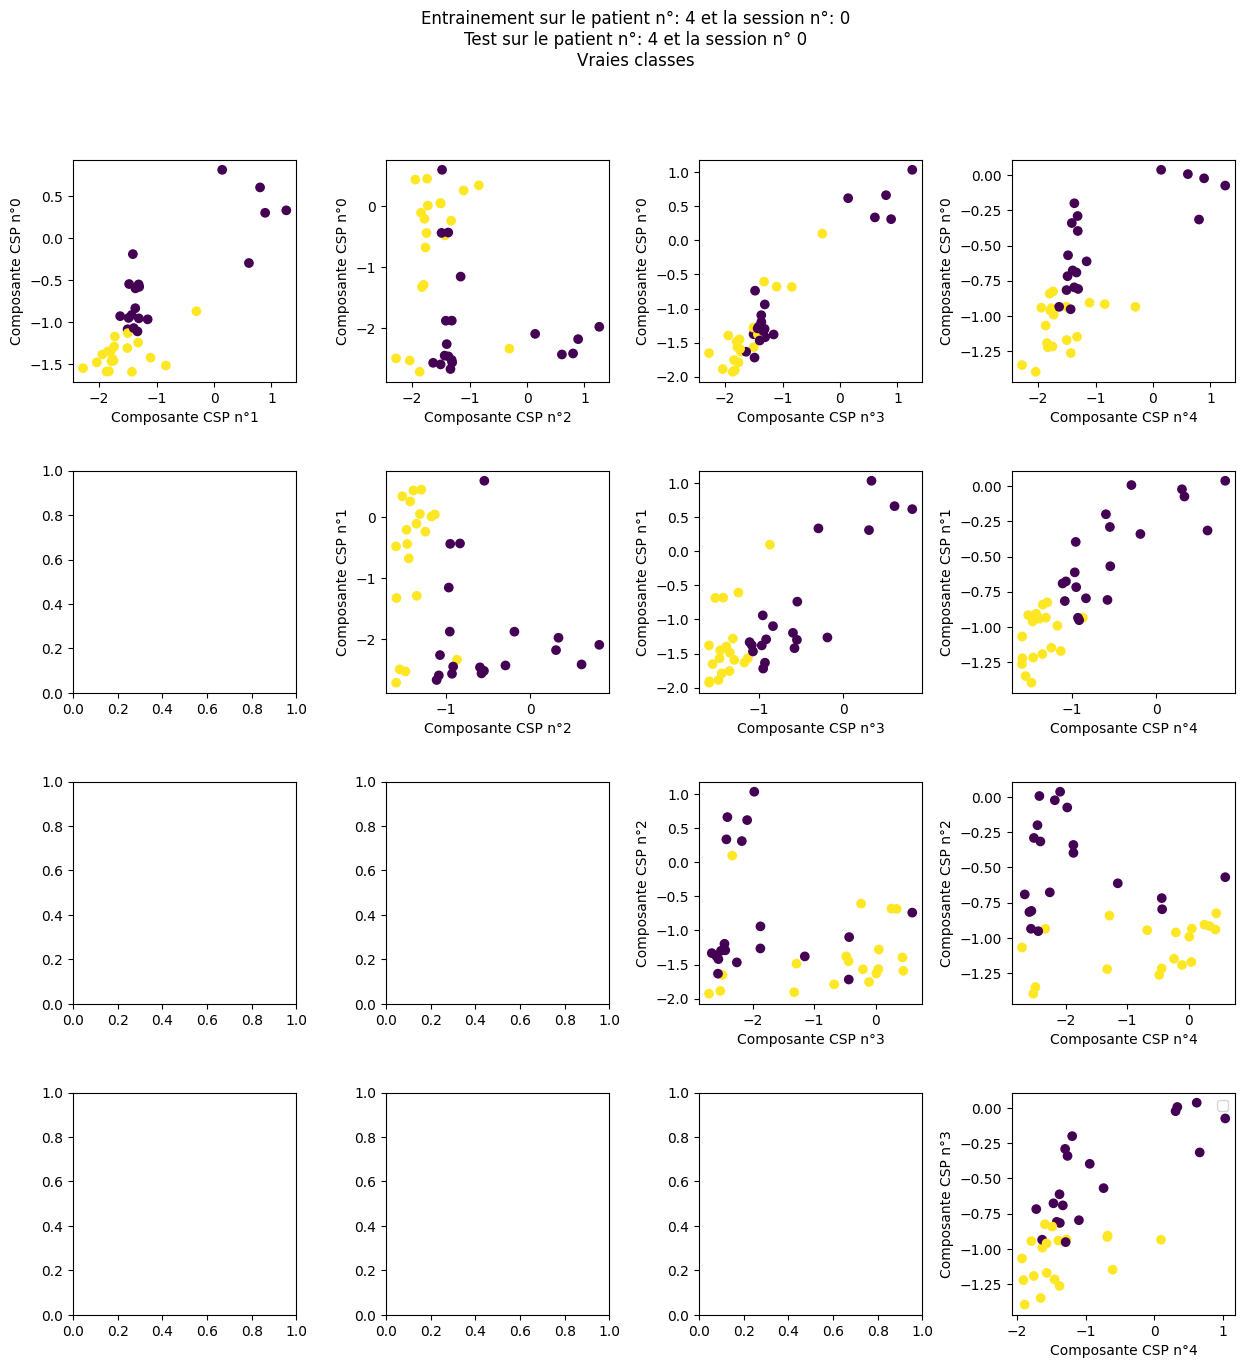

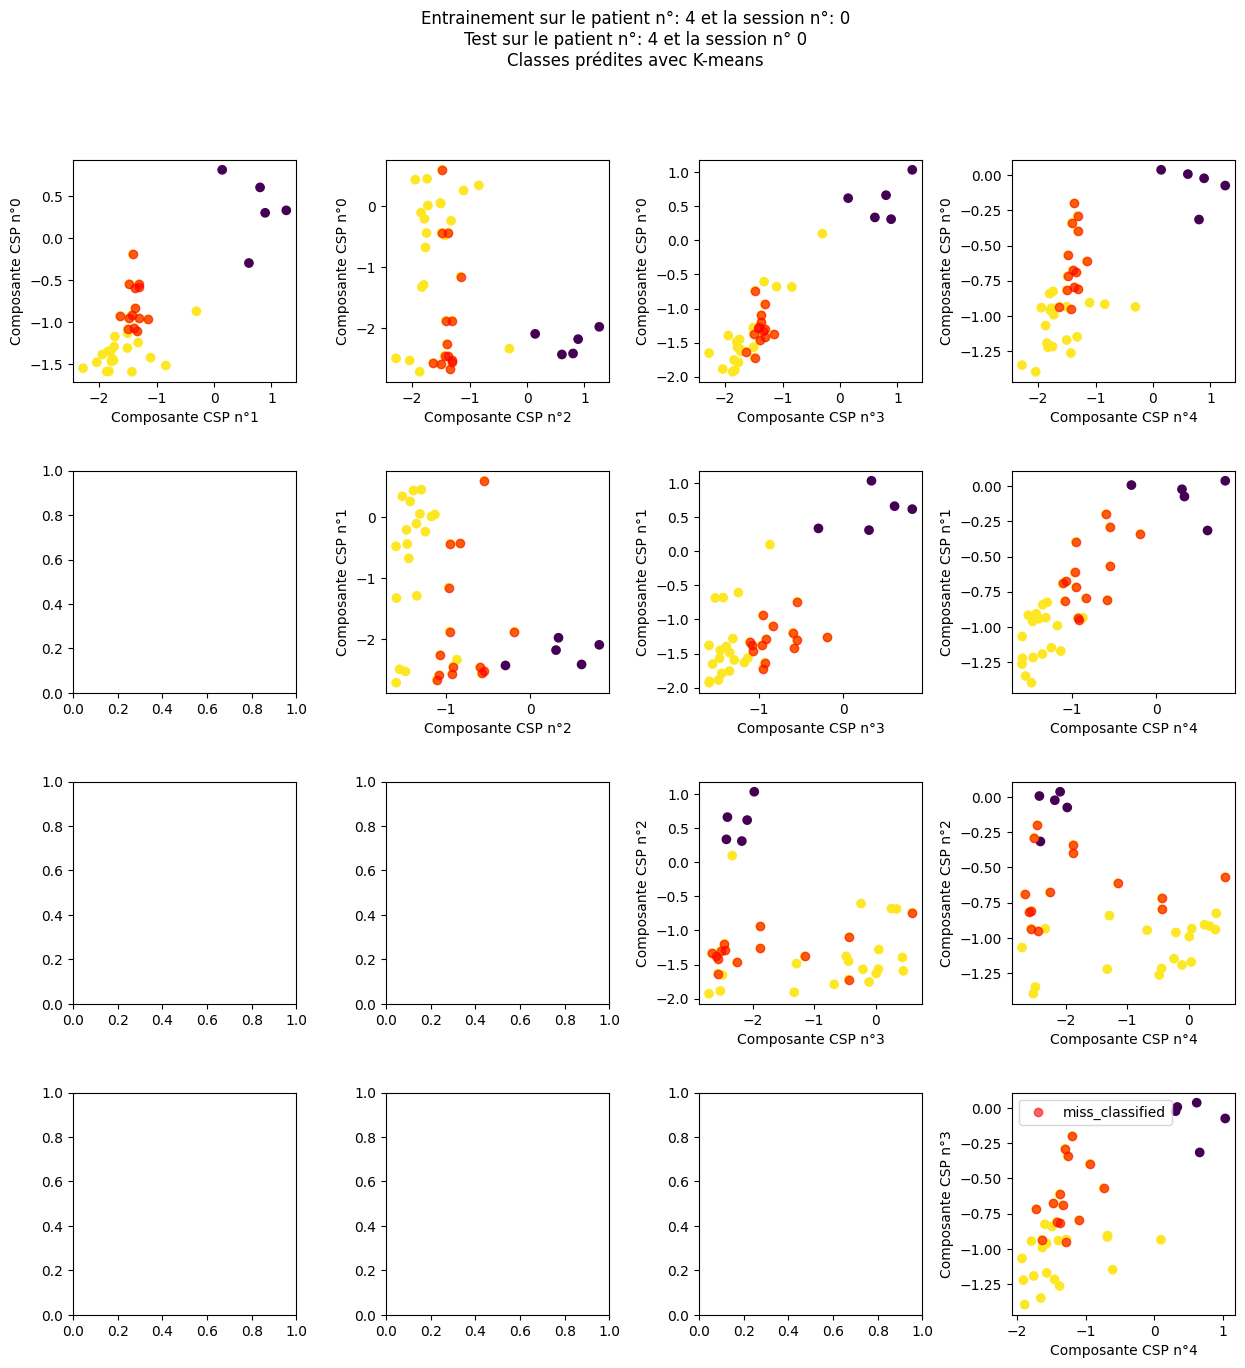

In [29]:
nbr_patients = len(X_patients)
for i_patient_train in range(nbr_patients):
    print(f'Patient {i_patient_train}')
    
    nbr_sessions = len(X_patients[i_patient_train])
    if nbr_patients < 2:
        print(f"  Abort, not enough sessions")
        continue

    for i_session_train in range(nbr_sessions):
        X_patient = X_patients[i_patient_train][i_session_train].copy()
        y_patient = y_patients[i_patient_train][i_session_train].copy()

        i_patient_test = np.random.randint(0,nbr_patients)
        i_session_test = np.random.randint(0,nbr_sessions)
        X_test = X_patients[i_patient_test][i_session_test].copy()
        y_test = y_patients[i_patient_test][i_session_test].copy()

        csp = CSP(n_components=5)
        sc  = StandardScaler()
        km = KMeans(n_clusters=2)
        svc = SVC(kernel='linear', C=.001)
        
        # rf  = RandomForestClassifier()
        # pip = Pipeline([('CSP', csp), ('sc', sc), ('SVC', svc)])
        pip = Pipeline([('CSP', csp), ('sc', sc), ('Kmeans', km)])

        pip.fit(X_patient, y_patient)
        # score = pip.score(X_test, y_test)

       
        y_pred = pip.predict(X_test)
        score = accuracy_score(y_test,y_pred)

        csp_data = pip.named_steps["CSP"].transform(X_test)

        # we just want to separate both classes without taking into consideration if the name of the label is right or not
        if score < 0.5:
            score = 1 - score 
            y_pred = 1 - y_pred

        miss_classification = np.abs(y_pred - y_test) > 0.5 # 

        plot_csp(csp_data, y_test)
        plt.suptitle(f"Entrainement sur le patient n°: {i_patient_train} et la session n°: {i_session_train}\n" +
                     f"Test sur le patient n°: {i_patient_test} et la session n° {i_session_test}\n" +
                     "Vraies classes")
        
        plot_csp(csp_data, y_pred,miss_classification)
        plt.suptitle(f"Entrainement sur le patient n°: {i_patient_train} et la session n°: {i_session_train}\n" +
                     f"Test sur le patient n°: {i_patient_test} et la session n° {i_session_test}\n" +
                     "Classes prédites avec K-means")
        
       
        print(f'  Train on patient n°: {i_patient_train} and session n°: {i_session_train} - Score: {score : .3f} \n Test on patient n°: {i_patient_test} and session n °: {i_session_test}')

# 4 - 2ème Cas d'utilisation: Système de vote sur CSP

L'idée ici était de créer pour chaque session une pipeline CSP + StandardScaler + Kmeans puis d'élire ensuite la meilleure pipeline. C'est-à-dire la pipeline qui classifie le mieux l'ensemble des données.

Les résultats ne sont pas bons ici.

In [54]:
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import balanced_accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from mne.decoding import CSP

N_COMPONENTS = 5
N_SPLITS = 5


class VotingClassifier():
    def __init__(self) -> None:
        self.clfs = []
        self.y_true = None

    def fit_clf_session(self, X, y):
        """
        Fits the inner classifiers on sessions data. 
        NB: one session is a list of epochs.

        X: list of epochs
        y: list of labels
        """
        csp = CSP(n_components=N_COMPONENTS, reg=None, log=True, norm_trace=False)
        sc = StandardScaler()
        km = KMeans(n_clusters=2)
        clf = Pipeline([('CSP', csp), ('SC', sc), ('KMEANS', km)])

        clf.fit(X, y)
        return clf
        
    def fit(self, X, y):
        """
        Fits the outer classifier on sessions data.

        X: list of sessions, each session is a list of epochs
        y: list of sessions, each session is a list of labels
        """
        clfs = []
        for session in range(len(X)):
            clfs.append(self.fit_clf_session(X[session], 
                                             y[session]))
        self.clfs = clfs

    def predict(self, X, return_probas=False):
        """
        Predicts labels of data.

        X: list of epochs
        """
        X = [epoch for session in X for epoch in session]
        X = np.array(X)

        preds = np.zeros(X.shape[0])
        for i in range(len(self.clfs)):
            clf = self.clfs[i]
            y_pred = clf.predict(X)
            preds += y_pred


            # # Affichage des résultats pour le classifieur n°i
            # plt.figure(figsize=(5, 5))
            # plt.scatter(np.arange(len(y_pred)), y_pred, c=self.y_true, cmap='viridis')
            # plt.title(f'Result for classifier n°{i}')
            # plt.show()


        preds = preds / len(self.clfs)

        if return_probas:
            return (preds > 0.5).astype(int), preds
        else:
            return (preds > 0.5).astype(int)
    
    def score(self, X, y, return_probas=False):
        """
        Scores the classifier.
        
        X: list of sessions, each session is a list of epochs
        y: list of sessions, each session is a list of labels
        """
        y_flat = np.array([label for session in y for label in session])
        y_pred = self.predict(X, return_probas=False)
        return balanced_accuracy_score(y_flat, y_pred)


def cv_test_alt(data_X, data_y, verbose=False, display=False):
    """
    data_X: list of sessions, each session is a list of epochs
    data_y: list of sessions, each session is a list of labels
    """
    # Define cross validation fold
    cv = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    scores = []

    for train_idx, test_idx in cv.split(data_X):
        # Split data
        X_train = [data_X[i] for i in train_idx]
        y_train = [data_y[i] for i in train_idx]
        X_test  = [data_X[i] for i in test_idx]
        y_test  = [data_y[i] for i in test_idx]

        # Define pipelines + voting classifier
        pipeline = VotingClassifier()

        # Fit
        pipeline.fit(X_train, y_train)

        # Score
        score = pipeline.score(X_test, y_test)
        scores.append(score)

        if display:

            y_true = np.array([label for session in y_test for label in session])
            pipeline.y_true = y_true
            y_pred, probas = pipeline.predict(X_test, return_probas=True)

            plt.figure(figsize=(5, 5))
            plt.scatter(np.arange(len(probas)), probas, c=y_true, cmap='viridis')
            plt.show()

        if verbose:
            print(f'Balanced accuracy: {score}')
    
    if verbose:
        print(f'Mean balanced accuracy: {np.mean(scores)}')
    
    return scores

c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

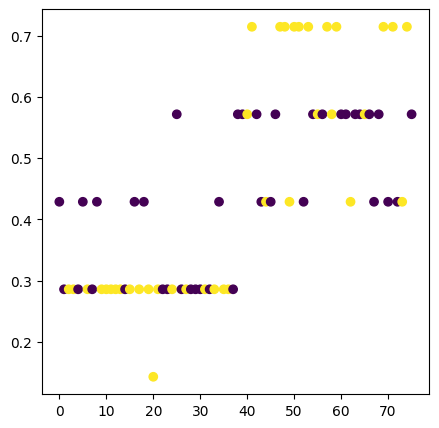

Balanced accuracy: 0.513157894736842


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

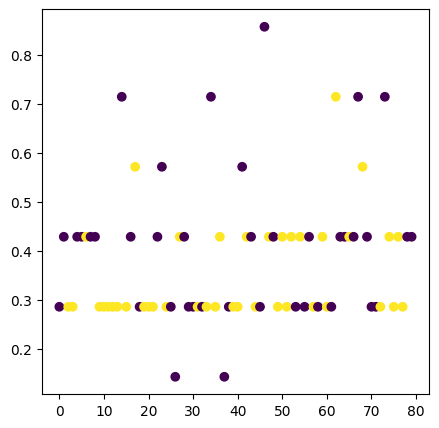

Balanced accuracy: 0.44999999999999996


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

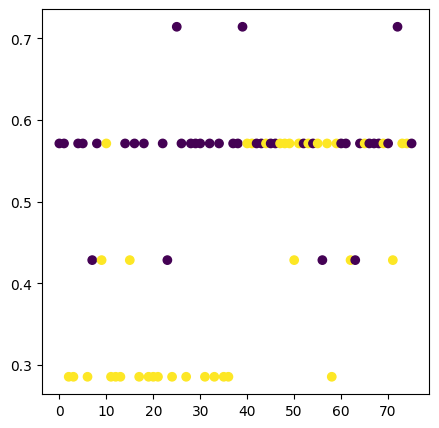

Balanced accuracy: 0.2631578947368421


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

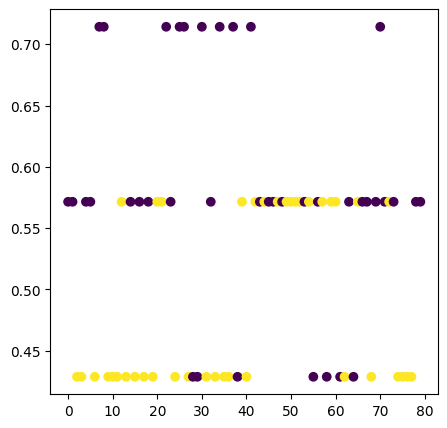

Balanced accuracy: 0.3


c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\aurel\Desktop\3ASUPAERO\PIE GIT\PIE_2023\venv\Lib\site-packages\sklearn\clus

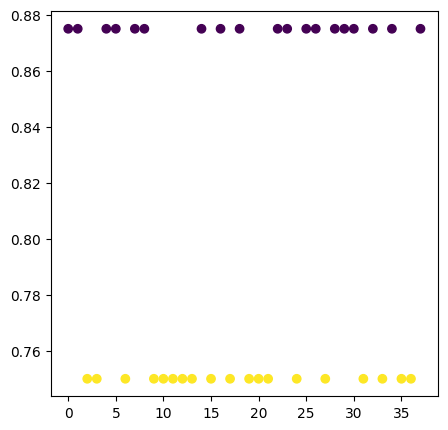

Balanced accuracy: 0.5
Mean balanced accuracy: 0.4052631578947368


[0.513157894736842, 0.44999999999999996, 0.2631578947368421, 0.3, 0.5]

In [55]:
X_sessions = [session for patient in X_patients for session in patient]
y_sessions = [session for patient in y_patients for session in patient]

cv_test_alt(X_sessions, y_sessions, verbose=True, display=True)